# Curve fitting example
This example implements a simple curve fitting using scipy -- the goal is to fit multiple Gaussians to a set of data points.

## Prerequisites
* Miniconda, after installing, add its bin directory to your PATH
* After installing Miniconda, you have to add several packages

  conda install jupyter scipy matplotlib --all 
  
  pip install lmfit
  
## How does this work
We assume the function corresponding to the data is nonlinear. We use Scipy's curve_fit method, which can be configured to apply two algorithms underneath. For the example below, we use the default, [least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares). To use curve_fit, we need a model function, call it func, that takes x and our (guessed) parameters as arguments and returns the corresponding values for y. As our model, we use a sum of gaussians:

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from lmfit import Model
from lmfit.models import GaussianModel

%matplotlib inline
plt.rcParams.update({'font.size': 14})

In [5]:
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2))

Normally the data will be binary (for better efficiency), here we read it in ASCII for clarity. The file contains one or more hits, with the following structure, with line numbers prepended (they are not part of the actual data). After the the hit line, the datapoints are listed as pairs of tick and ADC values.
<pre>
1 hit view=0 wire=594 mult=1 multMC=1 simX=102.679 simTick=2642.84 recX=102.722 recTick=2643.61 RMS=3.91939 sigma=0.21279 startTick=2629 endTick=2654 deltaX=0.0432237 deltaTicks=0.775759 nRoiADCs=114 nHitADCs=25 nRawADCs=6400 backtrackerX=102.684
2 2770,-0.539806
3 2771,-0.262643
4 2772,0.0600658
5 2773,0.325805
...
</pre>

In [6]:
x, y = np.loadtxt('hit.txt', delimiter=',', skiprows=1, unpack=True)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 116
    # variables        = 3
    chi-square         = 10.1908374
    reduced chi-square = 0.09018440
    Akaike info crit   = -276.123736
    Bayesian info crit = -267.862965
[[Variables]]
    amp:  67.0911767 +/- 1.33549771 (1.99%) (init = 35)
    cen:  2816.75256 +/- 0.08548809 (0.00%) (init = 2815)
    wid:  3.71927503 +/- 0.08548809 (2.30%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) =  0.577



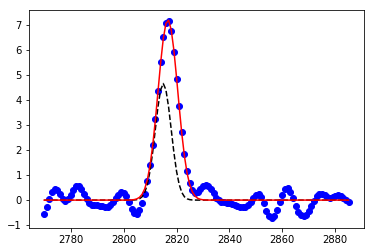

In [7]:
gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=7*5, cen=2815, wid=3)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()

For multiple peaks, we need to use multiple models. 

In [8]:
def make_model(num):
    pref = "g{0}_".format(num)
    gmodel = GaussianModel(prefix = pref)  # Use built-in Gaussian model
    gmodel.set_param_hint(pref+'amplitude', value=amplitude[num], min=1, max=amplitude[num]*7)
    gmodel.set_param_hint(pref+'center', value=center[num], min=center[num]-1., max=center[num]+1.)
    gmodel.set_param_hint(pref+'sigma', value=width[num], min=0.5, max=3)

    return gmodel

In [9]:
from scipy.signal import argrelextrema

peaks_in_interval = np.array(argrelextrema(y, np.greater)[0])
num_peaks = len(peaks_in_interval)
center = x[peaks_in_interval]
amplitude = y[peaks_in_interval]
width = np.zeros(num_peaks) + 2.0

LMFIT wraps SciPy optimization methods, which in turn call optimized libraries, such as MINPACK. The names of the method parameter are listed [here](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.minimize). For more information on the optimization algorithms, see https://docs.scipy.org/doc/scipy/reference/optimize.html

In [10]:
model = None
for i in range(num_peaks):
    this_mod = make_model(i)
    if model is None: model = this_mod
    else: model = model + this_mod

Levenberg-Marquardt (default):


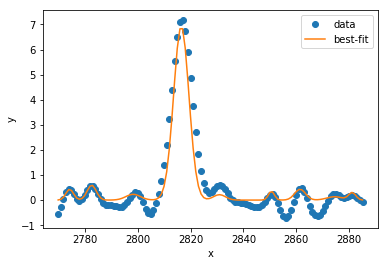

CPU times: user 315 ms, sys: 18.7 ms, total: 333 ms
Wall time: 346 ms


In [11]:
%%time
print("Levenberg-Marquardt (default):")
result = model.fit(y, x=x, method='leastsq')
result.plot_fit()
plt.title('')
plt.show()

Least-Squares minimization, using Trust Region Reflective method:


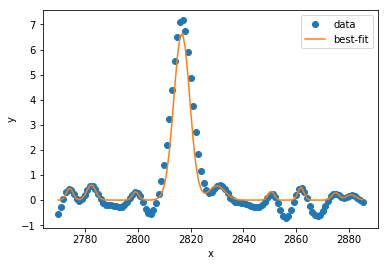

CPU times: user 2.57 s, sys: 70 ms, total: 2.64 s
Wall time: 1.4 s


In [12]:
%%time
print("Least-Squares minimization, using Trust Region Reflective method:")
result = model.fit(y, x=x, method='least_squares')
#print(result.fit_report())
result.plot_fit()
plt.title('')
plt.show()

## Putting it all together

This was the data for just one event, now we combine this for all events.

In [1]:
import mmap, contextlib, shelve, os
from io import BytesIO
import numpy as np
from lmfit.models import GaussianModel
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

In [2]:
class Hit:
    def __init__(self, hitdata):
        self.info = {}
        self.model = None 
        nl = hitdata.find(b'\n')
        header = hitdata[:nl]
        l0 = header.split()
        for i in l0[1:]: 
            k,v= i.split(b'=')
            self.info[k.decode('utf-8')]=v.decode('utf-8')
        self.name = 'w' + self.info['wire'] + '_v' + self.info['view']
        self.x, self.y = np.genfromtxt(BytesIO(hitdata[nl+1:]), delimiter=',', unpack=True)
        self.peaks_in_interval = []
        self.center = []
        self.amplitude = []
        self.width = []
        self.num_peaks = 0
        
    def fit_model(self, method='leastsq'):
        self.__init_model()
        for i in range(self.num_peaks):
            this_mod = self.__make_local_model(i)
            if self.model is None: self.model = this_mod
            else: self.model = self.model + this_mod
        return self.model.fit(self.y, x=self.x, method=method)
        
                
    def __init_model(self):
        self.peaks_in_interval = np.array(argrelextrema(self.y, np.greater)[0])
        self.num_peaks = len(self.peaks_in_interval)
        self.center = self.x[self.peaks_in_interval]
        self.amplitude = self.y[self.peaks_in_interval]
        self.width = np.zeros(self.num_peaks) + 2.0

    def __make_local_model(self, num):
        pref = "g{0}_".format(num)
        gmodel = GaussianModel(prefix = pref)  # Use built-in Gaussian model
        gmodel.set_param_hint(pref+'amplitude', value=self.amplitude[num], min=1, max=self.amplitude[num]*7)
        gmodel.set_param_hint(pref+'center', value=self.center[num], min=self.center[num]-1., max=self.center[num]+1.)
        gmodel.set_param_hint(pref+'sigma', value=self.width[num], min=0.5, max=3)
        return gmodel

In [3]:
def ReadHitData(path):
    global hits
    prev_loc=0
    
    prefix = os.path.basename(path).split('.')[0]
    if False and os.path.exists(prefix+'.shelve.db'):
        d = shelve.open(prefix+'.shelve',flag='r')
        hits = d['hits']
        d.close()
        return hits
    
    if not os.path.exists(path):
        sys.exit("Error: invalid data path: %s" % path)
    hits = []
    
    with open(path, 'r') as f:
        with contextlib.closing(mmap.mmap(f.fileno(), 0, prot=mmap.PROT_READ)) as m:
            while prev_loc >= 0:
                m.seek(prev_loc+4)
                hit_loc = m.find(b'hit view')
                hits.append(Hit(m[prev_loc:hit_loc]))
                prev_loc = hit_loc
    try:
        d = shelve.open(prefix+'.shelve',flag='n')
        d['hits'] = hits
        d.close()
    except:
        print("Could not cache data with shelve")
    return hits

In [4]:
%%time
hits = ReadHitData('all_hits.txt')

Could not cache data with shelve
CPU times: user 2min 39s, sys: 7.41 s, total: 2min 47s
Wall time: 3min 3s


In [ ]:
%%time
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('results.pdf') as pdf:
    for hit in hits:
        print (hit.info)
        result = hit.fit_model(method='leastsq')
        fig = plt.figure(figsize=(4, 5))
        result.plot_fit()
        plt.title(hit.name)
        pdf.savefig(plt.gcf())
pdf.close()

{'view': '0', 'wire': '497', 'mult': '1', 'multMC': '1', 'simX': '112.373', 'simTick': '2816.83', 'recX': '112.397', 'recTick': '2817.25', 'RMS': '3.70963', 'sigma': '0.284372', 'startTick': '2805', 'endTick': '2827', 'deltaX': '0.0234683', 'deltaTicks': '0.421199', 'nRoiADCs': '116', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '112.348'}
{'view': '0', 'wire': '498', 'mult': '1', 'multMC': '1', 'simX': '112.272', 'simTick': '2815.01', 'recX': '112.332', 'recTick': '2816.08', 'RMS': '4.07311', 'sigma': '0.253563', 'startTick': '2791', 'endTick': '2826', 'deltaX': '0.0598481', 'deltaTicks': '1.07413', 'nRoiADCs': '136', 'nHitADCs': '35', 'nRawADCs': '6400', 'backtrackerX': '112.271'}
{'view': '0', 'wire': '499', 'mult': '1', 'multMC': '1', 'simX': '112.171', 'simTick': '2813.19', 'recX': '112.207', 'recTick': '2813.84', 'RMS': '3.98604', 'sigma': '0.207177', 'startTick': '2801', 'endTick': '2828', 'deltaX': '0.0359393', 'deltaTicks': '0.645022', 'nRoiADCs': '128', 'nHitADCs': '

/Users/norris/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'view': '0', 'wire': '634', 'mult': '1', 'multMC': '3', 'simX': '98.7361', 'simTick': '2572.07', 'recX': '98.7743', 'recTick': '2572.76', 'RMS': '4.17065', 'sigma': '0.22609', 'startTick': '2551', 'endTick': '2594', 'deltaX': '0.0381814', 'deltaTicks': '0.685262', 'nRoiADCs': '116', 'nHitADCs': '43', 'nRawADCs': '6400', 'backtrackerX': '98.7357'}
{'view': '0', 'wire': '640', 'mult': '1', 'multMC': '1', 'simX': '98.1614', 'simTick': '2561.76', 'recX': '98.218', 'recTick': '2562.77', 'RMS': '3.97541', 'sigma': '0.224998', 'startTick': '2548', 'endTick': '2576', 'deltaX': '0.0565791', 'deltaTicks': '1.01546', 'nRoiADCs': '116', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '98.1628'}
{'view': '0', 'wire': '647', 'mult': '1', 'multMC': '1', 'simX': '97.4901', 'simTick': '2549.71', 'recX': '97.5379', 'recTick': '2550.57', 'RMS': '4.05264', 'sigma': '0.239977', 'startTick': '2539', 'endTick': '2563', 'deltaX': '0.0477977', 'deltaTicks': '0.857851', 'nRoiADCs': '117', 'nHitADCs': '24

{'view': '0', 'wire': '684', 'mult': '1', 'multMC': '2', 'simX': '93.9399', 'simTick': '2485.99', 'recX': '93.9913', 'recTick': '2486.91', 'RMS': '3.66548', 'sigma': '0.176577', 'startTick': '2468', 'endTick': '2503', 'deltaX': '0.0513537', 'deltaTicks': '0.921672', 'nRoiADCs': '133', 'nHitADCs': '35', 'nRawADCs': '6400', 'backtrackerX': '93.9353'}
{'view': '0', 'wire': '687', 'mult': '1', 'multMC': '3', 'simX': '93.6479', 'simTick': '2480.75', 'recX': '93.6953', 'recTick': '2481.6', 'RMS': '4.34517', 'sigma': '0.244183', 'startTick': '2463', 'endTick': '2501', 'deltaX': '0.0474092', 'deltaTicks': '0.850879', 'nRoiADCs': '130', 'nHitADCs': '38', 'nRawADCs': '6400', 'backtrackerX': '93.6437'}
{'view': '0', 'wire': '690', 'mult': '1', 'multMC': '2', 'simX': '93.3525', 'simTick': '2475.45', 'recX': '93.4141', 'recTick': '2476.55', 'RMS': '3.81302', 'sigma': '0.21921', 'startTick': '2467', 'endTick': '2489', 'deltaX': '0.0615335', 'deltaTicks': '1.10437', 'nRoiADCs': '117', 'nHitADCs': '22

{'view': '0', 'wire': '717', 'mult': '1', 'multMC': '1', 'simX': '90.7', 'simTick': '2427.84', 'recX': '90.7371', 'recTick': '2428.51', 'RMS': '3.56846', 'sigma': '0.194506', 'startTick': '2417', 'endTick': '2439', 'deltaX': '0.0371561', 'deltaTicks': '0.666861', 'nRoiADCs': '115', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '90.6971'}
{'view': '0', 'wire': '718', 'mult': '1', 'multMC': '1', 'simX': '90.6024', 'simTick': '2426.09', 'recX': '90.6426', 'recTick': '2426.81', 'RMS': '3.99506', 'sigma': '0.196323', 'startTick': '2416', 'endTick': '2445', 'deltaX': '0.0402', 'deltaTicks': '0.721491', 'nRoiADCs': '137', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '90.5965'}
{'view': '0', 'wire': '719', 'mult': '1', 'multMC': '1', 'simX': '90.5048', 'simTick': '2424.34', 'recX': '90.5501', 'recTick': '2425.15', 'RMS': '3.99198', 'sigma': '0.198755', 'startTick': '2409', 'endTick': '2442', 'deltaX': '0.0453387', 'deltaTicks': '0.813719', 'nRoiADCs': '143', 'nHitADCs': '33', 

{'view': '0', 'wire': '748', 'mult': '1', 'multMC': '2', 'simX': '87.6227', 'simTick': '2372.61', 'recX': '87.6977', 'recTick': '2373.96', 'RMS': '3.85582', 'sigma': '0.208988', 'startTick': '2360', 'endTick': '2384', 'deltaX': '0.0749653', 'deltaTicks': '1.34544', 'nRoiADCs': '134', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '87.6337'}
{'view': '0', 'wire': '749', 'mult': '1', 'multMC': '1', 'simX': '87.5218', 'simTick': '2370.8', 'recX': '87.5818', 'recTick': '2371.88', 'RMS': '3.5658', 'sigma': '0.189795', 'startTick': '2361', 'endTick': '2382', 'deltaX': '0.0600231', 'deltaTicks': '1.07727', 'nRoiADCs': '116', 'nHitADCs': '21', 'nRawADCs': '6400', 'backtrackerX': '87.5259'}
{'view': '0', 'wire': '750', 'mult': '1', 'multMC': '1', 'simX': '87.4209', 'simTick': '2368.99', 'recX': '87.4625', 'recTick': '2369.74', 'RMS': '3.6961', 'sigma': '0.225316', 'startTick': '2352', 'endTick': '2380', 'deltaX': '0.0415305', 'deltaTicks': '0.745371', 'nRoiADCs': '129', 'nHitADCs': '28',

{'view': '0', 'wire': '778', 'mult': '1', 'multMC': '2', 'simX': '84.6511', 'simTick': '2319.28', 'recX': '84.7059', 'recTick': '2320.26', 'RMS': '3.62606', 'sigma': '0.216301', 'startTick': '2309', 'endTick': '2332', 'deltaX': '0.0547526', 'deltaTicks': '0.982674', 'nRoiADCs': '109', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '84.6545'}
{'view': '0', 'wire': '781', 'mult': '1', 'multMC': '2', 'simX': '84.3496', 'simTick': '2313.87', 'recX': '84.4104', 'recTick': '2314.96', 'RMS': '3.70644', 'sigma': '0.202855', 'startTick': '2303', 'endTick': '2329', 'deltaX': '0.0607841', 'deltaTicks': '1.09092', 'nRoiADCs': '110', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '84.3599'}
{'view': '0', 'wire': '782', 'mult': '1', 'multMC': '2', 'simX': '84.2493', 'simTick': '2312.07', 'recX': '84.2989', 'recTick': '2312.96', 'RMS': '3.71013', 'sigma': '0.202847', 'startTick': '2301', 'endTick': '2327', 'deltaX': '0.049671', 'deltaTicks': '0.891472', 'nRoiADCs': '110', 'nHitADCs': '2

{'view': '0', 'wire': '819', 'mult': '1', 'multMC': '1', 'simX': '80.5771', 'simTick': '2246.16', 'recX': '80.624', 'recTick': '2247', 'RMS': '3.66776', 'sigma': '0.196494', 'startTick': '2229', 'endTick': '2259', 'deltaX': '0.0468525', 'deltaTicks': '0.840888', 'nRoiADCs': '110', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '80.5756'}
{'view': '0', 'wire': '820', 'mult': '1', 'multMC': '1', 'simX': '80.4783', 'simTick': '2244.39', 'recX': '80.5237', 'recTick': '2245.2', 'RMS': '3.60737', 'sigma': '0.188291', 'startTick': '2227', 'endTick': '2257', 'deltaX': '0.0454776', 'deltaTicks': '0.816211', 'nRoiADCs': '110', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '80.4748'}
{'view': '0', 'wire': '821', 'mult': '1', 'multMC': '1', 'simX': '80.3794', 'simTick': '2242.61', 'recX': '80.4371', 'recTick': '2243.65', 'RMS': '3.64138', 'sigma': '0.187854', 'startTick': '2221', 'endTick': '2255', 'deltaX': '0.0577192', 'deltaTicks': '1.03592', 'nRoiADCs': '111', 'nHitADCs': '34', 

{'view': '0', 'wire': '860', 'mult': '1', 'multMC': '1', 'simX': '76.4697', 'simTick': '2172.44', 'recX': '76.5254', 'recTick': '2173.44', 'RMS': '3.64401', 'sigma': '0.197678', 'startTick': '2161', 'endTick': '2188', 'deltaX': '0.0556478', 'deltaTicks': '0.998741', 'nRoiADCs': '110', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '76.468'}
{'view': '0', 'wire': '861', 'mult': '1', 'multMC': '1', 'simX': '76.3699', 'simTick': '2170.65', 'recX': '76.4089', 'recTick': '2171.35', 'RMS': '3.79691', 'sigma': '0.19786', 'startTick': '2157', 'endTick': '2189', 'deltaX': '0.0389683', 'deltaTicks': '0.699385', 'nRoiADCs': '110', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '76.3693'}
{'view': '0', 'wire': '862', 'mult': '1', 'multMC': '2', 'simX': '76.2701', 'simTick': '2168.86', 'recX': '76.3117', 'recTick': '2169.61', 'RMS': '3.86845', 'sigma': '0.212171', 'startTick': '2155', 'endTick': '2187', 'deltaX': '0.0415915', 'deltaTicks': '0.746465', 'nRoiADCs': '111', 'nHitADCs': '3

{'view': '0', 'wire': '936', 'mult': '1', 'multMC': '1', 'simX': '68.8207', 'simTick': '2035.16', 'recX': '68.896', 'recTick': '2036.51', 'RMS': '3.56841', 'sigma': '0.188117', 'startTick': '2026', 'endTick': '2048', 'deltaX': '0.0753349', 'deltaTicks': '1.35208', 'nRoiADCs': '136', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '68.8366'}
{'view': '0', 'wire': '937', 'mult': '1', 'multMC': '1', 'simX': '68.7199', 'simTick': '2033.35', 'recX': '68.7873', 'recTick': '2034.56', 'RMS': '3.59314', 'sigma': '0.194039', 'startTick': '2024', 'endTick': '2048', 'deltaX': '0.0674308', 'deltaTicks': '1.21022', 'nRoiADCs': '135', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '68.7317'}
{'view': '0', 'wire': '938', 'mult': '1', 'multMC': '1', 'simX': '68.6191', 'simTick': '2031.54', 'recX': '68.6889', 'recTick': '2032.8', 'RMS': '3.60065', 'sigma': '0.234779', 'startTick': '2020', 'endTick': '2045', 'deltaX': '0.0697562', 'deltaTicks': '1.25195', 'nRoiADCs': '115', 'nHitADCs': '25',

{'view': '0', 'wire': '969', 'mult': '1', 'multMC': '1', 'simX': '65.5716', 'simTick': '1976.85', 'recX': '65.6353', 'recTick': '1977.99', 'RMS': '3.84496', 'sigma': '0.223853', 'startTick': '1961', 'endTick': '1990', 'deltaX': '0.0636934', 'deltaTicks': '1.14314', 'nRoiADCs': '139', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '65.5837'}
{'view': '0', 'wire': '970', 'mult': '1', 'multMC': '1', 'simX': '65.4734', 'simTick': '1975.09', 'recX': '65.5386', 'recTick': '1976.26', 'RMS': '3.5969', 'sigma': '0.198875', 'startTick': '1961', 'endTick': '1988', 'deltaX': '0.0652551', 'deltaTicks': '1.17117', 'nRoiADCs': '129', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '65.4822'}
{'view': '0', 'wire': '971', 'mult': '1', 'multMC': '2', 'simX': '65.3752', 'simTick': '1973.32', 'recX': '65.443', 'recTick': '1974.54', 'RMS': '3.67605', 'sigma': '0.196225', 'startTick': '1955', 'endTick': '1985', 'deltaX': '0.0677691', 'deltaTicks': '1.21629', 'nRoiADCs': '140', 'nHitADCs': '30',

{'view': '0', 'wire': '1004', 'mult': '1', 'multMC': '1', 'simX': '62.145', 'simTick': '1915.35', 'recX': '62.1954', 'recTick': '1916.26', 'RMS': '3.73647', 'sigma': '0.206252', 'startTick': '1898', 'endTick': '1929', 'deltaX': '0.0504202', 'deltaTicks': '0.904919', 'nRoiADCs': '139', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '62.1377'}
{'view': '0', 'wire': '1005', 'mult': '1', 'multMC': '1', 'simX': '62.0469', 'simTick': '1913.59', 'recX': '62.1004', 'recTick': '1914.55', 'RMS': '3.45687', 'sigma': '0.193173', 'startTick': '1902', 'endTick': '1925', 'deltaX': '0.0535735', 'deltaTicks': '0.961512', 'nRoiADCs': '127', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '62.0447'}
{'view': '0', 'wire': '1006', 'mult': '1', 'multMC': '1', 'simX': '61.9487', 'simTick': '1911.83', 'recX': '61.9888', 'recTick': '1912.55', 'RMS': '3.57152', 'sigma': '0.200569', 'startTick': '1898', 'endTick': '1923', 'deltaX': '0.0401514', 'deltaTicks': '0.720619', 'nRoiADCs': '127', 'nHitADCs'

{'view': '0', 'wire': '1041', 'mult': '1', 'multMC': '1', 'simX': '58.4078', 'simTick': '1848.28', 'recX': '58.4714', 'recTick': '1849.42', 'RMS': '3.5275', 'sigma': '0.193109', 'startTick': '1839', 'endTick': '1867', 'deltaX': '0.0635898', 'deltaTicks': '1.14128', 'nRoiADCs': '131', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '58.4066'}
{'view': '0', 'wire': '1042', 'mult': '1', 'multMC': '2', 'simX': '58.307', 'simTick': '1846.47', 'recX': '58.3336', 'recTick': '1846.94', 'RMS': '3.81021', 'sigma': '0.194143', 'startTick': '1829', 'endTick': '1862', 'deltaX': '0.0265392', 'deltaTicks': '0.476313', 'nRoiADCs': '131', 'nHitADCs': '33', 'nRawADCs': '6400', 'backtrackerX': '58.3039'}
{'view': '0', 'wire': '1045', 'mult': '1', 'multMC': '3', 'simX': '58.0034', 'simTick': '1841.02', 'recX': '58.0584', 'recTick': '1842.01', 'RMS': '3.8117', 'sigma': '0.211017', 'startTick': '1826', 'endTick': '1860', 'deltaX': '0.0549905', 'deltaTicks': '0.986944', 'nRoiADCs': '117', 'nHitADCs': '

{'view': '0', 'wire': '1074', 'mult': '1', 'multMC': '1', 'simX': '55.0981', 'simTick': '1788.88', 'recX': '55.1542', 'recTick': '1789.88', 'RMS': '3.35753', 'sigma': '0.200386', 'startTick': '1781', 'endTick': '1806', 'deltaX': '0.0561336', 'deltaTicks': '1.00746', 'nRoiADCs': '129', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '55.0996'}
{'view': '0', 'wire': '1075', 'mult': '1', 'multMC': '1', 'simX': '54.9981', 'simTick': '1787.08', 'recX': '55.0402', 'recTick': '1787.84', 'RMS': '3.51203', 'sigma': '0.163839', 'startTick': '1773', 'endTick': '1797', 'deltaX': '0.0421255', 'deltaTicks': '0.756049', 'nRoiADCs': '139', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '54.9964'}
{'view': '0', 'wire': '1076', 'mult': '1', 'multMC': '1', 'simX': '54.8981', 'simTick': '1785.29', 'recX': '54.9497', 'recTick': '1786.21', 'RMS': '3.89331', 'sigma': '0.198433', 'startTick': '1769', 'endTick': '1799', 'deltaX': '0.0515418', 'deltaTicks': '0.925049', 'nRoiADCs': '130', 'nHitADCs'

{'view': '0', 'wire': '1101', 'mult': '1', 'multMC': '1', 'simX': '52.3608', 'simTick': '1739.75', 'recX': '52.4169', 'recTick': '1740.75', 'RMS': '3.46754', 'sigma': '0.190294', 'startTick': '1730', 'endTick': '1752', 'deltaX': '0.0560466', 'deltaTicks': '1.0059', 'nRoiADCs': '133', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '52.3679'}
{'view': '0', 'wire': '1102', 'mult': '1', 'multMC': '1', 'simX': '52.2588', 'simTick': '1737.92', 'recX': '52.3132', 'recTick': '1738.89', 'RMS': '3.54125', 'sigma': '0.182102', 'startTick': '1727', 'endTick': '1752', 'deltaX': '0.054408', 'deltaTicks': '0.976489', 'nRoiADCs': '140', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '52.2624'}
{'view': '0', 'wire': '1107', 'mult': '1', 'multMC': '2', 'simX': '51.7572', 'simTick': '1728.92', 'recX': '51.8067', 'recTick': '1729.8', 'RMS': '3.5232', 'sigma': '0.19853', 'startTick': '1713', 'endTick': '1740', 'deltaX': '0.0494968', 'deltaTicks': '0.888346', 'nRoiADCs': '127', 'nHitADCs': '27

{'view': '0', 'wire': '1149', 'mult': '1', 'multMC': '1', 'simX': '47.6458', 'simTick': '1655.13', 'recX': '47.6934', 'recTick': '1655.98', 'RMS': '3.5779', 'sigma': '0.184329', 'startTick': '1643', 'endTick': '1668', 'deltaX': '0.0476276', 'deltaTicks': '0.854798', 'nRoiADCs': '135', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '47.6427'}
{'view': '0', 'wire': '1150', 'mult': '1', 'multMC': '1', 'simX': '47.5484', 'simTick': '1653.38', 'recX': '47.6025', 'recTick': '1654.35', 'RMS': '3.61204', 'sigma': '0.181969', 'startTick': '1643', 'endTick': '1669', 'deltaX': '0.0540946', 'deltaTicks': '0.970864', 'nRoiADCs': '132', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '47.553'}
{'view': '0', 'wire': '1151', 'mult': '1', 'multMC': '1', 'simX': '47.451', 'simTick': '1651.63', 'recX': '47.5021', 'recTick': '1652.55', 'RMS': '3.88581', 'sigma': '0.211193', 'startTick': '1642', 'endTick': '1664', 'deltaX': '0.0510598', 'deltaTicks': '0.916398', 'nRoiADCs': '132', 'nHitADCs': 

{'view': '1', 'wire': '2833', 'mult': '1', 'multMC': '3', 'simX': '85.6697', 'simTick': '2342.1', 'recX': '85.7184', 'recTick': '2342.97', 'RMS': '10.7244', 'sigma': '0.0997296', 'startTick': '2311', 'endTick': '2376', 'deltaX': '0.0486921', 'deltaTicks': '0.873904', 'nRoiADCs': '152', 'nHitADCs': '65', 'nRawADCs': '6400', 'backtrackerX': '85.713'}
{'view': '1', 'wire': '2836', 'mult': '1', 'multMC': '4', 'simX': '83.1239', 'simTick': '2296.41', 'recX': '83.1535', 'recTick': '2296.94', 'RMS': '10.5498', 'sigma': '0.109634', 'startTick': '2269', 'endTick': '2330', 'deltaX': '0.0296864', 'deltaTicks': '0.532798', 'nRoiADCs': '155', 'nHitADCs': '61', 'nRawADCs': '6400', 'backtrackerX': '83.1462'}
{'view': '1', 'wire': '2838', 'mult': '1', 'multMC': '3', 'simX': '81.4968', 'simTick': '2267.21', 'recX': '81.593', 'recTick': '2268.93', 'RMS': '9.3572', 'sigma': '0.0954012', 'startTick': '2235', 'endTick': '2296', 'deltaX': '0.0961667', 'deltaTicks': '1.72596', 'nRoiADCs': '146', 'nHitADCs': 

{'view': '1', 'wire': '2871', 'mult': '1', 'multMC': '1', 'simX': '55.4267', 'simTick': '1799.31', 'recX': '55.428', 'recTick': '1799.34', 'RMS': '8.47127', 'sigma': '0.0838052', 'startTick': '1768', 'endTick': '1830', 'deltaX': '0.00131052', 'deltaTicks': '0.0235207', 'nRoiADCs': '206', 'nHitADCs': '62', 'nRawADCs': '6400', 'backtrackerX': '55.4004'}
{'view': '1', 'wire': '2872', 'mult': '1', 'multMC': '1', 'simX': '54.6561', 'simTick': '1785.48', 'recX': '54.5871', 'recTick': '1784.24', 'RMS': '8.38753', 'sigma': '0.0837557', 'startTick': '1754', 'endTick': '1809', 'deltaX': '-0.0689537', 'deltaTicks': '-1.23755', 'nRoiADCs': '151', 'nHitADCs': '55', 'nRawADCs': '6400', 'backtrackerX': '54.5563'}
{'view': '1', 'wire': '2873', 'mult': '1', 'multMC': '2', 'simX': '53.8855', 'simTick': '1771.65', 'recX': '53.7049', 'recTick': '1768.41', 'RMS': '8.98443', 'sigma': '0.0896715', 'startTick': '1742', 'endTick': '1796', 'deltaX': '-0.180558', 'deltaTicks': '-3.24056', 'nRoiADCs': '149', 'nHi

{'view': '2', 'wire': '5056', 'mult': '1', 'multMC': '1', 'simX': '109.967', 'simTick': '2781.42', 'recX': '109.992', 'recTick': '2781.87', 'RMS': '4.00122', 'sigma': '0.24175', 'startTick': '2768', 'endTick': '2799', 'deltaX': '0.0253363', 'deltaTicks': '0.454724', 'nRoiADCs': '119', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '109.969'}
{'view': '2', 'wire': '5057', 'mult': '1', 'multMC': '1', 'simX': '109.875', 'simTick': '2779.78', 'recX': '109.934', 'recTick': '2780.82', 'RMS': '3.82589', 'sigma': '0.289329', 'startTick': '2765', 'endTick': '2794', 'deltaX': '0.0584682', 'deltaTicks': '1.04936', 'nRoiADCs': '117', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '109.873'}
{'view': '2', 'wire': '5058', 'mult': '1', 'multMC': '1', 'simX': '109.784', 'simTick': '2778.13', 'recX': '109.84', 'recTick': '2779.14', 'RMS': '3.90743', 'sigma': '0.306729', 'startTick': '2761', 'endTick': '2790', 'deltaX': '0.0560145', 'deltaTicks': '1.00532', 'nRoiADCs': '117', 'nHitADCs': '

{'view': '2', 'wire': '5094', 'mult': '1', 'multMC': '1', 'simX': '106.492', 'simTick': '2719.05', 'recX': '106.548', 'recTick': '2720.05', 'RMS': '3.81826', 'sigma': '0.303439', 'startTick': '2703', 'endTick': '2732', 'deltaX': '0.0558205', 'deltaTicks': '1.00184', 'nRoiADCs': '120', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '106.496'}
{'view': '2', 'wire': '5095', 'mult': '1', 'multMC': '1', 'simX': '106.4', 'simTick': '2717.41', 'recX': '106.451', 'recTick': '2718.32', 'RMS': '3.99356', 'sigma': '0.338219', 'startTick': '2702', 'endTick': '2728', 'deltaX': '0.0509542', 'deltaTicks': '0.914502', 'nRoiADCs': '116', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '106.4'}
{'view': '2', 'wire': '5096', 'mult': '1', 'multMC': '1', 'simX': '106.309', 'simTick': '2715.76', 'recX': '106.357', 'recTick': '2716.62', 'RMS': '3.79797', 'sigma': '0.283097', 'startTick': '2702', 'endTick': '2737', 'deltaX': '0.0479787', 'deltaTicks': '0.861099', 'nRoiADCs': '117', 'nHitADCs': '3

{'view': '2', 'wire': '5154', 'mult': '2', 'multMC': '1', 'simX': '101.097', 'simTick': '2622.23', 'recX': '101.104', 'recTick': '2622.36', 'RMS': '3.34166', 'sigma': '0.329731', 'startTick': '2605', 'endTick': '2658', 'deltaX': '0.00726454', 'deltaTicks': '0.130381', 'nRoiADCs': '141', 'nHitADCs': '53', 'nRawADCs': '6400', 'backtrackerX': '101.099'}
{'view': '2', 'wire': '5155', 'mult': '2', 'multMC': '1', 'simX': '101.007', 'simTick': '2620.62', 'recX': '101.021', 'recTick': '2620.87', 'RMS': '3.44015', 'sigma': '0.283834', 'startTick': '2610', 'endTick': '2657', 'deltaX': '0.0141505', 'deltaTicks': '0.253967', 'nRoiADCs': '145', 'nHitADCs': '47', 'nRawADCs': '6400', 'backtrackerX': '101.009'}
{'view': '2', 'wire': '5156', 'mult': '2', 'multMC': '1', 'simX': '100.918', 'simTick': '2619', 'recX': '100.964', 'recTick': '2619.85', 'RMS': '3.82991', 'sigma': '0.28591', 'startTick': '2606', 'endTick': '2662', 'deltaX': '0.0468686', 'deltaTicks': '0.841176', 'nRoiADCs': '143', 'nHitADCs': 

{'view': '2', 'wire': '5184', 'mult': '1', 'multMC': '2', 'simX': '98.4428', 'simTick': '2574.59', 'recX': '98.5021', 'recTick': '2575.65', 'RMS': '3.94001', 'sigma': '0.300213', 'startTick': '2564', 'endTick': '2586', 'deltaX': '0.0593458', 'deltaTicks': '1.06511', 'nRoiADCs': '120', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '98.4404'}
{'view': '2', 'wire': '5185', 'mult': '1', 'multMC': '1', 'simX': '98.3564', 'simTick': '2573.04', 'recX': '98.3977', 'recTick': '2573.78', 'RMS': '3.63981', 'sigma': '0.276603', 'startTick': '2561', 'endTick': '2584', 'deltaX': '0.0413544', 'deltaTicks': '0.742209', 'nRoiADCs': '115', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '98.3611'}
{'view': '2', 'wire': '5186', 'mult': '1', 'multMC': '1', 'simX': '98.27', 'simTick': '2571.49', 'recX': '98.3292', 'recTick': '2572.55', 'RMS': '3.83375', 'sigma': '0.309076', 'startTick': '2557', 'endTick': '2583', 'deltaX': '0.0592205', 'deltaTicks': '1.06286', 'nRoiADCs': '118', 'nHitADCs': '

{'view': '2', 'wire': '5227', 'mult': '1', 'multMC': '1', 'simX': '94.7117', 'simTick': '2507.62', 'recX': '94.7766', 'recTick': '2508.79', 'RMS': '3.94847', 'sigma': '0.261928', 'startTick': '2493', 'endTick': '2528', 'deltaX': '0.0649371', 'deltaTicks': '1.16546', 'nRoiADCs': '116', 'nHitADCs': '35', 'nRawADCs': '6400', 'backtrackerX': '94.7132'}
{'view': '2', 'wire': '5228', 'mult': '1', 'multMC': '1', 'simX': '94.6243', 'simTick': '2506.06', 'recX': '94.6747', 'recTick': '2506.96', 'RMS': '4.03292', 'sigma': '0.258105', 'startTick': '2492', 'endTick': '2522', 'deltaX': '0.0503579', 'deltaTicks': '0.9038', 'nRoiADCs': '121', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '94.623'}
{'view': '2', 'wire': '5229', 'mult': '1', 'multMC': '1', 'simX': '94.537', 'simTick': '2504.49', 'recX': '94.6069', 'recTick': '2505.74', 'RMS': '3.72268', 'sigma': '0.240069', 'startTick': '2489', 'endTick': '2524', 'deltaX': '0.0699222', 'deltaTicks': '1.25493', 'nRoiADCs': '116', 'nHitADCs': '35

{'view': '2', 'wire': '5257', 'mult': '1', 'multMC': '1', 'simX': '92.0709', 'simTick': '2460.23', 'recX': '92.1319', 'recTick': '2461.32', 'RMS': '3.92101', 'sigma': '0.254118', 'startTick': '2449', 'endTick': '2477', 'deltaX': '0.0610621', 'deltaTicks': '1.09591', 'nRoiADCs': '118', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '92.0691'}
{'view': '2', 'wire': '5258', 'mult': '1', 'multMC': '1', 'simX': '91.9824', 'simTick': '2458.64', 'recX': '92.0394', 'recTick': '2459.66', 'RMS': '3.86393', 'sigma': '0.247019', 'startTick': '2441', 'endTick': '2471', 'deltaX': '0.0570768', 'deltaTicks': '1.02439', 'nRoiADCs': '120', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '91.9787'}
{'view': '2', 'wire': '5259', 'mult': '1', 'multMC': '2', 'simX': '91.8939', 'simTick': '2457.05', 'recX': '91.9435', 'recTick': '2457.94', 'RMS': '3.7776', 'sigma': '0.228398', 'startTick': '2440', 'endTick': '2473', 'deltaX': '0.04965', 'deltaTicks': '0.891096', 'nRoiADCs': '118', 'nHitADCs': '3

{'view': '2', 'wire': '5288', 'mult': '1', 'multMC': '1', 'simX': '89.3398', 'simTick': '2411.21', 'recX': '89.3961', 'recTick': '2412.22', 'RMS': '3.92209', 'sigma': '0.237792', 'startTick': '2394', 'endTick': '2426', 'deltaX': '0.0562312', 'deltaTicks': '1.00921', 'nRoiADCs': '120', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '89.3415'}
{'view': '2', 'wire': '5289', 'mult': '1', 'multMC': '1', 'simX': '89.2517', 'simTick': '2409.63', 'recX': '89.2947', 'recTick': '2410.4', 'RMS': '3.62735', 'sigma': '0.220755', 'startTick': '2396', 'endTick': '2427', 'deltaX': '0.0430256', 'deltaTicks': '0.772204', 'nRoiADCs': '119', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '89.2559'}
{'view': '2', 'wire': '5290', 'mult': '1', 'multMC': '1', 'simX': '89.1636', 'simTick': '2408.05', 'recX': '89.2174', 'recTick': '2409.01', 'RMS': '3.97173', 'sigma': '0.229054', 'startTick': '2394', 'endTick': '2429', 'deltaX': '0.0537477', 'deltaTicks': '0.964639', 'nRoiADCs': '120', 'nHitADCs':

{'view': '2', 'wire': '5317', 'mult': '1', 'multMC': '1', 'simX': '86.7422', 'simTick': '2364.59', 'recX': '86.8094', 'recTick': '2365.8', 'RMS': '3.67866', 'sigma': '0.235899', 'startTick': '2354', 'endTick': '2386', 'deltaX': '0.0672329', 'deltaTicks': '1.20667', 'nRoiADCs': '120', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '86.7607'}
{'view': '2', 'wire': '5318', 'mult': '1', 'multMC': '1', 'simX': '86.652', 'simTick': '2362.97', 'recX': '86.723', 'recTick': '2364.25', 'RMS': '3.76962', 'sigma': '0.227757', 'startTick': '2350', 'endTick': '2376', 'deltaX': '0.0710219', 'deltaTicks': '1.27467', 'nRoiADCs': '119', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '86.6741'}
{'view': '2', 'wire': '5319', 'mult': '1', 'multMC': '1', 'simX': '86.5618', 'simTick': '2361.35', 'recX': '86.6305', 'recTick': '2362.59', 'RMS': '3.68118', 'sigma': '0.228331', 'startTick': '2348', 'endTick': '2377', 'deltaX': '0.0687168', 'deltaTicks': '1.2333', 'nRoiADCs': '118', 'nHitADCs': '29'

{'view': '2', 'wire': '5350', 'mult': '1', 'multMC': '1', 'simX': '83.8177', 'simTick': '2312.1', 'recX': '83.8642', 'recTick': '2312.94', 'RMS': '3.71504', 'sigma': '0.210385', 'startTick': '2298', 'endTick': '2323', 'deltaX': '0.0464408', 'deltaTicks': '0.833498', 'nRoiADCs': '118', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '83.8201'}
{'view': '2', 'wire': '5351', 'mult': '1', 'multMC': '1', 'simX': '83.7284', 'simTick': '2310.5', 'recX': '83.79', 'recTick': '2311.61', 'RMS': '3.68279', 'sigma': '0.194847', 'startTick': '2300', 'endTick': '2327', 'deltaX': '0.0616111', 'deltaTicks': '1.10577', 'nRoiADCs': '118', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '83.7345'}
{'view': '2', 'wire': '5352', 'mult': '1', 'multMC': '2', 'simX': '83.6391', 'simTick': '2308.9', 'recX': '83.6875', 'recTick': '2309.77', 'RMS': '3.8506', 'sigma': '0.220087', 'startTick': '2293', 'endTick': '2321', 'deltaX': '0.0484328', 'deltaTicks': '0.869249', 'nRoiADCs': '119', 'nHitADCs': '28'

{'view': '2', 'wire': '5381', 'mult': '1', 'multMC': '1', 'simX': '81.0746', 'simTick': '2262.87', 'recX': '81.129', 'recTick': '2263.85', 'RMS': '3.70017', 'sigma': '0.200528', 'startTick': '2250', 'endTick': '2276', 'deltaX': '0.0544588', 'deltaTicks': '0.977402', 'nRoiADCs': '119', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '81.0787'}
{'view': '2', 'wire': '5382', 'mult': '1', 'multMC': '1', 'simX': '80.9866', 'simTick': '2261.29', 'recX': '81.0574', 'recTick': '2262.56', 'RMS': '3.72171', 'sigma': '0.240423', 'startTick': '2251', 'endTick': '2281', 'deltaX': '0.070872', 'deltaTicks': '1.27198', 'nRoiADCs': '117', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '80.9977'}
{'view': '2', 'wire': '5383', 'mult': '1', 'multMC': '1', 'simX': '80.8986', 'simTick': '2259.71', 'recX': '80.938', 'recTick': '2260.42', 'RMS': '3.74576', 'sigma': '0.252994', 'startTick': '2244', 'endTick': '2272', 'deltaX': '0.0394297', 'deltaTicks': '0.707666', 'nRoiADCs': '118', 'nHitADCs': '

{'view': '2', 'wire': '5419', 'mult': '1', 'multMC': '2', 'simX': '77.6889', 'simTick': '2202.11', 'recX': '77.7459', 'recTick': '2203.13', 'RMS': '3.65575', 'sigma': '0.217636', 'startTick': '2185', 'endTick': '2213', 'deltaX': '0.0570004', 'deltaTicks': '1.02302', 'nRoiADCs': '117', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '77.6954'}
{'view': '2', 'wire': '5420', 'mult': '1', 'multMC': '1', 'simX': '77.6004', 'simTick': '2200.52', 'recX': '77.663', 'recTick': '2201.64', 'RMS': '3.66285', 'sigma': '0.231097', 'startTick': '2186', 'endTick': '2212', 'deltaX': '0.0626103', 'deltaTicks': '1.1237', 'nRoiADCs': '116', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '77.6012'}
{'view': '2', 'wire': '5421', 'mult': '1', 'multMC': '1', 'simX': '77.5118', 'simTick': '2198.93', 'recX': '77.5498', 'recTick': '2199.61', 'RMS': '3.78899', 'sigma': '0.230749', 'startTick': '2183', 'endTick': '2211', 'deltaX': '0.037967', 'deltaTicks': '0.681415', 'nRoiADCs': '117', 'nHitADCs': '2

{'view': '2', 'wire': '5448', 'mult': '1', 'multMC': '1', 'simX': '75.0991', 'simTick': '2155.63', 'recX': '75.1672', 'recTick': '2156.85', 'RMS': '3.88852', 'sigma': '0.269587', 'startTick': '2141', 'endTick': '2178', 'deltaX': '0.068109', 'deltaTicks': '1.22239', 'nRoiADCs': '117', 'nHitADCs': '37', 'nRawADCs': '6400', 'backtrackerX': '75.1029'}
{'view': '2', 'wire': '5449', 'mult': '1', 'multMC': '1', 'simX': '75.0094', 'simTick': '2154.02', 'recX': '75.0542', 'recTick': '2154.82', 'RMS': '3.75955', 'sigma': '0.206612', 'startTick': '2143', 'endTick': '2168', 'deltaX': '0.0447535', 'deltaTicks': '0.803216', 'nRoiADCs': '118', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '75.0096'}
{'view': '2', 'wire': '5450', 'mult': '1', 'multMC': '1', 'simX': '74.9198', 'simTick': '2152.41', 'recX': '74.9756', 'recTick': '2153.41', 'RMS': '3.68678', 'sigma': '0.193518', 'startTick': '2137', 'endTick': '2166', 'deltaX': '0.0558681', 'deltaTicks': '1.0027', 'nRoiADCs': '120', 'nHitADCs': '

{'view': '2', 'wire': '5474', 'mult': '1', 'multMC': '1', 'simX': '72.7657', 'simTick': '2113.75', 'recX': '72.8207', 'recTick': '2114.73', 'RMS': '3.66156', 'sigma': '0.226905', 'startTick': '2102', 'endTick': '2127', 'deltaX': '0.0549813', 'deltaTicks': '0.986779', 'nRoiADCs': '118', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '72.7671'}
{'view': '2', 'wire': '5475', 'mult': '1', 'multMC': '1', 'simX': '72.6759', 'simTick': '2112.14', 'recX': '72.7255', 'recTick': '2113.03', 'RMS': '3.58307', 'sigma': '0.208853', 'startTick': '2099', 'endTick': '2124', 'deltaX': '0.0495794', 'deltaTicks': '0.889828', 'nRoiADCs': '119', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '72.6804'}
{'view': '2', 'wire': '5476', 'mult': '1', 'multMC': '1', 'simX': '72.5861', 'simTick': '2110.53', 'recX': '72.6471', 'recTick': '2111.62', 'RMS': '3.68063', 'sigma': '0.231013', 'startTick': '2100', 'endTick': '2123', 'deltaX': '0.0609772', 'deltaTicks': '1.09439', 'nRoiADCs': '119', 'nHitADCs'

{'view': '2', 'wire': '5502', 'mult': '1', 'multMC': '1', 'simX': '70.2556', 'simTick': '2068.7', 'recX': '70.3191', 'recTick': '2069.84', 'RMS': '3.74916', 'sigma': '0.223363', 'startTick': '2053', 'endTick': '2083', 'deltaX': '0.063525', 'deltaTicks': '1.14012', 'nRoiADCs': '118', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '70.2611'}
{'view': '2', 'wire': '5503', 'mult': '1', 'multMC': '1', 'simX': '70.1655', 'simTick': '2067.08', 'recX': '70.2236', 'recTick': '2068.12', 'RMS': '3.54113', 'sigma': '0.197931', 'startTick': '2058', 'endTick': '2081', 'deltaX': '0.058074', 'deltaTicks': '1.04229', 'nRoiADCs': '119', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '70.1692'}
{'view': '2', 'wire': '5504', 'mult': '1', 'multMC': '2', 'simX': '70.0755', 'simTick': '2065.47', 'recX': '70.1366', 'recTick': '2066.56', 'RMS': '3.77506', 'sigma': '0.22495', 'startTick': '2055', 'endTick': '2077', 'deltaX': '0.0610433', 'deltaTicks': '1.09558', 'nRoiADCs': '119', 'nHitADCs': '22'

{'view': '2', 'wire': '5534', 'mult': '1', 'multMC': '1', 'simX': '67.4402', 'simTick': '2018.17', 'recX': '67.5045', 'recTick': '2019.32', 'RMS': '3.78392', 'sigma': '0.222492', 'startTick': '2006', 'endTick': '2029', 'deltaX': '0.0642471', 'deltaTicks': '1.15308', 'nRoiADCs': '120', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '67.4434'}
{'view': '2', 'wire': '5535', 'mult': '1', 'multMC': '1', 'simX': '67.353', 'simTick': '2016.6', 'recX': '67.4071', 'recTick': '2017.57', 'RMS': '3.4179', 'sigma': '0.232161', 'startTick': '2002', 'endTick': '2028', 'deltaX': '0.0541082', 'deltaTicks': '0.97111', 'nRoiADCs': '118', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '67.3579'}
{'view': '2', 'wire': '5536', 'mult': '1', 'multMC': '1', 'simX': '67.2657', 'simTick': '2015.04', 'recX': '67.3085', 'recTick': '2015.8', 'RMS': '3.9203', 'sigma': '0.240821', 'startTick': '2001', 'endTick': '2027', 'deltaX': '0.0428607', 'deltaTicks': '0.769244', 'nRoiADCs': '118', 'nHitADCs': '26'

{'view': '2', 'wire': '5566', 'mult': '1', 'multMC': '2', 'simX': '64.6619', 'simTick': '1968.3', 'recX': '64.7215', 'recTick': '1969.37', 'RMS': '3.58472', 'sigma': '0.200363', 'startTick': '1957', 'endTick': '1983', 'deltaX': '0.059599', 'deltaTicks': '1.06966', 'nRoiADCs': '118', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '64.6633'}
{'view': '2', 'wire': '5569', 'mult': '1', 'multMC': '2', 'simX': '64.4017', 'simTick': '1963.63', 'recX': '64.4514', 'recTick': '1964.53', 'RMS': '3.88887', 'sigma': '0.202011', 'startTick': '1946', 'endTick': '1979', 'deltaX': '0.0497783', 'deltaTicks': '0.893399', 'nRoiADCs': '121', 'nHitADCs': '33', 'nRawADCs': '6400', 'backtrackerX': '64.4001'}
{'view': '2', 'wire': '5570', 'mult': '1', 'multMC': '1', 'simX': '64.3149', 'simTick': '1962.08', 'recX': '64.3638', 'recTick': '1962.95', 'RMS': '3.57068', 'sigma': '0.189948', 'startTick': '1946', 'endTick': '1973', 'deltaX': '0.0488297', 'deltaTicks': '0.876372', 'nRoiADCs': '119', 'nHitADCs': 

{'view': '2', 'wire': '5600', 'mult': '1', 'multMC': '1', 'simX': '61.6963', 'simTick': '1915.08', 'recX': '61.7292', 'recTick': '1915.67', 'RMS': '3.59508', 'sigma': '0.23829', 'startTick': '1904', 'endTick': '1930', 'deltaX': '0.0328834', 'deltaTicks': '0.590176', 'nRoiADCs': '115', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '61.6785'}
{'view': '2', 'wire': '5601', 'mult': '1', 'multMC': '1', 'simX': '61.609', 'simTick': '1913.51', 'recX': '61.653', 'recTick': '1914.3', 'RMS': '3.57734', 'sigma': '0.223891', 'startTick': '1894', 'endTick': '1926', 'deltaX': '0.0439893', 'deltaTicks': '0.789499', 'nRoiADCs': '119', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '61.5917'}
{'view': '2', 'wire': '5602', 'mult': '1', 'multMC': '1', 'simX': '61.5217', 'simTick': '1911.95', 'recX': '61.547', 'recTick': '1912.4', 'RMS': '3.61837', 'sigma': '0.234736', 'startTick': '1902', 'endTick': '1930', 'deltaX': '0.0252706', 'deltaTicks': '0.453545', 'nRoiADCs': '119', 'nHitADCs': '28

{'view': '2', 'wire': '5649', 'mult': '1', 'multMC': '2', 'simX': '57.3057', 'simTick': '1836.28', 'recX': '57.3695', 'recTick': '1837.42', 'RMS': '3.69619', 'sigma': '0.22226', 'startTick': '1822', 'endTick': '1851', 'deltaX': '0.0638122', 'deltaTicks': '1.14527', 'nRoiADCs': '119', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '57.3169'}
{'view': '2', 'wire': '5650', 'mult': '1', 'multMC': '1', 'simX': '57.2171', 'simTick': '1834.69', 'recX': '57.2781', 'recTick': '1835.78', 'RMS': '3.51346', 'sigma': '0.217204', 'startTick': '1819', 'endTick': '1849', 'deltaX': '0.0609544', 'deltaTicks': '1.09398', 'nRoiADCs': '119', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '57.2197'}
{'view': '2', 'wire': '5651', 'mult': '1', 'multMC': '1', 'simX': '57.1286', 'simTick': '1833.1', 'recX': '57.1747', 'recTick': '1833.93', 'RMS': '3.73035', 'sigma': '0.232506', 'startTick': '1819', 'endTick': '1853', 'deltaX': '0.0460715', 'deltaTicks': '0.82687', 'nRoiADCs': '119', 'nHitADCs': '3

{'view': '2', 'wire': '5675', 'mult': '1', 'multMC': '1', 'simX': '55.0031', 'simTick': '1794.95', 'recX': '55.0439', 'recTick': '1795.68', 'RMS': '3.53463', 'sigma': '0.189032', 'startTick': '1785', 'endTick': '1807', 'deltaX': '0.040775', 'deltaTicks': '0.731811', 'nRoiADCs': '121', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '54.9921'}
{'view': '2', 'wire': '5676', 'mult': '1', 'multMC': '1', 'simX': '54.9146', 'simTick': '1793.36', 'recX': '54.9618', 'recTick': '1794.21', 'RMS': '3.55256', 'sigma': '0.200433', 'startTick': '1782', 'endTick': '1809', 'deltaX': '0.0471724', 'deltaTicks': '0.846628', 'nRoiADCs': '118', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '54.9103'}
{'view': '2', 'wire': '5677', 'mult': '1', 'multMC': '1', 'simX': '54.8261', 'simTick': '1791.78', 'recX': '54.8801', 'recTick': '1792.74', 'RMS': '3.56219', 'sigma': '0.215516', 'startTick': '1776', 'endTick': '1806', 'deltaX': '0.0539507', 'deltaTicks': '0.968282', 'nRoiADCs': '118', 'nHitADCs'

{'view': '2', 'wire': '5701', 'mult': '1', 'multMC': '1', 'simX': '52.6359', 'simTick': '1752.47', 'recX': '52.6814', 'recTick': '1753.28', 'RMS': '3.7568', 'sigma': '0.232606', 'startTick': '1740', 'endTick': '1765', 'deltaX': '0.0455349', 'deltaTicks': '0.81724', 'nRoiADCs': '117', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '52.6381'}
{'view': '2', 'wire': '5702', 'mult': '1', 'multMC': '1', 'simX': '52.5447', 'simTick': '1750.83', 'recX': '52.5983', 'recTick': '1751.79', 'RMS': '3.34062', 'sigma': '0.224247', 'startTick': '1742', 'endTick': '1763', 'deltaX': '0.0535277', 'deltaTicks': '0.96069', 'nRoiADCs': '115', 'nHitADCs': '21', 'nRawADCs': '6400', 'backtrackerX': '52.5461'}
{'view': '2', 'wire': '5703', 'mult': '1', 'multMC': '1', 'simX': '52.4536', 'simTick': '1749.19', 'recX': '52.5107', 'recTick': '1750.22', 'RMS': '3.55407', 'sigma': '0.204058', 'startTick': '1739', 'endTick': '1762', 'deltaX': '0.0571674', 'deltaTicks': '1.02601', 'nRoiADCs': '118', 'nHitADCs': '

{'view': '2', 'wire': '5748', 'mult': '1', 'multMC': '1', 'simX': '48.4825', 'simTick': '1677.92', 'recX': '48.5344', 'recTick': '1678.86', 'RMS': '3.71683', 'sigma': '0.210263', 'startTick': '1666', 'endTick': '1690', 'deltaX': '0.0519193', 'deltaTicks': '0.931824', 'nRoiADCs': '119', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '48.4806'}
{'view': '2', 'wire': '5749', 'mult': '1', 'multMC': '1', 'simX': '48.3946', 'simTick': '1676.35', 'recX': '48.4463', 'recTick': '1677.27', 'RMS': '3.65033', 'sigma': '0.21114', 'startTick': '1664', 'endTick': '1693', 'deltaX': '0.0516654', 'deltaTicks': '0.927266', 'nRoiADCs': '118', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '48.3942'}
{'view': '2', 'wire': '5750', 'mult': '1', 'multMC': '1', 'simX': '48.3067', 'simTick': '1674.77', 'recX': '48.3664', 'recTick': '1675.84', 'RMS': '3.49072', 'sigma': '0.221233', 'startTick': '1660', 'endTick': '1686', 'deltaX': '0.0596344', 'deltaTicks': '1.07029', 'nRoiADCs': '115', 'nHitADCs':

{'view': '0', 'wire': '532', 'mult': '1', 'multMC': '1', 'simX': '143.159', 'simTick': '3369.34', 'recX': '143.197', 'recTick': '3370.03', 'RMS': '4.28415', 'sigma': '0.239185', 'startTick': '3349', 'endTick': '3383', 'deltaX': '0.0380217', 'deltaTicks': '0.682395', 'nRoiADCs': '132', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '143.164'}
{'view': '0', 'wire': '533', 'mult': '1', 'multMC': '1', 'simX': '143.332', 'simTick': '3372.46', 'recX': '143.391', 'recTick': '3373.52', 'RMS': '4.56752', 'sigma': '0.271806', 'startTick': '3352', 'endTick': '3386', 'deltaX': '0.0591877', 'deltaTicks': '1.06227', 'nRoiADCs': '115', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '143.343'}
{'view': '0', 'wire': '534', 'mult': '1', 'multMC': '1', 'simX': '143.506', 'simTick': '3375.57', 'recX': '143.551', 'recTick': '3376.39', 'RMS': '4.84302', 'sigma': '0.286251', 'startTick': '3357', 'endTick': '3394', 'deltaX': '0.0454756', 'deltaTicks': '0.816176', 'nRoiADCs': '140', 'nHitADCs': '

{'view': '0', 'wire': '670', 'mult': '1', 'multMC': '1', 'simX': '166.556', 'simTick': '3789.27', 'recX': '166.608', 'recTick': '3790.2', 'RMS': '4.32302', 'sigma': '0.240047', 'startTick': '3778', 'endTick': '3805', 'deltaX': '0.052021', 'deltaTicks': '0.933648', 'nRoiADCs': '138', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '166.574'}
{'view': '0', 'wire': '671', 'mult': '1', 'multMC': '1', 'simX': '166.724', 'simTick': '3792.28', 'recX': '166.794', 'recTick': '3793.53', 'RMS': '4.37264', 'sigma': '0.241642', 'startTick': '3780', 'endTick': '3804', 'deltaX': '0.0699582', 'deltaTicks': '1.25558', 'nRoiADCs': '117', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '166.748'}
{'view': '0', 'wire': '672', 'mult': '1', 'multMC': '1', 'simX': '166.891', 'simTick': '3795.29', 'recX': '166.925', 'recTick': '3795.88', 'RMS': '4.525', 'sigma': '0.245935', 'startTick': '3778', 'endTick': '3810', 'deltaX': '0.0331026', 'deltaTicks': '0.59411', 'nRoiADCs': '132', 'nHitADCs': '32', 

{'view': '0', 'wire': '719', 'mult': '1', 'multMC': '1', 'simX': '174.741', 'simTick': '3936.17', 'recX': '174.792', 'recTick': '3937.09', 'RMS': '4.7086', 'sigma': '0.239042', 'startTick': '3922', 'endTick': '3955', 'deltaX': '0.0512607', 'deltaTicks': '0.920003', 'nRoiADCs': '141', 'nHitADCs': '33', 'nRawADCs': '6400', 'backtrackerX': '174.75'}
{'view': '0', 'wire': '720', 'mult': '1', 'multMC': '1', 'simX': '174.907', 'simTick': '3939.16', 'recX': '174.94', 'recTick': '3939.74', 'RMS': '4.61056', 'sigma': '0.259906', 'startTick': '3928', 'endTick': '3951', 'deltaX': '0.0326021', 'deltaTicks': '0.585127', 'nRoiADCs': '140', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '174.912'}
{'view': '0', 'wire': '721', 'mult': '1', 'multMC': '2', 'simX': '175.073', 'simTick': '3942.14', 'recX': '175.106', 'recTick': '3942.71', 'RMS': '5.05581', 'sigma': '0.29177', 'startTick': '3926', 'endTick': '3963', 'deltaX': '0.0320355', 'deltaTicks': '0.574958', 'nRoiADCs': '133', 'nHitADCs': '37'

{'view': '0', 'wire': '757', 'mult': '1', 'multMC': '1', 'simX': '181.011', 'simTick': '4048.7', 'recX': '181.066', 'recTick': '4049.69', 'RMS': '4.91627', 'sigma': '0.297467', 'startTick': '4033', 'endTick': '4062', 'deltaX': '0.0552862', 'deltaTicks': '0.992252', 'nRoiADCs': '117', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '181.024'}
{'view': '0', 'wire': '758', 'mult': '1', 'multMC': '1', 'simX': '181.176', 'simTick': '4051.67', 'recX': '181.239', 'recTick': '4052.8', 'RMS': '5.03785', 'sigma': '0.320252', 'startTick': '4032', 'endTick': '4068', 'deltaX': '0.0630771', 'deltaTicks': '1.13208', 'nRoiADCs': '134', 'nHitADCs': '36', 'nRawADCs': '6400', 'backtrackerX': '181.19'}
{'view': '0', 'wire': '759', 'mult': '1', 'multMC': '2', 'simX': '181.342', 'simTick': '4054.64', 'recX': '181.375', 'recTick': '4055.24', 'RMS': '4.96804', 'sigma': '0.291397', 'startTick': '4040', 'endTick': '4070', 'deltaX': '0.0334868', 'deltaTicks': '0.601006', 'nRoiADCs': '130', 'nHitADCs': '30'

{'view': '0', 'wire': '816', 'mult': '1', 'multMC': '2', 'simX': '190.66', 'simTick': '4221.88', 'recX': '190.704', 'recTick': '4222.67', 'RMS': '4.85352', 'sigma': '0.263665', 'startTick': '4197', 'endTick': '4245', 'deltaX': '0.0439165', 'deltaTicks': '0.788193', 'nRoiADCs': '113', 'nHitADCs': '48', 'nRawADCs': '6400', 'backtrackerX': '190.652'}
{'view': '0', 'wire': '817', 'mult': '1', 'multMC': '1', 'simX': '190.823', 'simTick': '4224.8', 'recX': '190.87', 'recTick': '4225.65', 'RMS': '4.72263', 'sigma': '0.260395', 'startTick': '4212', 'endTick': '4241', 'deltaX': '0.0470251', 'deltaTicks': '0.843984', 'nRoiADCs': '111', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '190.828'}
{'view': '0', 'wire': '818', 'mult': '1', 'multMC': '2', 'simX': '190.986', 'simTick': '4227.73', 'recX': '191.067', 'recTick': '4229.19', 'RMS': '4.6453', 'sigma': '0.277167', 'startTick': '4215', 'endTick': '4244', 'deltaX': '0.0813934', 'deltaTicks': '1.46081', 'nRoiADCs': '110', 'nHitADCs': '29',

{'view': '0', 'wire': '927', 'mult': '1', 'multMC': '1', 'simX': '208.694', 'simTick': '4545.54', 'recX': '208.731', 'recTick': '4546.2', 'RMS': '4.17002', 'sigma': '0.257197', 'startTick': '4533', 'endTick': '4558', 'deltaX': '0.0370698', 'deltaTicks': '0.665312', 'nRoiADCs': '138', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '208.7'}
{'view': '0', 'wire': '928', 'mult': '1', 'multMC': '2', 'simX': '208.858', 'simTick': '4548.48', 'recX': '208.911', 'recTick': '4549.45', 'RMS': '4.6307', 'sigma': '0.301227', 'startTick': '4530', 'endTick': '4561', 'deltaX': '0.0537078', 'deltaTicks': '0.963922', 'nRoiADCs': '117', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '208.869'}
{'view': '0', 'wire': '934', 'mult': '1', 'multMC': '2', 'simX': '209.844', 'simTick': '4566.18', 'recX': '209.903', 'recTick': '4567.24', 'RMS': '5.02932', 'sigma': '0.330984', 'startTick': '4549', 'endTick': '4585', 'deltaX': '0.0592524', 'deltaTicks': '1.06344', 'nRoiADCs': '131', 'nHitADCs': '36',

{'view': '0', 'wire': '964', 'mult': '1', 'multMC': '4', 'simX': '214.754', 'simTick': '4654.3', 'recX': '214.823', 'recTick': '4655.55', 'RMS': '4.77733', 'sigma': '0.254156', 'startTick': '4639', 'endTick': '4675', 'deltaX': '0.0692003', 'deltaTicks': '1.24198', 'nRoiADCs': '135', 'nHitADCs': '36', 'nRawADCs': '6400', 'backtrackerX': '214.78'}
{'view': '0', 'wire': '968', 'mult': '1', 'multMC': '4', 'simX': '215.401', 'simTick': '4665.92', 'recX': '215.473', 'recTick': '4667.21', 'RMS': '5.4087', 'sigma': '0.271109', 'startTick': '4652', 'endTick': '4683', 'deltaX': '0.0723461', 'deltaTicks': '1.29844', 'nRoiADCs': '119', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '215.429'}
{'view': '0', 'wire': '978', 'mult': '2', 'multMC': '3', 'simX': '217.02', 'simTick': '4694.97', 'recX': '217.17', 'recTick': '4697.67', 'RMS': '3.62587', 'sigma': '1.10135', 'startTick': '4670', 'endTick': '4707', 'deltaX': '0.15062', 'deltaTicks': '2.70327', 'nRoiADCs': '154', 'nHitADCs': '37', 'nRaw

{'view': '0', 'wire': '1010', 'mult': '1', 'multMC': '1', 'simX': '222.149', 'simTick': '4787.03', 'recX': '222.163', 'recTick': '4787.28', 'RMS': '4.66328', 'sigma': '0.271429', 'startTick': '4774', 'endTick': '4802', 'deltaX': '0.0141358', 'deltaTicks': '0.253703', 'nRoiADCs': '117', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '222.134'}
{'view': '0', 'wire': '1011', 'mult': '1', 'multMC': '1', 'simX': '222.31', 'simTick': '4789.91', 'recX': '222.34', 'recTick': '4790.46', 'RMS': '4.91086', 'sigma': '0.279034', 'startTick': '4772', 'endTick': '4807', 'deltaX': '0.0304015', 'deltaTicks': '0.545632', 'nRoiADCs': '134', 'nHitADCs': '35', 'nRawADCs': '6400', 'backtrackerX': '222.307'}
{'view': '0', 'wire': '1012', 'mult': '1', 'multMC': '1', 'simX': '222.47', 'simTick': '4792.79', 'recX': '222.495', 'recTick': '4793.23', 'RMS': '5.01497', 'sigma': '0.286291', 'startTick': '4774', 'endTick': '4808', 'deltaX': '0.0246303', 'deltaTicks': '0.442053', 'nRoiADCs': '134', 'nHitADCs': 

{'view': '0', 'wire': '1040', 'mult': '1', 'multMC': '1', 'simX': '226.898', 'simTick': '4872.26', 'recX': '226.946', 'recTick': '4873.12', 'RMS': '5.22958', 'sigma': '0.306316', 'startTick': '4858', 'endTick': '4886', 'deltaX': '0.0479102', 'deltaTicks': '0.85987', 'nRoiADCs': '135', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '226.897'}
{'view': '0', 'wire': '1041', 'mult': '1', 'multMC': '1', 'simX': '227.057', 'simTick': '4875.11', 'recX': '227.087', 'recTick': '4875.65', 'RMS': '4.68491', 'sigma': '0.274329', 'startTick': '4857', 'endTick': '4891', 'deltaX': '0.0302162', 'deltaTicks': '0.542307', 'nRoiADCs': '132', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '227.054'}
{'view': '0', 'wire': '1042', 'mult': '1', 'multMC': '1', 'simX': '227.216', 'simTick': '4877.97', 'recX': '227.248', 'recTick': '4878.54', 'RMS': '4.89002', 'sigma': '0.323848', 'startTick': '4858', 'endTick': '4892', 'deltaX': '0.0318113', 'deltaTicks': '0.570935', 'nRoiADCs': '132', 'nHitADCs'

{'view': '0', 'wire': '1071', 'mult': '1', 'multMC': '2', 'simX': '231.772', 'simTick': '4959.73', 'recX': '231.841', 'recTick': '4960.98', 'RMS': '5.38687', 'sigma': '0.330146', 'startTick': '4942', 'endTick': '4976', 'deltaX': '0.0697601', 'deltaTicks': '1.25202', 'nRoiADCs': '119', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '231.777'}
{'view': '0', 'wire': '1072', 'mult': '1', 'multMC': '2', 'simX': '231.928', 'simTick': '4962.54', 'recX': '232.016', 'recTick': '4964.12', 'RMS': '4.95143', 'sigma': '0.329433', 'startTick': '4951', 'endTick': '4982', 'deltaX': '0.087845', 'deltaTicks': '1.5766', 'nRoiADCs': '143', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '231.956'}
{'view': '0', 'wire': '1075', 'mult': '1', 'multMC': '2', 'simX': '232.387', 'simTick': '4970.78', 'recX': '232.459', 'recTick': '4972.08', 'RMS': '4.59095', 'sigma': '0.2903', 'startTick': '4953', 'endTick': '4984', 'deltaX': '0.0721872', 'deltaTicks': '1.29558', 'nRoiADCs': '132', 'nHitADCs': '31'

{'view': '1', 'wire': '2769', 'mult': '1', 'multMC': '3', 'simX': '160.866', 'simTick': '3691.68', 'recX': '160.434', 'recTick': '3683.94', 'RMS': '25.9986', 'sigma': '0.29902', 'startTick': '3624', 'endTick': '3740', 'deltaX': '-0.431549', 'deltaTicks': '-7.74525', 'nRoiADCs': '276', 'nHitADCs': '116', 'nRawADCs': '6400', 'backtrackerX': '160.554'}
{'view': '1', 'wire': '2770', 'mult': '8', 'multMC': '1', 'simX': '162.609', 'simTick': '3722.96', 'recX': '160.27', 'recTick': '3681', 'RMS': '5.33333', 'sigma': '2.4', 'startTick': '3657', 'endTick': '3782', 'deltaX': '-2.33815', 'deltaTicks': '-41.964', 'nRoiADCs': '248', 'nHitADCs': '125', 'nRawADCs': '6400', 'backtrackerX': '160.33'}
{'view': '1', 'wire': '2770', 'mult': '8', 'multMC': '2', 'simX': '162.609', 'simTick': '3722.96', 'recX': '161.162', 'recTick': '3697', 'RMS': '5.33333', 'sigma': '4', 'startTick': '3657', 'endTick': '3782', 'deltaX': '-1.44666', 'deltaTicks': '-25.964', 'nRoiADCs': '248', 'nHitADCs': '125', 'nRawADCs': '

{'view': '1', 'wire': '2797', 'mult': '4', 'multMC': '4', 'simX': '209.849', 'simTick': '4570.82', 'recX': '210.937', 'recTick': '4590.33', 'RMS': '20', 'sigma': '0.758605', 'startTick': '4501', 'endTick': '4651', 'deltaX': '1.0875', 'deltaTicks': '19.5179', 'nRoiADCs': '308', 'nHitADCs': '150', 'nRawADCs': '6400', 'backtrackerX': '210.737'}
{'view': '1', 'wire': '2799', 'mult': '4', 'multMC': '2', 'simX': '213.583', 'simTick': '4637.83', 'recX': '214.428', 'recTick': '4653', 'RMS': '3.96022', 'sigma': '0.625974', 'startTick': '4574', 'endTick': '4725', 'deltaX': '0.845413', 'deltaTicks': '15.1731', 'nRoiADCs': '202', 'nHitADCs': '151', 'nRawADCs': '6400', 'backtrackerX': '214.394'}
{'view': '1', 'wire': '2801', 'mult': '3', 'multMC': '3', 'simX': '217.39', 'simTick': '4706.15', 'recX': '213.914', 'recTick': '4643.77', 'RMS': '4.09367', 'sigma': '2.16172', 'startTick': '4638', 'endTick': '4769', 'deltaX': '-3.47579', 'deltaTicks': '-62.3819', 'nRoiADCs': '172', 'nHitADCs': '131', 'nRaw

{'view': '2', 'wire': '4999', 'mult': '1', 'multMC': '1', 'simX': '139.851', 'simTick': '3317.76', 'recX': '139.903', 'recTick': '3318.7', 'RMS': '4.39341', 'sigma': '0.32327', 'startTick': '3304', 'endTick': '3334', 'deltaX': '0.0521208', 'deltaTicks': '0.93544', 'nRoiADCs': '120', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '139.867'}
{'view': '2', 'wire': '5000', 'mult': '1', 'multMC': '2', 'simX': '140.009', 'simTick': '3320.59', 'recX': '140.061', 'recTick': '3321.54', 'RMS': '4.62595', 'sigma': '0.350854', 'startTick': '3308', 'endTick': '3343', 'deltaX': '0.0525478', 'deltaTicks': '0.943104', 'nRoiADCs': '120', 'nHitADCs': '35', 'nRawADCs': '6400', 'backtrackerX': '140.023'}
{'view': '2', 'wire': '5001', 'mult': '1', 'multMC': '2', 'simX': '140.167', 'simTick': '3323.43', 'recX': '140.231', 'recTick': '3324.58', 'RMS': '4.60377', 'sigma': '0.347492', 'startTick': '3312', 'endTick': '3346', 'deltaX': '0.0640613', 'deltaTicks': '1.14974', 'nRoiADCs': '120', 'nHitADCs': '

{'view': '2', 'wire': '5028', 'mult': '1', 'multMC': '1', 'simX': '144.474', 'simTick': '3400.74', 'recX': '144.517', 'recTick': '3401.51', 'RMS': '4.41607', 'sigma': '0.332715', 'startTick': '3388', 'endTick': '3414', 'deltaX': '0.0433464', 'deltaTicks': '0.777961', 'nRoiADCs': '120', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '144.485'}
{'view': '2', 'wire': '5029', 'mult': '1', 'multMC': '1', 'simX': '144.633', 'simTick': '3403.6', 'recX': '144.649', 'recTick': '3403.88', 'RMS': '4.59028', 'sigma': '0.319762', 'startTick': '3389', 'endTick': '3422', 'deltaX': '0.015994', 'deltaTicks': '0.287053', 'nRoiADCs': '119', 'nHitADCs': '33', 'nRawADCs': '6400', 'backtrackerX': '144.627'}
{'view': '2', 'wire': '5030', 'mult': '1', 'multMC': '1', 'simX': '144.793', 'simTick': '3406.46', 'recX': '144.841', 'recTick': '3407.32', 'RMS': '4.8113', 'sigma': '0.384025', 'startTick': '3390', 'endTick': '3426', 'deltaX': '0.0479236', 'deltaTicks': '0.860111', 'nRoiADCs': '120', 'nHitADCs': 

{'view': '2', 'wire': '5057', 'mult': '1', 'multMC': '2', 'simX': '149.043', 'simTick': '3482.74', 'recX': '149.123', 'recTick': '3484.17', 'RMS': '5.02742', 'sigma': '0.427921', 'startTick': '3464', 'endTick': '3500', 'deltaX': '0.0801226', 'deltaTicks': '1.438', 'nRoiADCs': '122', 'nHitADCs': '36', 'nRawADCs': '6400', 'backtrackerX': '149.067'}
{'view': '2', 'wire': '5061', 'mult': '1', 'multMC': '2', 'simX': '149.661', 'simTick': '3493.82', 'recX': '149.708', 'recTick': '3494.66', 'RMS': '4.27834', 'sigma': '0.366627', 'startTick': '3480', 'endTick': '3508', 'deltaX': '0.0469582', 'deltaTicks': '0.842785', 'nRoiADCs': '119', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '149.673'}
{'view': '2', 'wire': '5062', 'mult': '1', 'multMC': '1', 'simX': '149.815', 'simTick': '3496.6', 'recX': '149.868', 'recTick': '3497.54', 'RMS': '4.70048', 'sigma': '0.384861', 'startTick': '3479', 'endTick': '3510', 'deltaX': '0.0524274', 'deltaTicks': '0.940943', 'nRoiADCs': '120', 'nHitADCs': '

{'view': '2', 'wire': '5084', 'mult': '1', 'multMC': '2', 'simX': '153.217', 'simTick': '3557.65', 'recX': '153.293', 'recTick': '3559.02', 'RMS': '4.43416', 'sigma': '0.347463', 'startTick': '3545', 'endTick': '3579', 'deltaX': '0.0763445', 'deltaTicks': '1.3702', 'nRoiADCs': '119', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '153.24'}
{'view': '2', 'wire': '5088', 'mult': '1', 'multMC': '2', 'simX': '153.828', 'simTick': '3568.62', 'recX': '153.86', 'recTick': '3569.19', 'RMS': '4.97623', 'sigma': '0.376931', 'startTick': '3555', 'endTick': '3585', 'deltaX': '0.0320715', 'deltaTicks': '0.575605', 'nRoiADCs': '123', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '153.837'}
{'view': '2', 'wire': '5089', 'mult': '1', 'multMC': '2', 'simX': '153.982', 'simTick': '3571.38', 'recX': '154.037', 'recTick': '3572.37', 'RMS': '4.57666', 'sigma': '0.36843', 'startTick': '3555', 'endTick': '3591', 'deltaX': '0.0556531', 'deltaTicks': '0.998836', 'nRoiADCs': '118', 'nHitADCs': '3

{'view': '2', 'wire': '5135', 'mult': '1', 'multMC': '1', 'simX': '161.055', 'simTick': '3698.33', 'recX': '161.09', 'recTick': '3698.95', 'RMS': '4.46561', 'sigma': '0.357656', 'startTick': '3682', 'endTick': '3719', 'deltaX': '0.034874', 'deltaTicks': '0.625903', 'nRoiADCs': '121', 'nHitADCs': '37', 'nRawADCs': '6400', 'backtrackerX': '161.062'}
{'view': '2', 'wire': '5152', 'mult': '1', 'multMC': '1', 'simX': '163.675', 'simTick': '3745.34', 'recX': '163.733', 'recTick': '3746.38', 'RMS': '4.20887', 'sigma': '0.302103', 'startTick': '3728', 'endTick': '3759', 'deltaX': '0.0576002', 'deltaTicks': '1.03378', 'nRoiADCs': '122', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '163.694'}
{'view': '2', 'wire': '5153', 'mult': '1', 'multMC': '1', 'simX': '163.829', 'simTick': '3748.11', 'recX': '163.857', 'recTick': '3748.6', 'RMS': '4.66621', 'sigma': '0.320388', 'startTick': '3732', 'endTick': '3761', 'deltaX': '0.0276478', 'deltaTicks': '0.49621', 'nRoiADCs': '120', 'nHitADCs': '2

{'view': '2', 'wire': '5180', 'mult': '1', 'multMC': '1', 'simX': '167.982', 'simTick': '3822.65', 'recX': '168.03', 'recTick': '3823.51', 'RMS': '4.70848', 'sigma': '0.290898', 'startTick': '3809', 'endTick': '3836', 'deltaX': '0.0480316', 'deltaTicks': '0.862048', 'nRoiADCs': '122', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '167.988'}
{'view': '2', 'wire': '5181', 'mult': '1', 'multMC': '1', 'simX': '168.135', 'simTick': '3825.4', 'recX': '168.166', 'recTick': '3825.96', 'RMS': '4.66991', 'sigma': '0.304901', 'startTick': '3810', 'endTick': '3842', 'deltaX': '0.0310354', 'deltaTicks': '0.557008', 'nRoiADCs': '121', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '168.141'}
{'view': '2', 'wire': '5182', 'mult': '1', 'multMC': '1', 'simX': '168.289', 'simTick': '3828.15', 'recX': '168.354', 'recTick': '3829.32', 'RMS': '4.54042', 'sigma': '0.272632', 'startTick': '3816', 'endTick': '3844', 'deltaX': '0.0649552', 'deltaTicks': '1.16579', 'nRoiADCs': '122', 'nHitADCs': 

{'view': '2', 'wire': '5239', 'mult': '1', 'multMC': '1', 'simX': '176.949', 'simTick': '3983.59', 'recX': '177.005', 'recTick': '3984.6', 'RMS': '4.62652', 'sigma': '0.301585', 'startTick': '3964', 'endTick': '4001', 'deltaX': '0.0561605', 'deltaTicks': '1.00794', 'nRoiADCs': '122', 'nHitADCs': '37', 'nRawADCs': '6400', 'backtrackerX': '176.959'}
{'view': '2', 'wire': '5240', 'mult': '1', 'multMC': '1', 'simX': '177.1', 'simTick': '3986.29', 'recX': '177.155', 'recTick': '3987.27', 'RMS': '4.52962', 'sigma': '0.289093', 'startTick': '3971', 'endTick': '4005', 'deltaX': '0.0549172', 'deltaTicks': '0.985628', 'nRoiADCs': '119', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '177.107'}
{'view': '2', 'wire': '5241', 'mult': '1', 'multMC': '1', 'simX': '177.25', 'simTick': '3988.98', 'recX': '177.304', 'recTick': '3989.95', 'RMS': '4.79405', 'sigma': '0.313109', 'startTick': '3975', 'endTick': '4007', 'deltaX': '0.0536602', 'deltaTicks': '0.963069', 'nRoiADCs': '117', 'nHitADCs': '3

{'view': '2', 'wire': '5279', 'mult': '1', 'multMC': '1', 'simX': '182.964', 'simTick': '4091.53', 'recX': '183.002', 'recTick': '4092.22', 'RMS': '4.49373', 'sigma': '0.324147', 'startTick': '4078', 'endTick': '4105', 'deltaX': '0.0382121', 'deltaTicks': '0.685813', 'nRoiADCs': '120', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '182.971'}
{'view': '2', 'wire': '5280', 'mult': '1', 'multMC': '1', 'simX': '183.114', 'simTick': '4094.23', 'recX': '183.174', 'recTick': '4095.3', 'RMS': '4.33486', 'sigma': '0.30757', 'startTick': '4078', 'endTick': '4107', 'deltaX': '0.0596475', 'deltaTicks': '1.07053', 'nRoiADCs': '119', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '183.122'}
{'view': '2', 'wire': '5281', 'mult': '1', 'multMC': '1', 'simX': '183.265', 'simTick': '4096.94', 'recX': '183.317', 'recTick': '4097.86', 'RMS': '4.90225', 'sigma': '0.3318', 'startTick': '4082', 'endTick': '4111', 'deltaX': '0.0517549', 'deltaTicks': '0.928874', 'nRoiADCs': '121', 'nHitADCs': '2

{'view': '2', 'wire': '5323', 'mult': '1', 'multMC': '1', 'simX': '189.544', 'simTick': '4209.64', 'recX': '189.595', 'recTick': '4210.55', 'RMS': '4.66957', 'sigma': '0.269906', 'startTick': '4190', 'endTick': '4225', 'deltaX': '0.0508047', 'deltaTicks': '0.911819', 'nRoiADCs': '123', 'nHitADCs': '35', 'nRawADCs': '6400', 'backtrackerX': '189.557'}
{'view': '2', 'wire': '5324', 'mult': '1', 'multMC': '1', 'simX': '189.693', 'simTick': '4212.3', 'recX': '189.755', 'recTick': '4213.41', 'RMS': '4.76261', 'sigma': '0.317607', 'startTick': '4200', 'endTick': '4229', 'deltaX': '0.061615', 'deltaTicks': '1.10584', 'nRoiADCs': '122', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '189.708'}
{'view': '2', 'wire': '5325', 'mult': '1', 'multMC': '1', 'simX': '189.841', 'simTick': '4214.97', 'recX': '189.897', 'recTick': '4215.97', 'RMS': '4.57589', 'sigma': '0.290744', 'startTick': '4202', 'endTick': '4229', 'deltaX': '0.0555576', 'deltaTicks': '0.997122', 'nRoiADCs': '121', 'nHitADCs': 

{'view': '2', 'wire': '5353', 'mult': '1', 'multMC': '1', 'simX': '194.005', 'simTick': '4289.69', 'recX': '194.04', 'recTick': '4290.32', 'RMS': '4.89151', 'sigma': '0.329705', 'startTick': '4275', 'endTick': '4306', 'deltaX': '0.0352878', 'deltaTicks': '0.633329', 'nRoiADCs': '123', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '194.016'}
{'view': '2', 'wire': '5354', 'mult': '1', 'multMC': '1', 'simX': '194.153', 'simTick': '4292.36', 'recX': '194.215', 'recTick': '4293.47', 'RMS': '4.84616', 'sigma': '0.309575', 'startTick': '4269', 'endTick': '4308', 'deltaX': '0.0621194', 'deltaTicks': '1.11489', 'nRoiADCs': '120', 'nHitADCs': '39', 'nRawADCs': '6400', 'backtrackerX': '194.177'}
{'view': '2', 'wire': '5355', 'mult': '1', 'multMC': '2', 'simX': '194.302', 'simTick': '4295.03', 'recX': '194.347', 'recTick': '4295.83', 'RMS': '4.51666', 'sigma': '0.28854', 'startTick': '4274', 'endTick': '4309', 'deltaX': '0.0445236', 'deltaTicks': '0.799089', 'nRoiADCs': '121', 'nHitADCs': 

{'view': '2', 'wire': '5399', 'mult': '1', 'multMC': '2', 'simX': '200.807', 'simTick': '4411.77', 'recX': '200.848', 'recTick': '4412.5', 'RMS': '4.66039', 'sigma': '0.311134', 'startTick': '4398', 'endTick': '4433', 'deltaX': '0.0408505', 'deltaTicks': '0.733165', 'nRoiADCs': '119', 'nHitADCs': '35', 'nRawADCs': '6400', 'backtrackerX': '200.806'}
{'view': '2', 'wire': '5400', 'mult': '1', 'multMC': '1', 'simX': '200.954', 'simTick': '4414.42', 'recX': '201.024', 'recTick': '4415.67', 'RMS': '4.73205', 'sigma': '0.302832', 'startTick': '4400', 'endTick': '4428', 'deltaX': '0.0694579', 'deltaTicks': '1.2466', 'nRoiADCs': '122', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '200.962'}
{'view': '2', 'wire': '5401', 'mult': '1', 'multMC': '1', 'simX': '201.102', 'simTick': '4417.07', 'recX': '201.158', 'recTick': '4418.07', 'RMS': '4.8091', 'sigma': '0.321998', 'startTick': '4401', 'endTick': '4430', 'deltaX': '0.0561136', 'deltaTicks': '1.0071', 'nRoiADCs': '123', 'nHitADCs': '29

{'view': '2', 'wire': '5425', 'mult': '1', 'multMC': '1', 'simX': '204.673', 'simTick': '4481.15', 'recX': '204.737', 'recTick': '4482.32', 'RMS': '4.73043', 'sigma': '0.33317', 'startTick': '4467', 'endTick': '4502', 'deltaX': '0.0647452', 'deltaTicks': '1.16202', 'nRoiADCs': '123', 'nHitADCs': '35', 'nRawADCs': '6400', 'backtrackerX': '204.684'}
{'view': '2', 'wire': '5426', 'mult': '1', 'multMC': '2', 'simX': '204.822', 'simTick': '4483.83', 'recX': '204.872', 'recTick': '4484.73', 'RMS': '4.54882', 'sigma': '0.351548', 'startTick': '4467', 'endTick': '4500', 'deltaX': '0.0504089', 'deltaTicks': '0.904716', 'nRoiADCs': '118', 'nHitADCs': '33', 'nRawADCs': '6400', 'backtrackerX': '204.832'}
{'view': '2', 'wire': '5427', 'mult': '1', 'multMC': '4', 'simX': '204.971', 'simTick': '4486.5', 'recX': '205.022', 'recTick': '4487.42', 'RMS': '5.18979', 'sigma': '0.325142', 'startTick': '4467', 'endTick': '4502', 'deltaX': '0.0511449', 'deltaTicks': '0.917924', 'nRoiADCs': '124', 'nHitADCs': 

{'view': '2', 'wire': '5470', 'mult': '1', 'multMC': '1', 'simX': '211.421', 'simTick': '4602.26', 'recX': '211.477', 'recTick': '4603.27', 'RMS': '5.04469', 'sigma': '0.356886', 'startTick': '4581', 'endTick': '4618', 'deltaX': '0.0561463', 'deltaTicks': '1.00769', 'nRoiADCs': '121', 'nHitADCs': '37', 'nRawADCs': '6400', 'backtrackerX': '211.438'}
{'view': '2', 'wire': '5471', 'mult': '1', 'multMC': '1', 'simX': '211.571', 'simTick': '4604.96', 'recX': '211.608', 'recTick': '4605.63', 'RMS': '4.75906', 'sigma': '0.323541', 'startTick': '4583', 'endTick': '4626', 'deltaX': '0.0375735', 'deltaTicks': '0.674352', 'nRoiADCs': '122', 'nHitADCs': '43', 'nRawADCs': '6400', 'backtrackerX': '211.577'}
{'view': '2', 'wire': '5472', 'mult': '1', 'multMC': '1', 'simX': '211.721', 'simTick': '4607.65', 'recX': '211.746', 'recTick': '4608.11', 'RMS': '4.85637', 'sigma': '0.312394', 'startTick': '4592', 'endTick': '4622', 'deltaX': '0.0256662', 'deltaTicks': '0.460645', 'nRoiADCs': '122', 'nHitADCs'

{'view': '2', 'wire': '5528', 'mult': '2', 'multMC': '1', 'simX': '220.067', 'simTick': '4757.44', 'recX': '220.084', 'recTick': '4757.75', 'RMS': '4.89923', 'sigma': '0.339833', 'startTick': '4715', 'endTick': '4771', 'deltaX': '0.0172508', 'deltaTicks': '0.30961', 'nRoiADCs': '142', 'nHitADCs': '56', 'nRawADCs': '6400', 'backtrackerX': '220.053'}
{'view': '2', 'wire': '5529', 'mult': '1', 'multMC': '1', 'simX': '220.214', 'simTick': '4760.09', 'recX': '220.257', 'recTick': '4760.85', 'RMS': '4.90305', 'sigma': '0.360452', 'startTick': '4743', 'endTick': '4782', 'deltaX': '0.0424798', 'deltaTicks': '0.762408', 'nRoiADCs': '122', 'nHitADCs': '39', 'nRawADCs': '6400', 'backtrackerX': '220.209'}
{'view': '2', 'wire': '5530', 'mult': '1', 'multMC': '1', 'simX': '220.362', 'simTick': '4762.73', 'recX': '220.421', 'recTick': '4763.8', 'RMS': '5.08893', 'sigma': '0.35587', 'startTick': '4741', 'endTick': '4784', 'deltaX': '0.0592749', 'deltaTicks': '1.06384', 'nRoiADCs': '122', 'nHitADCs': '

{'view': '2', 'wire': '5557', 'mult': '1', 'multMC': '2', 'simX': '224.312', 'simTick': '4833.63', 'recX': '224.359', 'recTick': '4834.48', 'RMS': '4.93267', 'sigma': '0.325011', 'startTick': '4812', 'endTick': '4849', 'deltaX': '0.0473651', 'deltaTicks': '0.850087', 'nRoiADCs': '123', 'nHitADCs': '37', 'nRawADCs': '6400', 'backtrackerX': '224.318'}
{'view': '2', 'wire': '5558', 'mult': '1', 'multMC': '2', 'simX': '224.458', 'simTick': '4836.25', 'recX': '224.518', 'recTick': '4837.32', 'RMS': '5.05485', 'sigma': '0.336055', 'startTick': '4820', 'endTick': '4863', 'deltaX': '0.0598117', 'deltaTicks': '1.07347', 'nRoiADCs': '124', 'nHitADCs': '43', 'nRawADCs': '6400', 'backtrackerX': '224.475'}
{'view': '2', 'wire': '5564', 'mult': '1', 'multMC': '2', 'simX': '225.337', 'simTick': '4852.02', 'recX': '225.383', 'recTick': '4852.86', 'RMS': '4.83538', 'sigma': '0.29456', 'startTick': '4833', 'endTick': '4868', 'deltaX': '0.0468843', 'deltaTicks': '0.841458', 'nRoiADCs': '124', 'nHitADCs':

{'view': '2', 'wire': '5590', 'mult': '1', 'multMC': '1', 'simX': '229.139', 'simTick': '4920.27', 'recX': '229.201', 'recTick': '4921.37', 'RMS': '4.69478', 'sigma': '0.301335', 'startTick': '4904', 'endTick': '4939', 'deltaX': '0.0613282', 'deltaTicks': '1.10069', 'nRoiADCs': '122', 'nHitADCs': '35', 'nRawADCs': '6400', 'backtrackerX': '229.159'}
{'view': '2', 'wire': '5591', 'mult': '1', 'multMC': '1', 'simX': '229.286', 'simTick': '4922.9', 'recX': '229.344', 'recTick': '4923.94', 'RMS': '4.41844', 'sigma': '0.291362', 'startTick': '4908', 'endTick': '4938', 'deltaX': '0.058098', 'deltaTicks': '1.04272', 'nRoiADCs': '122', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '229.305'}
{'view': '2', 'wire': '5592', 'mult': '1', 'multMC': '1', 'simX': '229.432', 'simTick': '4925.52', 'recX': '229.487', 'recTick': '4926.52', 'RMS': '5.0393', 'sigma': '0.331207', 'startTick': '4910', 'endTick': '4943', 'deltaX': '0.0554391', 'deltaTicks': '0.994995', 'nRoiADCs': '124', 'nHitADCs': '3

{'view': '0', 'wire': '488', 'mult': '1', 'multMC': '2', 'simX': '123.229', 'simTick': '3011.67', 'recX': '123.273', 'recTick': '3012.44', 'RMS': '3.71258', 'sigma': '0.193564', 'startTick': '3001', 'endTick': '3029', 'deltaX': '0.0431328', 'deltaTicks': '0.774128', 'nRoiADCs': '134', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '123.224'}
{'view': '0', 'wire': '491', 'mult': '1', 'multMC': '2', 'simX': '123.108', 'simTick': '3009.49', 'recX': '123.156', 'recTick': '3010.34', 'RMS': '3.64819', 'sigma': '0.178719', 'startTick': '2999', 'endTick': '3030', 'deltaX': '0.0474552', 'deltaTicks': '0.851704', 'nRoiADCs': '149', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '123.11'}
{'view': '0', 'wire': '492', 'mult': '1', 'multMC': '2', 'simX': '123.068', 'simTick': '3008.77', 'recX': '123.113', 'recTick': '3009.58', 'RMS': '3.78424', 'sigma': '0.202084', 'startTick': '2998', 'endTick': '3021', 'deltaX': '0.0455051', 'deltaTicks': '0.816704', 'nRoiADCs': '132', 'nHitADCs': '

{'view': '0', 'wire': '634', 'mult': '1', 'multMC': '2', 'simX': '116.253', 'simTick': '2886.46', 'recX': '116.298', 'recTick': '2887.26', 'RMS': '3.83325', 'sigma': '0.178198', 'startTick': '2869', 'endTick': '2897', 'deltaX': '0.0446553', 'deltaTicks': '0.801452', 'nRoiADCs': '190', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '116.249'}
{'view': '0', 'wire': '640', 'mult': '1', 'multMC': '2', 'simX': '115.856', 'simTick': '2879.33', 'recX': '115.895', 'recTick': '2880.02', 'RMS': '3.80291', 'sigma': '0.202978', 'startTick': '2862', 'endTick': '2892', 'deltaX': '0.0388135', 'deltaTicks': '0.696607', 'nRoiADCs': '179', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '115.855'}
{'view': '0', 'wire': '650', 'mult': '1', 'multMC': '1', 'simX': '115.209', 'simTick': '2867.72', 'recX': '115.264', 'recTick': '2868.7', 'RMS': '3.88412', 'sigma': '0.181592', 'startTick': '2852', 'endTick': '2879', 'deltaX': '0.0547378', 'deltaTicks': '0.982408', 'nRoiADCs': '183', 'nHitADCs': '

{'view': '0', 'wire': '693', 'mult': '1', 'multMC': '2', 'simX': '112.333', 'simTick': '2816.09', 'recX': '112.377', 'recTick': '2816.89', 'RMS': '3.81872', 'sigma': '0.180902', 'startTick': '2805', 'endTick': '2831', 'deltaX': '0.0442885', 'deltaTicks': '0.79487', 'nRoiADCs': '137', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '112.334'}
{'view': '0', 'wire': '699', 'mult': '1', 'multMC': '3', 'simX': '111.924', 'simTick': '2808.77', 'recX': '111.986', 'recTick': '2809.88', 'RMS': '3.86764', 'sigma': '0.181059', 'startTick': '2798', 'endTick': '2821', 'deltaX': '0.0617898', 'deltaTicks': '1.10898', 'nRoiADCs': '116', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '111.925'}
{'view': '0', 'wire': '703', 'mult': '1', 'multMC': '2', 'simX': '111.652', 'simTick': '2803.88', 'recX': '111.691', 'recTick': '2804.59', 'RMS': '3.98379', 'sigma': '0.173538', 'startTick': '2787', 'endTick': '2815', 'deltaX': '0.0396193', 'deltaTicks': '0.71107', 'nRoiADCs': '143', 'nHitADCs': '28

{'view': '0', 'wire': '742', 'mult': '1', 'multMC': '2', 'simX': '108.976', 'simTick': '2755.85', 'recX': '109.029', 'recTick': '2756.81', 'RMS': '3.86957', 'sigma': '0.198356', 'startTick': '2745', 'endTick': '2772', 'deltaX': '0.0534556', 'deltaTicks': '0.959397', 'nRoiADCs': '129', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '108.977'}
{'view': '0', 'wire': '743', 'mult': '1', 'multMC': '1', 'simX': '108.908', 'simTick': '2754.62', 'recX': '108.955', 'recTick': '2755.47', 'RMS': '3.82537', 'sigma': '0.175616', 'startTick': '2743', 'endTick': '2769', 'deltaX': '0.0472284', 'deltaTicks': '0.847634', 'nRoiADCs': '133', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '108.907'}
{'view': '0', 'wire': '744', 'mult': '1', 'multMC': '1', 'simX': '108.839', 'simTick': '2753.4', 'recX': '108.897', 'recTick': '2754.43', 'RMS': '3.63692', 'sigma': '0.171977', 'startTick': '2743', 'endTick': '2765', 'deltaX': '0.0574608', 'deltaTicks': '1.03128', 'nRoiADCs': '134', 'nHitADCs': '2

{'view': '0', 'wire': '785', 'mult': '1', 'multMC': '2', 'simX': '106.041', 'simTick': '2703.17', 'recX': '106.09', 'recTick': '2704.05', 'RMS': '3.76863', 'sigma': '0.180896', 'startTick': '2692', 'endTick': '2719', 'deltaX': '0.0490527', 'deltaTicks': '0.880375', 'nRoiADCs': '105', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '106.04'}
{'view': '0', 'wire': '786', 'mult': '1', 'multMC': '1', 'simX': '105.972', 'simTick': '2701.93', 'recX': '106.028', 'recTick': '2702.95', 'RMS': '3.69974', 'sigma': '0.190095', 'startTick': '2690', 'endTick': '2718', 'deltaX': '0.0565564', 'deltaTicks': '1.01505', 'nRoiADCs': '111', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '105.978'}
{'view': '0', 'wire': '787', 'mult': '1', 'multMC': '1', 'simX': '105.903', 'simTick': '2700.7', 'recX': '105.952', 'recTick': '2701.58', 'RMS': '3.96508', 'sigma': '0.204195', 'startTick': '2687', 'endTick': '2721', 'deltaX': '0.0492327', 'deltaTicks': '0.883606', 'nRoiADCs': '111', 'nHitADCs': '34'

{'view': '0', 'wire': '852', 'mult': '3', 'multMC': '3', 'simX': '101.419', 'simTick': '2620.21', 'recX': '101.478', 'recTick': '2621.28', 'RMS': '3.88593', 'sigma': '0.244625', 'startTick': '2605', 'endTick': '2673', 'deltaX': '0.0596018', 'deltaTicks': '1.06971', 'nRoiADCs': '146', 'nHitADCs': '68', 'nRawADCs': '6400', 'backtrackerX': '101.425'}
{'view': '0', 'wire': '853', 'mult': '3', 'multMC': '3', 'simX': '101.349', 'simTick': '2618.97', 'recX': '101.398', 'recTick': '2619.85', 'RMS': '3.68011', 'sigma': '0.197882', 'startTick': '2601', 'endTick': '2670', 'deltaX': '0.0488666', 'deltaTicks': '0.877035', 'nRoiADCs': '163', 'nHitADCs': '69', 'nRawADCs': '6400', 'backtrackerX': '101.347'}
{'view': '0', 'wire': '857', 'mult': '3', 'multMC': '2', 'simX': '101.07', 'simTick': '2613.96', 'recX': '101.152', 'recTick': '2615.44', 'RMS': '4.10171', 'sigma': '0.231188', 'startTick': '2610', 'endTick': '2668', 'deltaX': '0.0823964', 'deltaTicks': '1.47881', 'nRoiADCs': '104', 'nHitADCs': '58

{'view': '0', 'wire': '941', 'mult': '1', 'multMC': '1', 'simX': '95.2786', 'simTick': '2510.02', 'recX': '95.3209', 'recTick': '2510.78', 'RMS': '3.45868', 'sigma': '0.149787', 'startTick': '2488', 'endTick': '2523', 'deltaX': '0.0423394', 'deltaTicks': '0.759888', 'nRoiADCs': '139', 'nHitADCs': '35', 'nRawADCs': '6400', 'backtrackerX': '95.2761'}
{'view': '0', 'wire': '942', 'mult': '1', 'multMC': '1', 'simX': '95.2124', 'simTick': '2508.83', 'recX': '95.2742', 'recTick': '2509.94', 'RMS': '3.74203', 'sigma': '0.181095', 'startTick': '2498', 'endTick': '2520', 'deltaX': '0.061817', 'deltaTicks': '1.10946', 'nRoiADCs': '116', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '95.2157'}
{'view': '0', 'wire': '943', 'mult': '1', 'multMC': '1', 'simX': '95.1462', 'simTick': '2507.64', 'recX': '95.1792', 'recTick': '2508.23', 'RMS': '3.74217', 'sigma': '0.182121', 'startTick': '2489', 'endTick': '2522', 'deltaX': '0.033004', 'deltaTicks': '0.59234', 'nRoiADCs': '129', 'nHitADCs': '33'

{'view': '0', 'wire': '966', 'mult': '1', 'multMC': '1', 'simX': '93.6232', 'simTick': '2480.31', 'recX': '93.73', 'recTick': '2482.22', 'RMS': '3.56075', 'sigma': '0.171063', 'startTick': '2466', 'endTick': '2492', 'deltaX': '0.106838', 'deltaTicks': '1.91749', 'nRoiADCs': '279', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '93.6744'}
{'view': '0', 'wire': '967', 'mult': '1', 'multMC': '1', 'simX': '93.5569', 'simTick': '2479.12', 'recX': '93.6599', 'recTick': '2480.97', 'RMS': '3.62395', 'sigma': '0.183551', 'startTick': '2468', 'endTick': '2491', 'deltaX': '0.102973', 'deltaTicks': '1.84812', 'nRoiADCs': '250', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '93.6104'}
{'view': '0', 'wire': '968', 'mult': '1', 'multMC': '1', 'simX': '93.4907', 'simTick': '2477.93', 'recX': '93.6099', 'recTick': '2480.07', 'RMS': '3.53357', 'sigma': '0.172454', 'startTick': '2469', 'endTick': '2491', 'deltaX': '0.119186', 'deltaTicks': '2.1391', 'nRoiADCs': '136', 'nHitADCs': '22', 'nR

{'view': '0', 'wire': '998', 'mult': '1', 'multMC': '1', 'simX': '91.7244', 'simTick': '2446.23', 'recX': '91.777', 'recTick': '2447.17', 'RMS': '4.05184', 'sigma': '0.212807', 'startTick': '2435', 'endTick': '2459', 'deltaX': '0.0525211', 'deltaTicks': '0.942625', 'nRoiADCs': '132', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '91.7251'}
{'view': '0', 'wire': '999', 'mult': '1', 'multMC': '1', 'simX': '91.6637', 'simTick': '2445.14', 'recX': '91.7119', 'recTick': '2446', 'RMS': '3.33669', 'sigma': '0.148827', 'startTick': '2436', 'endTick': '2455', 'deltaX': '0.0482285', 'deltaTicks': '0.865583', 'nRoiADCs': '136', 'nHitADCs': '19', 'nRawADCs': '6400', 'backtrackerX': '91.6714'}
{'view': '0', 'wire': '1000', 'mult': '1', 'multMC': '1', 'simX': '91.6029', 'simTick': '2444.05', 'recX': '91.6586', 'recTick': '2445.05', 'RMS': '3.75185', 'sigma': '0.178402', 'startTick': '2430', 'endTick': '2459', 'deltaX': '0.0556617', 'deltaTicks': '0.998991', 'nRoiADCs': '147', 'nHitADCs': '29

{'view': '0', 'wire': '1036', 'mult': '1', 'multMC': '1', 'simX': '89.5192', 'simTick': '2406.65', 'recX': '89.5733', 'recTick': '2407.62', 'RMS': '3.34553', 'sigma': '0.157437', 'startTick': '2397', 'endTick': '2419', 'deltaX': '0.0540322', 'deltaTicks': '0.969745', 'nRoiADCs': '144', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '89.5275'}
{'view': '0', 'wire': '1037', 'mult': '1', 'multMC': '1', 'simX': '89.4618', 'simTick': '2405.62', 'recX': '89.5147', 'recTick': '2406.57', 'RMS': '3.62106', 'sigma': '0.182448', 'startTick': '2396', 'endTick': '2425', 'deltaX': '0.052871', 'deltaTicks': '0.948904', 'nRoiADCs': '131', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '89.4676'}
{'view': '0', 'wire': '1038', 'mult': '1', 'multMC': '1', 'simX': '89.4044', 'simTick': '2404.59', 'recX': '89.4659', 'recTick': '2405.69', 'RMS': '3.75883', 'sigma': '0.2012', 'startTick': '2395', 'endTick': '2423', 'deltaX': '0.0615039', 'deltaTicks': '1.10384', 'nRoiADCs': '115', 'nHitADCs': '

{'view': '0', 'wire': '1069', 'mult': '1', 'multMC': '2', 'simX': '87.7614', 'simTick': '2375.1', 'recX': '87.8109', 'recTick': '2375.99', 'RMS': '3.91012', 'sigma': '0.16724', 'startTick': '2361', 'endTick': '2391', 'deltaX': '0.049474', 'deltaTicks': '0.887937', 'nRoiADCs': '141', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '87.7612'}
{'view': '0', 'wire': '1070', 'mult': '1', 'multMC': '1', 'simX': '87.7095', 'simTick': '2374.17', 'recX': '87.7692', 'recTick': '2375.24', 'RMS': '3.76741', 'sigma': '0.165984', 'startTick': '2363', 'endTick': '2388', 'deltaX': '0.0596224', 'deltaTicks': '1.07008', 'nRoiADCs': '136', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '87.7087'}
{'view': '0', 'wire': '1071', 'mult': '1', 'multMC': '1', 'simX': '87.6577', 'simTick': '2373.24', 'recX': '87.7087', 'recTick': '2374.16', 'RMS': '3.66519', 'sigma': '0.163379', 'startTick': '2356', 'endTick': '2393', 'deltaX': '0.0510803', 'deltaTicks': '0.916765', 'nRoiADCs': '145', 'nHitADCs': '

{'view': '0', 'wire': '1100', 'mult': '1', 'multMC': '1', 'simX': '86.1566', 'simTick': '2346.3', 'recX': '86.2013', 'recTick': '2347.1', 'RMS': '3.71177', 'sigma': '0.176002', 'startTick': '2328', 'endTick': '2364', 'deltaX': '0.0446819', 'deltaTicks': '0.801931', 'nRoiADCs': '131', 'nHitADCs': '36', 'nRawADCs': '6400', 'backtrackerX': '86.161'}
{'view': '0', 'wire': '1101', 'mult': '1', 'multMC': '1', 'simX': '86.1052', 'simTick': '2345.38', 'recX': '86.157', 'recTick': '2346.31', 'RMS': '3.60012', 'sigma': '0.184041', 'startTick': '2329', 'endTick': '2357', 'deltaX': '0.0517831', 'deltaTicks': '0.92938', 'nRoiADCs': '130', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '86.1077'}
{'view': '0', 'wire': '1102', 'mult': '1', 'multMC': '1', 'simX': '86.0538', 'simTick': '2344.45', 'recX': '86.1203', 'recTick': '2345.65', 'RMS': '3.46205', 'sigma': '0.161295', 'startTick': '2330', 'endTick': '2356', 'deltaX': '0.0664612', 'deltaTicks': '1.19281', 'nRoiADCs': '132', 'nHitADCs': '26

{'view': '0', 'wire': '1141', 'mult': '1', 'multMC': '3', 'simX': '83.9269', 'simTick': '2306.28', 'recX': '83.9649', 'recTick': '2306.96', 'RMS': '3.63864', 'sigma': '0.154405', 'startTick': '2289', 'endTick': '2325', 'deltaX': '0.0380492', 'deltaTicks': '0.682889', 'nRoiADCs': '133', 'nHitADCs': '36', 'nRawADCs': '6400', 'backtrackerX': '83.9289'}
{'view': '0', 'wire': '1144', 'mult': '1', 'multMC': '2', 'simX': '83.7452', 'simTick': '2303.02', 'recX': '83.813', 'recTick': '2304.24', 'RMS': '3.57943', 'sigma': '0.158517', 'startTick': '2289', 'endTick': '2316', 'deltaX': '0.0677157', 'deltaTicks': '1.21533', 'nRoiADCs': '137', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '83.7486'}
{'view': '0', 'wire': '1145', 'mult': '1', 'multMC': '2', 'simX': '83.6847', 'simTick': '2301.93', 'recX': '83.7578', 'recTick': '2303.25', 'RMS': '3.57921', 'sigma': '0.192263', 'startTick': '2290', 'endTick': '2313', 'deltaX': '0.0730566', 'deltaTicks': '1.31119', 'nRoiADCs': '131', 'nHitADCs': 

{'view': '0', 'wire': '1175', 'mult': '1', 'multMC': '2', 'simX': '81.8789', 'simTick': '2269.52', 'recX': '81.9218', 'recTick': '2270.3', 'RMS': '3.83315', 'sigma': '0.198589', 'startTick': '2257', 'endTick': '2281', 'deltaX': '0.0429601', 'deltaTicks': '0.771027', 'nRoiADCs': '132', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '81.882'}
{'view': '0', 'wire': '1176', 'mult': '1', 'multMC': '1', 'simX': '81.8174', 'simTick': '2268.42', 'recX': '81.8603', 'recTick': '2269.19', 'RMS': '3.68741', 'sigma': '0.178726', 'startTick': '2258', 'endTick': '2281', 'deltaX': '0.0429006', 'deltaTicks': '0.76996', 'nRoiADCs': '133', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '81.8164'}
{'view': '0', 'wire': '1177', 'mult': '1', 'multMC': '1', 'simX': '81.7559', 'simTick': '2267.32', 'recX': '81.8185', 'recTick': '2268.44', 'RMS': '3.68291', 'sigma': '0.169027', 'startTick': '2250', 'endTick': '2280', 'deltaX': '0.0625927', 'deltaTicks': '1.12339', 'nRoiADCs': '141', 'nHitADCs': '

{'view': '0', 'wire': '1202', 'mult': '1', 'multMC': '1', 'simX': '80.1818', 'simTick': '2239.07', 'recX': '80.238', 'recTick': '2240.08', 'RMS': '3.79221', 'sigma': '0.182223', 'startTick': '2225', 'endTick': '2254', 'deltaX': '0.0562254', 'deltaTicks': '1.00911', 'nRoiADCs': '115', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '80.1837'}
{'view': '0', 'wire': '1203', 'mult': '1', 'multMC': '1', 'simX': '80.1177', 'simTick': '2237.92', 'recX': '80.1691', 'recTick': '2238.84', 'RMS': '3.60107', 'sigma': '0.168639', 'startTick': '2227', 'endTick': '2250', 'deltaX': '0.0513134', 'deltaTicks': '0.920949', 'nRoiADCs': '133', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '80.1223'}
{'view': '0', 'wire': '1204', 'mult': '1', 'multMC': '1', 'simX': '80.0537', 'simTick': '2236.77', 'recX': '80.1058', 'recTick': '2237.7', 'RMS': '3.62325', 'sigma': '0.164272', 'startTick': '2224', 'endTick': '2252', 'deltaX': '0.052169', 'deltaTicks': '0.936305', 'nRoiADCs': '127', 'nHitADCs': '

{'view': '0', 'wire': '1233', 'mult': '1', 'multMC': '1', 'simX': '78.1897', 'simTick': '2203.31', 'recX': '78.2392', 'recTick': '2204.2', 'RMS': '3.63258', 'sigma': '0.172188', 'startTick': '2187', 'endTick': '2220', 'deltaX': '0.049586', 'deltaTicks': '0.889947', 'nRoiADCs': '143', 'nHitADCs': '33', 'nRawADCs': '6400', 'backtrackerX': '78.1906'}
{'view': '0', 'wire': '1234', 'mult': '1', 'multMC': '1', 'simX': '78.1257', 'simTick': '2202.16', 'recX': '78.1835', 'recTick': '2203.2', 'RMS': '3.70954', 'sigma': '0.18053', 'startTick': '2191', 'endTick': '2221', 'deltaX': '0.0577625', 'deltaTicks': '1.0367', 'nRoiADCs': '132', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '78.1304'}
{'view': '0', 'wire': '1235', 'mult': '1', 'multMC': '1', 'simX': '78.0618', 'simTick': '2201.02', 'recX': '78.1152', 'recTick': '2201.98', 'RMS': '3.55186', 'sigma': '0.194562', 'startTick': '2188', 'endTick': '2212', 'deltaX': '0.0533699', 'deltaTicks': '0.957858', 'nRoiADCs': '114', 'nHitADCs': '24

{'view': '0', 'wire': '1259', 'mult': '1', 'multMC': '2', 'simX': '76.5551', 'simTick': '2173.98', 'recX': '76.6073', 'recTick': '2174.91', 'RMS': '3.94672', 'sigma': '0.190688', 'startTick': '2157', 'endTick': '2187', 'deltaX': '0.0522065', 'deltaTicks': '0.936979', 'nRoiADCs': '133', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '76.5529'}
{'view': '0', 'wire': '1262', 'mult': '1', 'multMC': '2', 'simX': '76.3647', 'simTick': '2170.56', 'recX': '76.4131', 'recTick': '2171.43', 'RMS': '3.48716', 'sigma': '0.167863', 'startTick': '2154', 'endTick': '2181', 'deltaX': '0.0484278', 'deltaTicks': '0.869159', 'nRoiADCs': '129', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '76.3668'}
{'view': '0', 'wire': '1263', 'mult': '1', 'multMC': '1', 'simX': '76.3003', 'simTick': '2169.4', 'recX': '76.3606', 'recTick': '2170.48', 'RMS': '3.76405', 'sigma': '0.17859', 'startTick': '2156', 'endTick': '2183', 'deltaX': '0.060274', 'deltaTicks': '1.08177', 'nRoiADCs': '137', 'nHitADCs': '

{'view': '0', 'wire': '1292', 'mult': '1', 'multMC': '1', 'simX': '74.3987', 'simTick': '2135.27', 'recX': '74.4415', 'recTick': '2136.04', 'RMS': '3.7452', 'sigma': '0.163634', 'startTick': '2121', 'endTick': '2149', 'deltaX': '0.0428085', 'deltaTicks': '0.768308', 'nRoiADCs': '145', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '74.4004'}
{'view': '0', 'wire': '1293', 'mult': '1', 'multMC': '1', 'simX': '74.3327', 'simTick': '2134.09', 'recX': '74.3733', 'recTick': '2134.82', 'RMS': '3.45724', 'sigma': '0.161929', 'startTick': '2117', 'endTick': '2146', 'deltaX': '0.0406392', 'deltaTicks': '0.729373', 'nRoiADCs': '129', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '74.3337'}
{'view': '0', 'wire': '1294', 'mult': '1', 'multMC': '1', 'simX': '74.2667', 'simTick': '2132.9', 'recX': '74.3175', 'recTick': '2133.82', 'RMS': '3.77216', 'sigma': '0.206137', 'startTick': '2119', 'endTick': '2145', 'deltaX': '0.0508213', 'deltaTicks': '0.912118', 'nRoiADCs': '115', 'nHitADCs':

{'view': '0', 'wire': '1333', 'mult': '1', 'multMC': '1', 'simX': '71.6788', 'simTick': '2086.46', 'recX': '71.7186', 'recTick': '2087.17', 'RMS': '3.55543', 'sigma': '0.171771', 'startTick': '2071', 'endTick': '2102', 'deltaX': '0.0397699', 'deltaTicks': '0.713772', 'nRoiADCs': '139', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '71.6865'}
{'view': '0', 'wire': '1334', 'mult': '1', 'multMC': '1', 'simX': '71.6135', 'simTick': '2085.29', 'recX': '71.6733', 'recTick': '2086.36', 'RMS': '3.39707', 'sigma': '0.190116', 'startTick': '2076', 'endTick': '2096', 'deltaX': '0.059711', 'deltaTicks': '1.07167', 'nRoiADCs': '131', 'nHitADCs': '20', 'nRawADCs': '6400', 'backtrackerX': '71.6248'}
{'view': '0', 'wire': '1335', 'mult': '1', 'multMC': '1', 'simX': '71.5483', 'simTick': '2084.12', 'recX': '71.6176', 'recTick': '2085.36', 'RMS': '3.52326', 'sigma': '0.183054', 'startTick': '2069', 'endTick': '2097', 'deltaX': '0.0693546', 'deltaTicks': '1.24475', 'nRoiADCs': '138', 'nHitADCs': 

{'view': '0', 'wire': '1374', 'mult': '1', 'multMC': '1', 'simX': '69.0433', 'simTick': '2039.16', 'recX': '69.1188', 'recTick': '2040.51', 'RMS': '3.51072', 'sigma': '0.239177', 'startTick': '2029', 'endTick': '2052', 'deltaX': '0.0755338', 'deltaTicks': '1.35565', 'nRoiADCs': '115', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '69.0559'}
{'view': '1', 'wire': '2766', 'mult': '1', 'multMC': '3', 'simX': '124.992', 'simTick': '3047.84', 'recX': '124.965', 'recTick': '3047.36', 'RMS': '4.63608', 'sigma': '0.100115', 'startTick': '3029', 'endTick': '3059', 'deltaX': '-0.0267439', 'deltaTicks': '-0.479986', 'nRoiADCs': '125', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '124.996'}
{'view': '1', 'wire': '2767', 'mult': '1', 'multMC': '2', 'simX': '124.879', 'simTick': '3045.81', 'recX': '124.877', 'recTick': '3045.77', 'RMS': '4.35425', 'sigma': '0.103879', 'startTick': '3001', 'endTick': '3057', 'deltaX': '-0.00232482', 'deltaTicks': '-0.0417248', 'nRoiADCs': '124', 'nHi

{'view': '1', 'wire': '2835', 'mult': '1', 'multMC': '3', 'simX': '116.386', 'simTick': '2893.38', 'recX': '116.369', 'recTick': '2893.07', 'RMS': '4.62673', 'sigma': '0.0960869', 'startTick': '2864', 'endTick': '2907', 'deltaX': '-0.017228', 'deltaTicks': '-0.3092', 'nRoiADCs': '182', 'nHitADCs': '43', 'nRawADCs': '6400', 'backtrackerX': '116.378'}
{'view': '1', 'wire': '2842', 'mult': '1', 'multMC': '5', 'simX': '115.185', 'simTick': '2871.84', 'recX': '115.126', 'recTick': '2870.76', 'RMS': '5.08049', 'sigma': '0.109847', 'startTick': '2846', 'endTick': '2884', 'deltaX': '-0.0597835', 'deltaTicks': '-1.07297', 'nRoiADCs': '123', 'nHitADCs': '38', 'nRawADCs': '6400', 'backtrackerX': '115.166'}
{'view': '1', 'wire': '2847', 'mult': '2', 'multMC': '3', 'simX': '114.315', 'simTick': '2856.21', 'recX': '114.244', 'recTick': '2854.93', 'RMS': '5.99091', 'sigma': '0.131352', 'startTick': '2802', 'endTick': '2898', 'deltaX': '-0.0710154', 'deltaTicks': '-1.27455', 'nRoiADCs': '151', 'nHitAD

{'view': '1', 'wire': '2901', 'mult': '1', 'multMC': '3', 'simX': '103.909', 'simTick': '2669.44', 'recX': '103.945', 'recTick': '2670.1', 'RMS': '4.42887', 'sigma': '0.0741239', 'startTick': '2651', 'endTick': '2687', 'deltaX': '0.0367611', 'deltaTicks': '0.659772', 'nRoiADCs': '155', 'nHitADCs': '36', 'nRawADCs': '6400', 'backtrackerX': '103.906'}
{'view': '1', 'wire': '2912', 'mult': '3', 'multMC': '5', 'simX': '101.735', 'simTick': '2630.44', 'recX': '101.799', 'recTick': '2631.59', 'RMS': '4.33631', 'sigma': '0.0863289', 'startTick': '2598', 'endTick': '2696', 'deltaX': '0.0641545', 'deltaTicks': '1.15142', 'nRoiADCs': '170', 'nHitADCs': '98', 'nRawADCs': '6400', 'backtrackerX': '101.761'}
{'view': '1', 'wire': '2913', 'mult': '2', 'multMC': '4', 'simX': '101.538', 'simTick': '2626.89', 'recX': '101.578', 'recTick': '2627.62', 'RMS': '4.40679', 'sigma': '0.0741403', 'startTick': '2606', 'endTick': '2670', 'deltaX': '0.0407709', 'deltaTicks': '0.731737', 'nRoiADCs': '150', 'nHitADC

{'view': '1', 'wire': '2959', 'mult': '1', 'multMC': '2', 'simX': '92.8026', 'simTick': '2470.12', 'recX': '92.866', 'recTick': '2471.26', 'RMS': '4.16865', 'sigma': '0.077613', 'startTick': '2451', 'endTick': '2491', 'deltaX': '0.0633312', 'deltaTicks': '1.13664', 'nRoiADCs': '128', 'nHitADCs': '40', 'nRawADCs': '6400', 'backtrackerX': '92.8232'}
{'view': '1', 'wire': '2960', 'mult': '1', 'multMC': '1', 'simX': '92.6251', 'simTick': '2466.93', 'recX': '92.6799', 'recTick': '2467.92', 'RMS': '4.05315', 'sigma': '0.074259', 'startTick': '2454', 'endTick': '2485', 'deltaX': '0.0548454', 'deltaTicks': '0.98434', 'nRoiADCs': '129', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '92.6369'}
{'view': '1', 'wire': '2961', 'mult': '1', 'multMC': '2', 'simX': '92.4475', 'simTick': '2463.74', 'recX': '92.5154', 'recTick': '2464.96', 'RMS': '4.19552', 'sigma': '0.0733991', 'startTick': '2446', 'endTick': '2493', 'deltaX': '0.0679068', 'deltaTicks': '1.21876', 'nRoiADCs': '130', 'nHitADCs': 

{'view': '1', 'wire': '3009', 'mult': '1', 'multMC': '4', 'simX': '85.2296', 'simTick': '2334.2', 'recX': '85.2938', 'recTick': '2335.35', 'RMS': '4.02193', 'sigma': '0.0693295', 'startTick': '2311', 'endTick': '2356', 'deltaX': '0.0641471', 'deltaTicks': '1.15128', 'nRoiADCs': '126', 'nHitADCs': '45', 'nRawADCs': '6400', 'backtrackerX': '85.2431'}
{'view': '1', 'wire': '3010', 'mult': '1', 'multMC': '1', 'simX': '85.0934', 'simTick': '2331.76', 'recX': '85.1377', 'recTick': '2332.55', 'RMS': '3.92605', 'sigma': '0.073645', 'startTick': '2319', 'endTick': '2344', 'deltaX': '0.0443055', 'deltaTicks': '0.795175', 'nRoiADCs': '126', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '85.096'}
{'view': '1', 'wire': '3011', 'mult': '1', 'multMC': '2', 'simX': '84.9571', 'simTick': '2329.31', 'recX': '85.0081', 'recTick': '2330.23', 'RMS': '3.9492', 'sigma': '0.0772991', 'startTick': '2307', 'endTick': '2345', 'deltaX': '0.0509762', 'deltaTicks': '0.914898', 'nRoiADCs': '126', 'nHitADCs':

{'view': '1', 'wire': '3051', 'mult': '1', 'multMC': '1', 'simX': '78.4051', 'simTick': '2211.72', 'recX': '78.4457', 'recTick': '2212.45', 'RMS': '4.05543', 'sigma': '0.0753258', 'startTick': '2187', 'endTick': '2231', 'deltaX': '0.0406352', 'deltaTicks': '0.729301', 'nRoiADCs': '129', 'nHitADCs': '44', 'nRawADCs': '6400', 'backtrackerX': '78.404'}
{'view': '1', 'wire': '3052', 'mult': '1', 'multMC': '1', 'simX': '78.2315', 'simTick': '2208.6', 'recX': '78.2735', 'recTick': '2209.36', 'RMS': '4.09218', 'sigma': '0.0740795', 'startTick': '2197', 'endTick': '2222', 'deltaX': '0.0420823', 'deltaTicks': '0.755274', 'nRoiADCs': '126', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '78.2306'}
{'view': '1', 'wire': '3053', 'mult': '1', 'multMC': '2', 'simX': '78.0578', 'simTick': '2205.49', 'recX': '78.0838', 'recTick': '2205.95', 'RMS': '3.80518', 'sigma': '0.070168', 'startTick': '2190', 'endTick': '2225', 'deltaX': '0.0259816', 'deltaTicks': '0.466305', 'nRoiADCs': '127', 'nHitADCs

{'view': '1', 'wire': '3087', 'mult': '1', 'multMC': '2', 'simX': '71.7601', 'simTick': '2092.46', 'recX': '71.822', 'recTick': '2093.57', 'RMS': '4.00159', 'sigma': '0.0723949', 'startTick': '2080', 'endTick': '2109', 'deltaX': '0.0618475', 'deltaTicks': '1.11001', 'nRoiADCs': '128', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '71.7793'}
{'view': '1', 'wire': '3088', 'mult': '1', 'multMC': '3', 'simX': '71.5748', 'simTick': '2089.13', 'recX': '71.6211', 'recTick': '2089.96', 'RMS': '3.96154', 'sigma': '0.0774572', 'startTick': '2073', 'endTick': '2106', 'deltaX': '0.0463389', 'deltaTicks': '0.83167', 'nRoiADCs': '128', 'nHitADCs': '33', 'nRawADCs': '6400', 'backtrackerX': '71.5824'}
{'view': '1', 'wire': '3089', 'mult': '1', 'multMC': '3', 'simX': '71.3894', 'simTick': '2085.8', 'recX': '71.4401', 'recTick': '2086.71', 'RMS': '3.89891', 'sigma': '0.0704574', 'startTick': '2071', 'endTick': '2103', 'deltaX': '0.0506363', 'deltaTicks': '0.908797', 'nRoiADCs': '129', 'nHitADCs'

{'view': '2', 'wire': '4947', 'mult': '1', 'multMC': '1', 'simX': '124.745', 'simTick': '3046.64', 'recX': '124.813', 'recTick': '3047.87', 'RMS': '3.95314', 'sigma': '0.351642', 'startTick': '3035', 'endTick': '3061', 'deltaX': '0.0685321', 'deltaTicks': '1.22998', 'nRoiADCs': '118', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '124.746'}
{'view': '2', 'wire': '4948', 'mult': '1', 'multMC': '1', 'simX': '124.715', 'simTick': '3046.1', 'recX': '124.769', 'recTick': '3047.07', 'RMS': '3.71809', 'sigma': '0.292579', 'startTick': '3037', 'endTick': '3056', 'deltaX': '0.0540253', 'deltaTicks': '0.969622', 'nRoiADCs': '120', 'nHitADCs': '19', 'nRawADCs': '6400', 'backtrackerX': '124.716'}
{'view': '2', 'wire': '4949', 'mult': '1', 'multMC': '1', 'simX': '124.685', 'simTick': '3045.57', 'recX': '124.745', 'recTick': '3046.64', 'RMS': '4.07858', 'sigma': '0.296188', 'startTick': '3029', 'endTick': '3062', 'deltaX': '0.0599095', 'deltaTicks': '1.07523', 'nRoiADCs': '118', 'nHitADCs': 

{'view': '2', 'wire': '5004', 'mult': '1', 'multMC': '1', 'simX': '123.069', 'simTick': '3016.56', 'recX': '123.124', 'recTick': '3017.56', 'RMS': '3.79691', 'sigma': '0.259642', 'startTick': '2998', 'endTick': '3029', 'deltaX': '0.0553278', 'deltaTicks': '0.992997', 'nRoiADCs': '119', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '123.069'}
{'view': '2', 'wire': '5005', 'mult': '1', 'multMC': '2', 'simX': '123.039', 'simTick': '3016.03', 'recX': '123.091', 'recTick': '3016.97', 'RMS': '3.59643', 'sigma': '0.274479', 'startTick': '3007', 'endTick': '3029', 'deltaX': '0.0519653', 'deltaTicks': '0.932649', 'nRoiADCs': '117', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '123.04'}
{'view': '2', 'wire': '5006', 'mult': '1', 'multMC': '2', 'simX': '123.01', 'simTick': '3015.5', 'recX': '123.044', 'recTick': '3016.11', 'RMS': '3.7407', 'sigma': '0.262497', 'startTick': '2997', 'endTick': '3031', 'deltaX': '0.0338844', 'deltaTicks': '0.608142', 'nRoiADCs': '120', 'nHitADCs': '

{'view': '2', 'wire': '5036', 'mult': '1', 'multMC': '1', 'simX': '122.082', 'simTick': '2998.85', 'recX': '122.112', 'recTick': '2999.39', 'RMS': '3.72569', 'sigma': '0.340001', 'startTick': '2987', 'endTick': '3011', 'deltaX': '0.0299355', 'deltaTicks': '0.537269', 'nRoiADCs': '115', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '122.083'}
{'view': '2', 'wire': '5037', 'mult': '1', 'multMC': '1', 'simX': '122.051', 'simTick': '2998.29', 'recX': '122.105', 'recTick': '2999.27', 'RMS': '3.80486', 'sigma': '0.31953', 'startTick': '2987', 'endTick': '3010', 'deltaX': '0.0543062', 'deltaTicks': '0.974662', 'nRoiADCs': '116', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '122.052'}
{'view': '2', 'wire': '5038', 'mult': '1', 'multMC': '1', 'simX': '122.019', 'simTick': '2997.73', 'recX': '122.056', 'recTick': '2998.38', 'RMS': '3.95881', 'sigma': '0.349658', 'startTick': '2979', 'endTick': '3010', 'deltaX': '0.0364531', 'deltaTicks': '0.654243', 'nRoiADCs': '118', 'nHitADCs'

{'view': '2', 'wire': '5121', 'mult': '1', 'multMC': '1', 'simX': '119.219', 'simTick': '2947.48', 'recX': '119.276', 'recTick': '2948.48', 'RMS': '3.8062', 'sigma': '0.310445', 'startTick': '2939', 'endTick': '2959', 'deltaX': '0.0562167', 'deltaTicks': '1.00895', 'nRoiADCs': '154', 'nHitADCs': '20', 'nRawADCs': '6400', 'backtrackerX': '119.218'}
{'view': '2', 'wire': '5122', 'mult': '2', 'multMC': '2', 'simX': '119.184', 'simTick': '2946.85', 'recX': '119.241', 'recTick': '2947.86', 'RMS': '4.06063', 'sigma': '0.345118', 'startTick': '2934', 'endTick': '2998', 'deltaX': '0.0564346', 'deltaTicks': '1.01286', 'nRoiADCs': '150', 'nHitADCs': '64', 'nRawADCs': '6400', 'backtrackerX': '119.185'}
{'view': '2', 'wire': '5128', 'mult': '1', 'multMC': '2', 'simX': '118.97', 'simTick': '2943', 'recX': '119.01', 'recTick': '2943.71', 'RMS': '4.29466', 'sigma': '0.361508', 'startTick': '2925', 'endTick': '2955', 'deltaX': '0.0393637', 'deltaTicks': '0.706481', 'nRoiADCs': '162', 'nHitADCs': '30',

{'view': '2', 'wire': '5175', 'mult': '1', 'multMC': '1', 'simX': '117.278', 'simTick': '2912.63', 'recX': '117.324', 'recTick': '2913.47', 'RMS': '3.96009', 'sigma': '0.350413', 'startTick': '2897', 'endTick': '2925', 'deltaX': '0.0467208', 'deltaTicks': '0.838523', 'nRoiADCs': '114', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '117.277'}
{'view': '2', 'wire': '5176', 'mult': '1', 'multMC': '1', 'simX': '117.241', 'simTick': '2911.98', 'recX': '117.278', 'recTick': '2912.63', 'RMS': '3.67201', 'sigma': '0.314102', 'startTick': '2901', 'endTick': '2925', 'deltaX': '0.0364444', 'deltaTicks': '0.654087', 'nRoiADCs': '118', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '117.238'}
{'view': '2', 'wire': '5177', 'mult': '1', 'multMC': '1', 'simX': '117.205', 'simTick': '2911.32', 'recX': '117.252', 'recTick': '2912.16', 'RMS': '3.96572', 'sigma': '0.330469', 'startTick': '2900', 'endTick': '2924', 'deltaX': '0.0465589', 'deltaTicks': '0.835618', 'nRoiADCs': '118', 'nHitADCs

{'view': '2', 'wire': '5220', 'mult': '1', 'multMC': '1', 'simX': '115.226', 'simTick': '2875.81', 'recX': '115.301', 'recTick': '2877.15', 'RMS': '3.80801', 'sigma': '0.336612', 'startTick': '2860', 'endTick': '2890', 'deltaX': '0.0745073', 'deltaTicks': '1.33722', 'nRoiADCs': '170', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '115.226'}
{'view': '2', 'wire': '5221', 'mult': '1', 'multMC': '1', 'simX': '115.179', 'simTick': '2874.96', 'recX': '115.231', 'recTick': '2875.9', 'RMS': '3.79841', 'sigma': '0.32538', 'startTick': '2862', 'endTick': '2887', 'deltaX': '0.0521711', 'deltaTicks': '0.936343', 'nRoiADCs': '166', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '115.183'}
{'view': '2', 'wire': '5222', 'mult': '1', 'multMC': '1', 'simX': '115.132', 'simTick': '2874.12', 'recX': '115.187', 'recTick': '2875.1', 'RMS': '3.81127', 'sigma': '0.302884', 'startTick': '2852', 'endTick': '2889', 'deltaX': '0.054674', 'deltaTicks': '0.981264', 'nRoiADCs': '158', 'nHitADCs': '3

{'view': '2', 'wire': '5265', 'mult': '1', 'multMC': '1', 'simX': '113.041', 'simTick': '2836.58', 'recX': '113.08', 'recTick': '2837.28', 'RMS': '3.66993', 'sigma': '0.282761', 'startTick': '2825', 'endTick': '2848', 'deltaX': '0.039041', 'deltaTicks': '0.70069', 'nRoiADCs': '115', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '113.037'}
{'view': '2', 'wire': '5266', 'mult': '1', 'multMC': '1', 'simX': '112.991', 'simTick': '2835.7', 'recX': '113.037', 'recTick': '2836.53', 'RMS': '4.03617', 'sigma': '0.28244', 'startTick': '2817', 'endTick': '2848', 'deltaX': '0.0461626', 'deltaTicks': '0.828505', 'nRoiADCs': '227', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '112.989'}
{'view': '2', 'wire': '5267', 'mult': '1', 'multMC': '1', 'simX': '112.942', 'simTick': '2834.81', 'recX': '113.001', 'recTick': '2835.87', 'RMS': '3.82466', 'sigma': '0.254802', 'startTick': '2817', 'endTick': '2846', 'deltaX': '0.0589022', 'deltaTicks': '1.05715', 'nRoiADCs': '235', 'nHitADCs': '29

{'view': '2', 'wire': '5299', 'mult': '1', 'multMC': '1', 'simX': '111.344', 'simTick': '2806.13', 'recX': '111.399', 'recTick': '2807.11', 'RMS': '3.63164', 'sigma': '0.276681', 'startTick': '2793', 'endTick': '2817', 'deltaX': '0.0550382', 'deltaTicks': '0.987801', 'nRoiADCs': '118', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '111.346'}
{'view': '2', 'wire': '5300', 'mult': '1', 'multMC': '1', 'simX': '111.294', 'simTick': '2805.23', 'recX': '111.356', 'recTick': '2806.35', 'RMS': '3.84627', 'sigma': '0.260119', 'startTick': '2793', 'endTick': '2821', 'deltaX': '0.0626208', 'deltaTicks': '1.12389', 'nRoiADCs': '119', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '111.29'}
{'view': '2', 'wire': '5301', 'mult': '1', 'multMC': '1', 'simX': '111.243', 'simTick': '2804.33', 'recX': '111.293', 'recTick': '2805.22', 'RMS': '3.72644', 'sigma': '0.238219', 'startTick': '2790', 'endTick': '2831', 'deltaX': '0.0498533', 'deltaTicks': '0.894745', 'nRoiADCs': '116', 'nHitADCs':

{'view': '2', 'wire': '5346', 'mult': '1', 'multMC': '1', 'simX': '108.965', 'simTick': '2763.43', 'recX': '109.025', 'recTick': '2764.52', 'RMS': '3.59084', 'sigma': '0.247388', 'startTick': '2753', 'endTick': '2775', 'deltaX': '0.0606819', 'deltaTicks': '1.08909', 'nRoiADCs': '118', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '108.964'}
{'view': '2', 'wire': '5347', 'mult': '1', 'multMC': '1', 'simX': '108.914', 'simTick': '2762.52', 'recX': '108.962', 'recTick': '2763.38', 'RMS': '3.72822', 'sigma': '0.240326', 'startTick': '2752', 'endTick': '2775', 'deltaX': '0.0478798', 'deltaTicks': '0.859324', 'nRoiADCs': '116', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '108.914'}
{'view': '2', 'wire': '5348', 'mult': '1', 'multMC': '1', 'simX': '108.863', 'simTick': '2761.61', 'recX': '108.926', 'recTick': '2762.74', 'RMS': '3.82694', 'sigma': '0.257534', 'startTick': '2745', 'endTick': '2774', 'deltaX': '0.0626509', 'deltaTicks': '1.12443', 'nRoiADCs': '117', 'nHitADCs':

{'view': '2', 'wire': '5387', 'mult': '1', 'multMC': '1', 'simX': '106.904', 'simTick': '2726.44', 'recX': '106.973', 'recTick': '2727.68', 'RMS': '3.87727', 'sigma': '0.242025', 'startTick': '2710', 'endTick': '2741', 'deltaX': '0.0691877', 'deltaTicks': '1.24175', 'nRoiADCs': '120', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '106.905'}
{'view': '2', 'wire': '5391', 'mult': '1', 'multMC': '2', 'simX': '106.696', 'simTick': '2722.72', 'recX': '106.759', 'recTick': '2723.84', 'RMS': '3.75094', 'sigma': '0.24932', 'startTick': '2708', 'endTick': '2736', 'deltaX': '0.0623148', 'deltaTicks': '1.1184', 'nRoiADCs': '118', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '106.7'}
{'view': '2', 'wire': '5392', 'mult': '1', 'multMC': '1', 'simX': '106.645', 'simTick': '2721.8', 'recX': '106.698', 'recTick': '2722.75', 'RMS': '3.66729', 'sigma': '0.253416', 'startTick': '2708', 'endTick': '2734', 'deltaX': '0.0533535', 'deltaTicks': '0.957563', 'nRoiADCs': '117', 'nHitADCs': '26'

{'view': '2', 'wire': '5419', 'mult': '1', 'multMC': '1', 'simX': '105.26', 'simTick': '2696.94', 'recX': '105.319', 'recTick': '2698', 'RMS': '3.81716', 'sigma': '0.257399', 'startTick': '2686', 'endTick': '2710', 'deltaX': '0.0588751', 'deltaTicks': '1.05666', 'nRoiADCs': '117', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '105.263'}
{'view': '2', 'wire': '5420', 'mult': '1', 'multMC': '1', 'simX': '105.209', 'simTick': '2696.02', 'recX': '105.253', 'recTick': '2696.82', 'RMS': '3.61913', 'sigma': '0.244203', 'startTick': '2686', 'endTick': '2709', 'deltaX': '0.0447646', 'deltaTicks': '0.803415', 'nRoiADCs': '116', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '105.211'}
{'view': '2', 'wire': '5421', 'mult': '1', 'multMC': '1', 'simX': '105.157', 'simTick': '2695.09', 'recX': '105.203', 'recTick': '2695.92', 'RMS': '3.85984', 'sigma': '0.255798', 'startTick': '2682', 'endTick': '2709', 'deltaX': '0.0461616', 'deltaTicks': '0.828487', 'nRoiADCs': '120', 'nHitADCs': '2

{'view': '2', 'wire': '5491', 'mult': '3', 'multMC': '3', 'simX': '101.576', 'simTick': '2630.83', 'recX': '101.646', 'recTick': '2632.07', 'RMS': '3.96192', 'sigma': '0.657945', 'startTick': '2609', 'endTick': '2685', 'deltaX': '0.0691144', 'deltaTicks': '1.24043', 'nRoiADCs': '155', 'nHitADCs': '76', 'nRawADCs': '6400', 'backtrackerX': '101.588'}
{'view': '2', 'wire': '5492', 'mult': '3', 'multMC': '2', 'simX': '101.525', 'simTick': '2629.91', 'recX': '101.579', 'recTick': '2630.88', 'RMS': '3.90661', 'sigma': '0.308504', 'startTick': '2618', 'endTick': '2678', 'deltaX': '0.05416', 'deltaTicks': '0.972038', 'nRoiADCs': '155', 'nHitADCs': '60', 'nRawADCs': '6400', 'backtrackerX': '101.526'}
{'view': '2', 'wire': '5495', 'mult': '3', 'multMC': '2', 'simX': '101.374', 'simTick': '2627.2', 'recX': '101.44', 'recTick': '2628.38', 'RMS': '3.82992', 'sigma': '0.273335', 'startTick': '2616', 'endTick': '2680', 'deltaX': '0.0654979', 'deltaTicks': '1.17553', 'nRoiADCs': '189', 'nHitADCs': '64

{'view': '2', 'wire': '5543', 'mult': '1', 'multMC': '2', 'simX': '98.9132', 'simTick': '2583.03', 'recX': '98.9543', 'recTick': '2583.77', 'RMS': '3.73219', 'sigma': '0.235977', 'startTick': '2564', 'endTick': '2594', 'deltaX': '0.0410783', 'deltaTicks': '0.737254', 'nRoiADCs': '117', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '98.9116'}
{'view': '2', 'wire': '5544', 'mult': '1', 'multMC': '2', 'simX': '98.8614', 'simTick': '2582.1', 'recX': '98.919', 'recTick': '2583.13', 'RMS': '3.52414', 'sigma': '0.20909', 'startTick': '2568', 'endTick': '2600', 'deltaX': '0.0575236', 'deltaTicks': '1.03241', 'nRoiADCs': '118', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '98.8641'}
{'view': '2', 'wire': '5551', 'mult': '1', 'multMC': '2', 'simX': '98.5024', 'simTick': '2575.66', 'recX': '98.5495', 'recTick': '2576.5', 'RMS': '3.83268', 'sigma': '0.264089', 'startTick': '2564', 'endTick': '2588', 'deltaX': '0.0471699', 'deltaTicks': '0.846584', 'nRoiADCs': '182', 'nHitADCs': '2

{'view': '2', 'wire': '5585', 'mult': '1', 'multMC': '1', 'simX': '96.7525', 'simTick': '2544.25', 'recX': '96.8159', 'recTick': '2545.39', 'RMS': '3.68073', 'sigma': '0.250351', 'startTick': '2532', 'endTick': '2558', 'deltaX': '0.0633592', 'deltaTicks': '1.13714', 'nRoiADCs': '211', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '96.7553'}
{'view': '2', 'wire': '5586', 'mult': '1', 'multMC': '1', 'simX': '96.7013', 'simTick': '2543.33', 'recX': '96.7476', 'recTick': '2544.16', 'RMS': '3.67413', 'sigma': '0.234053', 'startTick': '2532', 'endTick': '2554', 'deltaX': '0.0462247', 'deltaTicks': '0.82962', 'nRoiADCs': '214', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '96.706'}
{'view': '2', 'wire': '5587', 'mult': '1', 'multMC': '1', 'simX': '96.6501', 'simTick': '2542.41', 'recX': '96.7138', 'recTick': '2543.56', 'RMS': '3.70134', 'sigma': '0.24881', 'startTick': '2529', 'endTick': '2559', 'deltaX': '0.0636282', 'deltaTicks': '1.14197', 'nRoiADCs': '211', 'nHitADCs': '3

{'view': '2', 'wire': '5636', 'mult': '1', 'multMC': '1', 'simX': '94.2387', 'simTick': '2499.14', 'recX': '94.3046', 'recTick': '2500.32', 'RMS': '3.76234', 'sigma': '0.233942', 'startTick': '2486', 'endTick': '2511', 'deltaX': '0.0658734', 'deltaTicks': '1.18227', 'nRoiADCs': '118', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '94.2619'}
{'view': '2', 'wire': '5637', 'mult': '1', 'multMC': '1', 'simX': '94.1897', 'simTick': '2498.26', 'recX': '94.2716', 'recTick': '2499.73', 'RMS': '3.62501', 'sigma': '0.214881', 'startTick': '2488', 'endTick': '2510', 'deltaX': '0.0818756', 'deltaTicks': '1.46947', 'nRoiADCs': '119', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '94.2202'}
{'view': '2', 'wire': '5638', 'mult': '1', 'multMC': '1', 'simX': '94.1408', 'simTick': '2497.38', 'recX': '94.2151', 'recTick': '2498.71', 'RMS': '3.88912', 'sigma': '0.234733', 'startTick': '2484', 'endTick': '2511', 'deltaX': '0.0743174', 'deltaTicks': '1.33381', 'nRoiADCs': '117', 'nHitADCs': 

{'view': '2', 'wire': '5666', 'mult': '1', 'multMC': '1', 'simX': '92.8801', 'simTick': '2474.75', 'recX': '92.9336', 'recTick': '2475.71', 'RMS': '3.83311', 'sigma': '0.273212', 'startTick': '2461', 'endTick': '2489', 'deltaX': '0.0535284', 'deltaTicks': '0.960703', 'nRoiADCs': '118', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '92.885'}
{'view': '2', 'wire': '5667', 'mult': '1', 'multMC': '1', 'simX': '92.8347', 'simTick': '2473.94', 'recX': '92.9045', 'recTick': '2475.19', 'RMS': '3.5559', 'sigma': '0.258032', 'startTick': '2462', 'endTick': '2489', 'deltaX': '0.0697917', 'deltaTicks': '1.25259', 'nRoiADCs': '120', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '92.8394'}
{'view': '2', 'wire': '5668', 'mult': '1', 'multMC': '1', 'simX': '92.7894', 'simTick': '2473.12', 'recX': '92.833', 'recTick': '2473.91', 'RMS': '3.63175', 'sigma': '0.248897', 'startTick': '2460', 'endTick': '2484', 'deltaX': '0.0435865', 'deltaTicks': '0.78227', 'nRoiADCs': '118', 'nHitADCs': '2

{'view': '2', 'wire': '5693', 'mult': '1', 'multMC': '1', 'simX': '91.6689', 'simTick': '2453.01', 'recX': '91.7301', 'recTick': '2454.11', 'RMS': '3.78446', 'sigma': '0.220182', 'startTick': '2435', 'endTick': '2464', 'deltaX': '0.0611541', 'deltaTicks': '1.09757', 'nRoiADCs': '118', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '91.6757'}
{'view': '2', 'wire': '5694', 'mult': '1', 'multMC': '1', 'simX': '91.624', 'simTick': '2452.21', 'recX': '91.6795', 'recTick': '2453.2', 'RMS': '3.78873', 'sigma': '0.245695', 'startTick': '2442', 'endTick': '2470', 'deltaX': '0.0554897', 'deltaTicks': '0.995903', 'nRoiADCs': '119', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '91.6347'}
{'view': '2', 'wire': '5695', 'mult': '1', 'multMC': '1', 'simX': '91.579', 'simTick': '2451.4', 'recX': '91.6472', 'recTick': '2452.62', 'RMS': '3.70507', 'sigma': '0.253623', 'startTick': '2439', 'endTick': '2468', 'deltaX': '0.0682301', 'deltaTicks': '1.22456', 'nRoiADCs': '115', 'nHitADCs': '29

{'view': '2', 'wire': '5728', 'mult': '1', 'multMC': '1', 'simX': '90.176', 'simTick': '2426.22', 'recX': '90.2325', 'recTick': '2427.23', 'RMS': '3.75953', 'sigma': '0.264858', 'startTick': '2416', 'endTick': '2442', 'deltaX': '0.0564227', 'deltaTicks': '1.01265', 'nRoiADCs': '118', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '90.1765'}
{'view': '2', 'wire': '5729', 'mult': '1', 'multMC': '1', 'simX': '90.134', 'simTick': '2425.47', 'recX': '90.1889', 'recTick': '2426.45', 'RMS': '3.82913', 'sigma': '0.262942', 'startTick': '2411', 'endTick': '2445', 'deltaX': '0.0549678', 'deltaTicks': '0.986536', 'nRoiADCs': '119', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '90.1365'}
{'view': '2', 'wire': '5730', 'mult': '1', 'multMC': '1', 'simX': '90.0919', 'simTick': '2424.71', 'recX': '90.1466', 'recTick': '2425.69', 'RMS': '3.51073', 'sigma': '0.25115', 'startTick': '2409', 'endTick': '2436', 'deltaX': '0.0546419', 'deltaTicks': '0.980688', 'nRoiADCs': '116', 'nHitADCs': '

{'view': '2', 'wire': '5774', 'mult': '1', 'multMC': '1', 'simX': '88.3094', 'simTick': '2392.72', 'recX': '88.3594', 'recTick': '2393.62', 'RMS': '3.54545', 'sigma': '0.230729', 'startTick': '2378', 'endTick': '2403', 'deltaX': '0.0499904', 'deltaTicks': '0.897204', 'nRoiADCs': '120', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '88.3117'}
{'view': '2', 'wire': '5775', 'mult': '1', 'multMC': '1', 'simX': '88.2716', 'simTick': '2392.04', 'recX': '88.3264', 'recTick': '2393.02', 'RMS': '3.70942', 'sigma': '0.253104', 'startTick': '2375', 'endTick': '2407', 'deltaX': '0.0548898', 'deltaTicks': '0.985137', 'nRoiADCs': '120', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '88.2725'}
{'view': '2', 'wire': '5776', 'mult': '1', 'multMC': '1', 'simX': '88.2337', 'simTick': '2391.36', 'recX': '88.2761', 'recTick': '2392.12', 'RMS': '3.58651', 'sigma': '0.242093', 'startTick': '2380', 'endTick': '2408', 'deltaX': '0.0423774', 'deltaTicks': '0.760571', 'nRoiADCs': '118', 'nHitADCs

{'view': '2', 'wire': '5800', 'mult': '1', 'multMC': '1', 'simX': '87.3166', 'simTick': '2374.9', 'recX': '87.3655', 'recTick': '2375.78', 'RMS': '3.75909', 'sigma': '0.227336', 'startTick': '2364', 'endTick': '2396', 'deltaX': '0.0489278', 'deltaTicks': '0.878133', 'nRoiADCs': '119', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '87.3152'}
{'view': '2', 'wire': '5801', 'mult': '1', 'multMC': '1', 'simX': '87.2783', 'simTick': '2374.21', 'recX': '87.3338', 'recTick': '2375.21', 'RMS': '3.59787', 'sigma': '0.249249', 'startTick': '2364', 'endTick': '2385', 'deltaX': '0.0555787', 'deltaTicks': '0.997502', 'nRoiADCs': '116', 'nHitADCs': '21', 'nRawADCs': '6400', 'backtrackerX': '87.277'}
{'view': '2', 'wire': '5802', 'mult': '1', 'multMC': '2', 'simX': '87.2399', 'simTick': '2373.52', 'recX': '87.2872', 'recTick': '2374.37', 'RMS': '3.81782', 'sigma': '0.253916', 'startTick': '2356', 'endTick': '2384', 'deltaX': '0.0473072', 'deltaTicks': '0.849047', 'nRoiADCs': '119', 'nHitADCs':

{'view': '2', 'wire': '5834', 'mult': '1', 'multMC': '1', 'simX': '86.0306', 'simTick': '2351.82', 'recX': '86.0898', 'recTick': '2352.88', 'RMS': '3.5596', 'sigma': '0.232722', 'startTick': '2339', 'endTick': '2364', 'deltaX': '0.0592404', 'deltaTicks': '1.06322', 'nRoiADCs': '119', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '86.0364'}
{'view': '2', 'wire': '5835', 'mult': '1', 'multMC': '1', 'simX': '85.993', 'simTick': '2351.15', 'recX': '86.0369', 'recTick': '2351.93', 'RMS': '3.65693', 'sigma': '0.260935', 'startTick': '2340', 'endTick': '2374', 'deltaX': '0.0438894', 'deltaTicks': '0.787707', 'nRoiADCs': '118', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '85.9988'}
{'view': '2', 'wire': '5836', 'mult': '1', 'multMC': '1', 'simX': '85.9554', 'simTick': '2350.47', 'recX': '86.0006', 'recTick': '2351.28', 'RMS': '3.74034', 'sigma': '0.262059', 'startTick': '2333', 'endTick': '2363', 'deltaX': '0.0451341', 'deltaTicks': '0.810046', 'nRoiADCs': '118', 'nHitADCs': 

{'view': '2', 'wire': '5877', 'mult': '1', 'multMC': '1', 'simX': '84.3729', 'simTick': '2322.07', 'recX': '84.4324', 'recTick': '2323.14', 'RMS': '3.6674', 'sigma': '0.246263', 'startTick': '2310', 'endTick': '2336', 'deltaX': '0.0595132', 'deltaTicks': '1.06812', 'nRoiADCs': '119', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '84.3734'}
{'view': '2', 'wire': '5878', 'mult': '1', 'multMC': '1', 'simX': '84.3283', 'simTick': '2321.27', 'recX': '84.38', 'recTick': '2322.2', 'RMS': '3.70341', 'sigma': '0.254826', 'startTick': '2311', 'endTick': '2334', 'deltaX': '0.0517312', 'deltaTicks': '0.928449', 'nRoiADCs': '117', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '84.33'}
{'view': '2', 'wire': '5879', 'mult': '1', 'multMC': '1', 'simX': '84.2838', 'simTick': '2320.47', 'recX': '84.3564', 'recTick': '2321.77', 'RMS': '3.57725', 'sigma': '0.242673', 'startTick': '2309', 'endTick': '2332', 'deltaX': '0.0726924', 'deltaTicks': '1.30465', 'nRoiADCs': '117', 'nHitADCs': '23',

{'view': '2', 'wire': '5913', 'mult': '1', 'multMC': '1', 'simX': '82.8002', 'simTick': '2293.84', 'recX': '82.8536', 'recTick': '2294.8', 'RMS': '3.77628', 'sigma': '0.240899', 'startTick': '2281', 'endTick': '2307', 'deltaX': '0.0533515', 'deltaTicks': '0.957528', 'nRoiADCs': '118', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '82.8007'}
{'view': '2', 'wire': '5914', 'mult': '1', 'multMC': '1', 'simX': '82.757', 'simTick': '2293.07', 'recX': '82.7948', 'recTick': '2293.75', 'RMS': '3.59122', 'sigma': '0.249332', 'startTick': '2282', 'endTick': '2307', 'deltaX': '0.0377467', 'deltaTicks': '0.677461', 'nRoiADCs': '117', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '82.757'}
{'view': '2', 'wire': '5915', 'mult': '1', 'multMC': '1', 'simX': '82.7138', 'simTick': '2292.29', 'recX': '82.7713', 'recTick': '2293.32', 'RMS': '3.32516', 'sigma': '0.221548', 'startTick': '2274', 'endTick': '2304', 'deltaX': '0.0574826', 'deltaTicks': '1.03167', 'nRoiADCs': '115', 'nHitADCs': '

{'view': '2', 'wire': '5941', 'mult': '1', 'multMC': '1', 'simX': '81.5656', 'simTick': '2271.68', 'recX': '81.6207', 'recTick': '2272.67', 'RMS': '3.58753', 'sigma': '0.259482', 'startTick': '2261', 'endTick': '2282', 'deltaX': '0.0550828', 'deltaTicks': '0.988601', 'nRoiADCs': '118', 'nHitADCs': '21', 'nRawADCs': '6400', 'backtrackerX': '81.5707'}
{'view': '2', 'wire': '5942', 'mult': '1', 'multMC': '1', 'simX': '81.5209', 'simTick': '2270.88', 'recX': '81.5666', 'recTick': '2271.7', 'RMS': '3.987', 'sigma': '0.286793', 'startTick': '2254', 'endTick': '2284', 'deltaX': '0.0456969', 'deltaTicks': '0.820146', 'nRoiADCs': '119', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '81.5212'}
{'view': '2', 'wire': '5943', 'mult': '1', 'multMC': '1', 'simX': '81.4763', 'simTick': '2270.08', 'recX': '81.5363', 'recTick': '2271.16', 'RMS': '3.89317', 'sigma': '0.268549', 'startTick': '2254', 'endTick': '2286', 'deltaX': '0.0600209', 'deltaTicks': '1.07723', 'nRoiADCs': '119', 'nHitADCs': '

{'view': '2', 'wire': '5967', 'mult': '1', 'multMC': '1', 'simX': '80.3763', 'simTick': '2250.34', 'recX': '80.4314', 'recTick': '2251.33', 'RMS': '3.65858', 'sigma': '0.251962', 'startTick': '2234', 'endTick': '2266', 'deltaX': '0.0550435', 'deltaTicks': '0.987896', 'nRoiADCs': '118', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '80.3796'}
{'view': '2', 'wire': '5968', 'mult': '1', 'multMC': '1', 'simX': '80.3299', 'simTick': '2249.51', 'recX': '80.4012', 'recTick': '2250.79', 'RMS': '3.65999', 'sigma': '0.2768', 'startTick': '2238', 'endTick': '2267', 'deltaX': '0.0713172', 'deltaTicks': '1.27997', 'nRoiADCs': '118', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '80.3331'}
{'view': '2', 'wire': '5969', 'mult': '1', 'multMC': '1', 'simX': '80.2835', 'simTick': '2248.67', 'recX': '80.341', 'recTick': '2249.71', 'RMS': '3.56011', 'sigma': '0.269715', 'startTick': '2238', 'endTick': '2260', 'deltaX': '0.057433', 'deltaTicks': '1.03078', 'nRoiADCs': '117', 'nHitADCs': '22

{'view': '2', 'wire': '6001', 'mult': '1', 'multMC': '2', 'simX': '78.7849', 'simTick': '2221.78', 'recX': '78.8437', 'recTick': '2222.83', 'RMS': '3.6087', 'sigma': '0.235935', 'startTick': '2209', 'endTick': '2236', 'deltaX': '0.0587419', 'deltaTicks': '1.05427', 'nRoiADCs': '117', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '78.7902'}
{'view': '2', 'wire': '6002', 'mult': '1', 'multMC': '1', 'simX': '78.7382', 'simTick': '2220.94', 'recX': '78.8019', 'recTick': '2222.08', 'RMS': '3.83055', 'sigma': '0.236173', 'startTick': '2201', 'endTick': '2238', 'deltaX': '0.0637032', 'deltaTicks': '1.14332', 'nRoiADCs': '121', 'nHitADCs': '37', 'nRawADCs': '6400', 'backtrackerX': '78.7385'}
{'view': '2', 'wire': '6003', 'mult': '1', 'multMC': '1', 'simX': '78.6915', 'simTick': '2220.1', 'recX': '78.7531', 'recTick': '2221.21', 'RMS': '3.63832', 'sigma': '0.260718', 'startTick': '2209', 'endTick': '2232', 'deltaX': '0.0616181', 'deltaTicks': '1.10589', 'nRoiADCs': '117', 'nHitADCs': '2

{'view': '2', 'wire': '6027', 'mult': '1', 'multMC': '1', 'simX': '77.5694', 'simTick': '2199.96', 'recX': '77.6127', 'recTick': '2200.74', 'RMS': '3.39118', 'sigma': '0.220008', 'startTick': '2189', 'endTick': '2212', 'deltaX': '0.0432985', 'deltaTicks': '0.777102', 'nRoiADCs': '117', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '77.5721'}
{'view': '2', 'wire': '6028', 'mult': '1', 'multMC': '1', 'simX': '77.5229', 'simTick': '2199.13', 'recX': '77.577', 'recTick': '2200.1', 'RMS': '3.44778', 'sigma': '0.220954', 'startTick': '2188', 'endTick': '2211', 'deltaX': '0.0541793', 'deltaTicks': '0.972386', 'nRoiADCs': '117', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '77.524'}
{'view': '2', 'wire': '6029', 'mult': '1', 'multMC': '1', 'simX': '77.4763', 'simTick': '2198.29', 'recX': '77.5354', 'recTick': '2199.35', 'RMS': '3.5769', 'sigma': '0.21168', 'startTick': '2187', 'endTick': '2210', 'deltaX': '0.059102', 'deltaTicks': '1.06074', 'nRoiADCs': '118', 'nHitADCs': '23'

{'view': '2', 'wire': '6055', 'mult': '1', 'multMC': '1', 'simX': '76.2653', 'simTick': '2176.56', 'recX': '76.3147', 'recTick': '2177.44', 'RMS': '3.91502', 'sigma': '0.265667', 'startTick': '2164', 'endTick': '2188', 'deltaX': '0.0493827', 'deltaTicks': '0.886297', 'nRoiADCs': '118', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '76.2622'}
{'view': '2', 'wire': '6056', 'mult': '1', 'multMC': '1', 'simX': '76.2178', 'simTick': '2175.7', 'recX': '76.2839', 'recTick': '2176.89', 'RMS': '3.49915', 'sigma': '0.21907', 'startTick': '2162', 'endTick': '2188', 'deltaX': '0.066148', 'deltaTicks': '1.18719', 'nRoiADCs': '117', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '76.2163'}
{'view': '2', 'wire': '6057', 'mult': '1', 'multMC': '1', 'simX': '76.1703', 'simTick': '2174.85', 'recX': '76.2255', 'recTick': '2175.84', 'RMS': '3.40004', 'sigma': '0.249293', 'startTick': '2163', 'endTick': '2187', 'deltaX': '0.0552448', 'deltaTicks': '0.991508', 'nRoiADCs': '117', 'nHitADCs': '

{'view': '2', 'wire': '6082', 'mult': '1', 'multMC': '1', 'simX': '74.9855', 'simTick': '2153.59', 'recX': '75.0182', 'recTick': '2154.17', 'RMS': '3.52326', 'sigma': '0.258327', 'startTick': '2143', 'endTick': '2168', 'deltaX': '0.0326815', 'deltaTicks': '0.586553', 'nRoiADCs': '118', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '74.9649'}
{'view': '2', 'wire': '6083', 'mult': '1', 'multMC': '1', 'simX': '74.9381', 'simTick': '2152.74', 'recX': '74.9676', 'recTick': '2153.27', 'RMS': '3.82338', 'sigma': '0.261023', 'startTick': '2140', 'endTick': '2165', 'deltaX': '0.0294303', 'deltaTicks': '0.528201', 'nRoiADCs': '119', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '74.9161'}
{'view': '2', 'wire': '6084', 'mult': '1', 'multMC': '2', 'simX': '74.8908', 'simTick': '2151.89', 'recX': '74.916', 'recTick': '2152.34', 'RMS': '3.63368', 'sigma': '0.243176', 'startTick': '2135', 'endTick': '2169', 'deltaX': '0.0252132', 'deltaTicks': '0.452516', 'nRoiADCs': '118', 'nHitADCs'

{'view': '2', 'wire': '6145', 'mult': '1', 'multMC': '1', 'simX': '71.8689', 'simTick': '2097.65', 'recX': '71.9169', 'recTick': '2098.51', 'RMS': '3.59749', 'sigma': '0.2265', 'startTick': '2087', 'endTick': '2112', 'deltaX': '0.0480272', 'deltaTicks': '0.86197', 'nRoiADCs': '117', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '71.8747'}
{'view': '2', 'wire': '6146', 'mult': '1', 'multMC': '1', 'simX': '71.8206', 'simTick': '2096.79', 'recX': '71.8804', 'recTick': '2097.86', 'RMS': '3.61835', 'sigma': '0.202073', 'startTick': '2085', 'endTick': '2112', 'deltaX': '0.0597916', 'deltaTicks': '1.07311', 'nRoiADCs': '118', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '71.8259'}
{'view': '2', 'wire': '6147', 'mult': '1', 'multMC': '1', 'simX': '71.7724', 'simTick': '2095.92', 'recX': '71.8341', 'recTick': '2097.03', 'RMS': '3.85554', 'sigma': '0.230224', 'startTick': '2085', 'endTick': '2113', 'deltaX': '0.0616939', 'deltaTicks': '1.10725', 'nRoiADCs': '119', 'nHitADCs': '2

{'view': '2', 'wire': '6172', 'mult': '1', 'multMC': '1', 'simX': '70.5756', 'simTick': '2074.44', 'recX': '70.6411', 'recTick': '2075.62', 'RMS': '3.54085', 'sigma': '0.241844', 'startTick': '2064', 'endTick': '2089', 'deltaX': '0.0654564', 'deltaTicks': '1.17478', 'nRoiADCs': '117', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '70.5751'}
{'view': '2', 'wire': '6173', 'mult': '1', 'multMC': '1', 'simX': '70.5275', 'simTick': '2073.58', 'recX': '70.5816', 'recTick': '2074.55', 'RMS': '3.68805', 'sigma': '0.232818', 'startTick': '2053', 'endTick': '2088', 'deltaX': '0.0540999', 'deltaTicks': '0.97096', 'nRoiADCs': '119', 'nHitADCs': '35', 'nRawADCs': '6400', 'backtrackerX': '70.5243'}
{'view': '2', 'wire': '6174', 'mult': '1', 'multMC': '1', 'simX': '70.4794', 'simTick': '2072.71', 'recX': '70.5404', 'recTick': '2073.81', 'RMS': '3.59245', 'sigma': '0.223746', 'startTick': '2062', 'endTick': '2084', 'deltaX': '0.0610122', 'deltaTicks': '1.09502', 'nRoiADCs': '118', 'nHitADCs': 

{'view': '0', 'wire': '527', 'mult': '1', 'multMC': '1', 'simX': '72.3849', 'simTick': '2099.13', 'recX': '72.4254', 'recTick': '2099.86', 'RMS': '5.17137', 'sigma': '0.150957', 'startTick': '2083', 'endTick': '2118', 'deltaX': '0.0405085', 'deltaTicks': '0.727028', 'nRoiADCs': '158', 'nHitADCs': '35', 'nRawADCs': '6400', 'backtrackerX': '72.3857'}
{'view': '0', 'wire': '528', 'mult': '1', 'multMC': '1', 'simX': '72.02', 'simTick': '2092.58', 'recX': '72.0872', 'recTick': '2093.79', 'RMS': '5.28367', 'sigma': '0.161635', 'startTick': '2072', 'endTick': '2114', 'deltaX': '0.0671934', 'deltaTicks': '1.20596', 'nRoiADCs': '155', 'nHitADCs': '42', 'nRawADCs': '6400', 'backtrackerX': '72.0648'}
{'view': '0', 'wire': '529', 'mult': '1', 'multMC': '1', 'simX': '71.6551', 'simTick': '2086.03', 'recX': '71.7046', 'recTick': '2086.92', 'RMS': '5.08094', 'sigma': '0.158901', 'startTick': '2069', 'endTick': '2104', 'deltaX': '0.0494916', 'deltaTicks': '0.888253', 'nRoiADCs': '152', 'nHitADCs': '35

{'view': '0', 'wire': '636', 'mult': '1', 'multMC': '1', 'simX': '31.9361', 'simTick': '1373.18', 'recX': '31.9907', 'recTick': '1374.15', 'RMS': '4.52643', 'sigma': '0.131733', 'startTick': '1358', 'endTick': '1387', 'deltaX': '0.0545334', 'deltaTicks': '0.97874', 'nRoiADCs': '155', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '31.9516'}
{'view': '0', 'wire': '647', 'mult': '1', 'multMC': '1', 'simX': '27.7287', 'simTick': '1297.66', 'recX': '27.7812', 'recTick': '1298.6', 'RMS': '4.44757', 'sigma': '0.126215', 'startTick': '1285', 'endTick': '1314', 'deltaX': '0.0524377', 'deltaTicks': '0.941128', 'nRoiADCs': '157', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '27.751'}
{'view': '0', 'wire': '651', 'mult': '1', 'multMC': '2', 'simX': '26.19', 'simTick': '1270.05', 'recX': '26.237', 'recTick': '1270.89', 'RMS': '4.51912', 'sigma': '0.127836', 'startTick': '1253', 'endTick': '1287', 'deltaX': '0.0469776', 'deltaTicks': '0.843132', 'nRoiADCs': '162', 'nHitADCs': '34', 

{'view': '0', 'wire': '689', 'mult': '2', 'multMC': '1', 'simX': '11.5752', 'simTick': '1007.75', 'recX': '11.6383', 'recTick': '1008.88', 'RMS': '4.01387', 'sigma': '0.182959', 'startTick': '996', 'endTick': '1030', 'deltaX': '0.0631761', 'deltaTicks': '1.13386', 'nRoiADCs': '158', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '11.595'}
{'view': '0', 'wire': '690', 'mult': '1', 'multMC': '1', 'simX': '11.19', 'simTick': '1000.83', 'recX': '11.2431', 'recTick': '1001.79', 'RMS': '3.89369', 'sigma': '0.109022', 'startTick': '989', 'endTick': '1014', 'deltaX': '0.0531393', 'deltaTicks': '0.95372', 'nRoiADCs': '154', 'nHitADCs': '25', 'nRawADCs': '6400', 'backtrackerX': '11.2015'}
{'view': '0', 'wire': '691', 'mult': '1', 'multMC': '1', 'simX': '10.8048', 'simTick': '993.92', 'recX': '10.8389', 'recTick': '994.532', 'RMS': '4.13852', 'sigma': '0.113198', 'startTick': '976', 'endTick': '1012', 'deltaX': '0.0341075', 'deltaTicks': '0.612145', 'nRoiADCs': '166', 'nHitADCs': '36', 'nR

{'view': '1', 'wire': '2787', 'mult': '1', 'multMC': '3', 'simX': '111.357', 'simTick': '2803.12', 'recX': '111.244', 'recTick': '2801.1', 'RMS': '7.40525', 'sigma': '0.325509', 'startTick': '2776', 'endTick': '2816', 'deltaX': '-0.112494', 'deltaTicks': '-2.019', 'nRoiADCs': '113', 'nHitADCs': '40', 'nRawADCs': '6400', 'backtrackerX': '111.339'}
{'view': '1', 'wire': '2788', 'mult': '1', 'multMC': '2', 'simX': '111.078', 'simTick': '2798.11', 'recX': '111.004', 'recTick': '2796.79', 'RMS': '5.62842', 'sigma': '0.273024', 'startTick': '2771', 'endTick': '2813', 'deltaX': '-0.0735238', 'deltaTicks': '-1.31957', 'nRoiADCs': '123', 'nHitADCs': '42', 'nRawADCs': '6400', 'backtrackerX': '111.048'}
{'view': '1', 'wire': '2794', 'mult': '1', 'multMC': '2', 'simX': '109.395', 'simTick': '2767.91', 'recX': '109.329', 'recTick': '2766.73', 'RMS': '6.84705', 'sigma': '0.282928', 'startTick': '2742', 'endTick': '2788', 'deltaX': '-0.0654708', 'deltaTicks': '-1.17504', 'nRoiADCs': '123', 'nHitADCs'

{'view': '1', 'wire': '2827', 'mult': '1', 'multMC': '1', 'simX': '100.011', 'simTick': '2599.49', 'recX': '99.966', 'recTick': '2598.68', 'RMS': '5.9911', 'sigma': '0.262146', 'startTick': '2567', 'endTick': '2613', 'deltaX': '-0.0448283', 'deltaTicks': '-0.804558', 'nRoiADCs': '123', 'nHitADCs': '46', 'nRawADCs': '6400', 'backtrackerX': '100.001'}
{'view': '1', 'wire': '2828', 'mult': '1', 'multMC': '1', 'simX': '99.7262', 'simTick': '2594.38', 'recX': '99.714', 'recTick': '2594.16', 'RMS': '4.81667', 'sigma': '0.246627', 'startTick': '2580', 'endTick': '2609', 'deltaX': '-0.0121749', 'deltaTicks': '-0.21851', 'nRoiADCs': '122', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '99.7336'}
{'view': '1', 'wire': '2829', 'mult': '1', 'multMC': '1', 'simX': '99.4415', 'simTick': '2589.27', 'recX': '99.4086', 'recTick': '2588.68', 'RMS': '5.12796', 'sigma': '0.261375', 'startTick': '2575', 'endTick': '2602', 'deltaX': '-0.0328181', 'deltaTicks': '-0.589005', 'nRoiADCs': '121', 'nHitAD

{'view': '1', 'wire': '2859', 'mult': '1', 'multMC': '1', 'simX': '91.0247', 'simTick': '2438.21', 'recX': '90.9799', 'recTick': '2437.41', 'RMS': '5.06892', 'sigma': '0.253532', 'startTick': '2413', 'endTick': '2454', 'deltaX': '-0.0447685', 'deltaTicks': '-0.803484', 'nRoiADCs': '111', 'nHitADCs': '41', 'nRawADCs': '6400', 'backtrackerX': '91.0048'}
{'view': '1', 'wire': '2860', 'mult': '1', 'multMC': '1', 'simX': '90.7461', 'simTick': '2433.21', 'recX': '90.7073', 'recTick': '2432.51', 'RMS': '4.78147', 'sigma': '0.227911', 'startTick': '2415', 'endTick': '2446', 'deltaX': '-0.038795', 'deltaTicks': '-0.696275', 'nRoiADCs': '120', 'nHitADCs': '31', 'nRawADCs': '6400', 'backtrackerX': '90.7345'}
{'view': '1', 'wire': '2861', 'mult': '1', 'multMC': '1', 'simX': '90.4675', 'simTick': '2428.21', 'recX': '90.3682', 'recTick': '2426.43', 'RMS': '6.4453', 'sigma': '0.296683', 'startTick': '2410', 'endTick': '2440', 'deltaX': '-0.0992042', 'deltaTicks': '-1.78047', 'nRoiADCs': '112', 'nHitA

{'view': '1', 'wire': '2889', 'mult': '1', 'multMC': '1', 'simX': '82.6173', 'simTick': '2287.32', 'recX': '82.674', 'recTick': '2288.33', 'RMS': '4.91464', 'sigma': '0.180539', 'startTick': '2266', 'endTick': '2308', 'deltaX': '0.0567387', 'deltaTicks': '1.01832', 'nRoiADCs': '126', 'nHitADCs': '42', 'nRawADCs': '6400', 'backtrackerX': '82.6479'}
{'view': '1', 'wire': '2890', 'mult': '1', 'multMC': '1', 'simX': '82.3382', 'simTick': '2282.31', 'recX': '82.3734', 'recTick': '2282.94', 'RMS': '4.6388', 'sigma': '0.189474', 'startTick': '2269', 'endTick': '2296', 'deltaX': '0.0352566', 'deltaTicks': '0.63277', 'nRoiADCs': '125', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '82.3618'}
{'view': '1', 'wire': '2891', 'mult': '1', 'multMC': '1', 'simX': '82.059', 'simTick': '2277.3', 'recX': '82.0988', 'recTick': '2278.01', 'RMS': '5.4893', 'sigma': '0.246421', 'startTick': '2259', 'endTick': '2294', 'deltaX': '0.0397563', 'deltaTicks': '0.713529', 'nRoiADCs': '122', 'nHitADCs': '35'

{'view': '1', 'wire': '2914', 'mult': '1', 'multMC': '1', 'simX': '75.6506', 'simTick': '2162.28', 'recX': '75.6024', 'recTick': '2161.42', 'RMS': '5.65192', 'sigma': '0.243406', 'startTick': '2148', 'endTick': '2175', 'deltaX': '-0.0481652', 'deltaTicks': '-0.864447', 'nRoiADCs': '112', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '75.6538'}
{'view': '1', 'wire': '2915', 'mult': '1', 'multMC': '1', 'simX': '75.3723', 'simTick': '2157.29', 'recX': '75.3162', 'recTick': '2156.28', 'RMS': '5.5322', 'sigma': '0.276963', 'startTick': '2139', 'endTick': '2171', 'deltaX': '-0.0560259', 'deltaTicks': '-1.00553', 'nRoiADCs': '120', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '75.3608'}
{'view': '1', 'wire': '2916', 'mult': '1', 'multMC': '1', 'simX': '75.0939', 'simTick': '2152.29', 'recX': '75.0579', 'recTick': '2151.65', 'RMS': '4.89319', 'sigma': '0.244699', 'startTick': '2140', 'endTick': '2164', 'deltaX': '-0.0360005', 'deltaTicks': '-0.64612', 'nRoiADCs': '121', 'nHitA

{'view': '1', 'wire': '2947', 'mult': '1', 'multMC': '1', 'simX': '66.1741', 'simTick': '1992.2', 'recX': '66.1125', 'recTick': '1991.1', 'RMS': '5.15509', 'sigma': '0.240693', 'startTick': '1951', 'endTick': '2003', 'deltaX': '-0.0616437', 'deltaTicks': '-1.10635', 'nRoiADCs': '121', 'nHitADCs': '52', 'nRawADCs': '6400', 'backtrackerX': '66.1612'}
{'view': '1', 'wire': '2948', 'mult': '1', 'multMC': '1', 'simX': '65.8761', 'simTick': '1986.85', 'recX': '65.8441', 'recTick': '1986.28', 'RMS': '5.66309', 'sigma': '0.249415', 'startTick': '1967', 'endTick': '2005', 'deltaX': '-0.0320162', 'deltaTicks': '-0.574611', 'nRoiADCs': '124', 'nHitADCs': '38', 'nRawADCs': '6400', 'backtrackerX': '65.8688'}
{'view': '1', 'wire': '2949', 'mult': '1', 'multMC': '1', 'simX': '65.5781', 'simTick': '1981.5', 'recX': '65.5114', 'recTick': '1980.31', 'RMS': '5.65135', 'sigma': '0.283323', 'startTick': '1963', 'endTick': '1993', 'deltaX': '-0.0666833', 'deltaTicks': '-1.1968', 'nRoiADCs': '111', 'nHitADCs

{'view': '1', 'wire': '2982', 'mult': '1', 'multMC': '1', 'simX': '55.8919', 'simTick': '1807.66', 'recX': '55.8391', 'recTick': '1806.71', 'RMS': '5.53042', 'sigma': '0.212591', 'startTick': '1782', 'endTick': '1823', 'deltaX': '-0.0528259', 'deltaTicks': '-0.948096', 'nRoiADCs': '122', 'nHitADCs': '41', 'nRawADCs': '6400', 'backtrackerX': '55.8879'}
{'view': '1', 'wire': '2983', 'mult': '1', 'multMC': '2', 'simX': '55.5985', 'simTick': '1802.4', 'recX': '55.5255', 'recTick': '1801.09', 'RMS': '5.50091', 'sigma': '0.253677', 'startTick': '1782', 'endTick': '1816', 'deltaX': '-0.0729698', 'deltaTicks': '-1.30963', 'nRoiADCs': '112', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '55.5808'}
{'view': '1', 'wire': '2990', 'mult': '1', 'multMC': '1', 'simX': '53.5372', 'simTick': '1765.4', 'recX': '53.4912', 'recTick': '1764.58', 'RMS': '4.43754', 'sigma': '0.235499', 'startTick': '1739', 'endTick': '1781', 'deltaX': '-0.0460108', 'deltaTicks': '-0.825781', 'nRoiADCs': '118', 'nHitA

{'view': '1', 'wire': '3019', 'mult': '1', 'multMC': '2', 'simX': '44.9775', 'simTick': '1611.78', 'recX': '44.9403', 'recTick': '1611.11', 'RMS': '5.05258', 'sigma': '0.229349', 'startTick': '1597', 'endTick': '1623', 'deltaX': '-0.0372129', 'deltaTicks': '-0.66788', 'nRoiADCs': '120', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '44.9698'}
{'view': '1', 'wire': '3020', 'mult': '1', 'multMC': '1', 'simX': '44.6823', 'simTick': '1606.48', 'recX': '44.6277', 'recTick': '1605.5', 'RMS': '4.85836', 'sigma': '0.243362', 'startTick': '1579', 'endTick': '1618', 'deltaX': '-0.0546663', 'deltaTicks': '-0.981125', 'nRoiADCs': '120', 'nHitADCs': '39', 'nRawADCs': '6400', 'backtrackerX': '44.6708'}
{'view': '1', 'wire': '3021', 'mult': '1', 'multMC': '1', 'simX': '44.3871', 'simTick': '1601.18', 'recX': '44.3491', 'recTick': '1600.5', 'RMS': '4.8745', 'sigma': '0.21551', 'startTick': '1565', 'endTick': '1612', 'deltaX': '-0.0380033', 'deltaTicks': '-0.682066', 'nRoiADCs': '121', 'nHitADC

{'view': '1', 'wire': '3046', 'mult': '1', 'multMC': '1', 'simX': '37.0511', 'simTick': '1469.52', 'recX': '37.0514', 'recTick': '1469.52', 'RMS': '4.59958', 'sigma': '0.227236', 'startTick': '1442', 'endTick': '1481', 'deltaX': '0.000238125', 'deltaTicks': '0.00427375', 'nRoiADCs': '118', 'nHitADCs': '39', 'nRawADCs': '6400', 'backtrackerX': '37.0732'}
{'view': '1', 'wire': '3047', 'mult': '1', 'multMC': '2', 'simX': '36.7575', 'simTick': '1464.25', 'recX': '36.7155', 'recTick': '1463.49', 'RMS': '5.1155', 'sigma': '0.226834', 'startTick': '1444', 'endTick': '1476', 'deltaX': '-0.0419547', 'deltaTicks': '-0.752983', 'nRoiADCs': '120', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '36.7677'}
{'view': '1', 'wire': '3050', 'mult': '1', 'multMC': '2', 'simX': '35.9001', 'simTick': '1448.86', 'recX': '35.8263', 'recTick': '1447.53', 'RMS': '5.20202', 'sigma': '0.227127', 'startTick': '1432', 'endTick': '1459', 'deltaX': '-0.0738099', 'deltaTicks': '-1.32471', 'nRoiADCs': '120', 'nH

{'view': '1', 'wire': '3077', 'mult': '1', 'multMC': '1', 'simX': '27.92', 'simTick': '1305.63', 'recX': '27.8896', 'recTick': '1305.09', 'RMS': '3.59904', 'sigma': '0.183173', 'startTick': '1296', 'endTick': '1316', 'deltaX': '-0.0304187', 'deltaTicks': '-0.54594', 'nRoiADCs': '109', 'nHitADCs': '20', 'nRawADCs': '6400', 'backtrackerX': '27.9019'}
{'view': '1', 'wire': '3078', 'mult': '1', 'multMC': '1', 'simX': '27.6254', 'simTick': '1300.35', 'recX': '27.6168', 'recTick': '1300.19', 'RMS': '4.002', 'sigma': '0.194684', 'startTick': '1275', 'endTick': '1311', 'deltaX': '-0.00860009', 'deltaTicks': '-0.15435', 'nRoiADCs': '119', 'nHitADCs': '36', 'nRawADCs': '6400', 'backtrackerX': '27.6398'}
{'view': '1', 'wire': '3079', 'mult': '1', 'multMC': '1', 'simX': '27.3307', 'simTick': '1295.06', 'recX': '27.2829', 'recTick': '1294.2', 'RMS': '4.55728', 'sigma': '0.243957', 'startTick': '1276', 'endTick': '1307', 'deltaX': '-0.0478046', 'deltaTicks': '-0.857976', 'nRoiADCs': '119', 'nHitADCs

{'view': '1', 'wire': '3108', 'mult': '1', 'multMC': '1', 'simX': '18.7878', 'simTick': '1141.73', 'recX': '18.7695', 'recTick': '1141.41', 'RMS': '4.89078', 'sigma': '0.217769', 'startTick': '1120', 'endTick': '1153', 'deltaX': '-0.0182908', 'deltaTicks': '-0.328275', 'nRoiADCs': '120', 'nHitADCs': '33', 'nRawADCs': '6400', 'backtrackerX': '18.8035'}
{'view': '1', 'wire': '3111', 'mult': '1', 'multMC': '2', 'simX': '17.9326', 'simTick': '1126.38', 'recX': '17.9709', 'recTick': '1127.07', 'RMS': '4.01379', 'sigma': '0.132308', 'startTick': '1109', 'endTick': '1139', 'deltaX': '0.0383712', 'deltaTicks': '0.688668', 'nRoiADCs': '124', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '17.9351'}
{'view': '1', 'wire': '3112', 'mult': '1', 'multMC': '1', 'simX': '17.6413', 'simTick': '1121.16', 'recX': '17.704', 'recTick': '1122.28', 'RMS': '3.77919', 'sigma': '0.134994', 'startTick': '1107', 'endTick': '1134', 'deltaX': '0.0627418', 'deltaTicks': '1.12606', 'nRoiADCs': '123', 'nHitADCs

{'view': '1', 'wire': '3138', 'mult': '1', 'multMC': '1', 'simX': '10.0707', 'simTick': '985.284', 'recX': '10.1006', 'recTick': '985.82', 'RMS': '3.7064', 'sigma': '0.120369', 'startTick': '974', 'endTick': '1006', 'deltaX': '0.0298453', 'deltaTicks': '0.53565', 'nRoiADCs': '124', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '10.0614'}
{'view': '1', 'wire': '3141', 'mult': '1', 'multMC': '1', 'simX': '9.16585', 'simTick': '969.044', 'recX': '9.2042', 'recTick': '969.732', 'RMS': '3.83835', 'sigma': '0.125191', 'startTick': '948', 'endTick': '982', 'deltaX': '0.0383535', 'deltaTicks': '0.688351', 'nRoiADCs': '121', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '9.16844'}
{'view': '1', 'wire': '3142', 'mult': '1', 'multMC': '2', 'simX': '8.87129', 'simTick': '963.757', 'recX': '8.91558', 'recTick': '964.552', 'RMS': '3.79786', 'sigma': '0.108085', 'startTick': '953', 'endTick': '977', 'deltaX': '0.044295', 'deltaTicks': '0.794986', 'nRoiADCs': '123', 'nHitADCs': '24', '

{'view': '1', 'wire': '3169', 'mult': '1', 'multMC': '1', 'simX': '0.901683', 'simTick': '820.722', 'recX': '1.00486', 'recTick': '822.574', 'RMS': '3.93813', 'sigma': '0.119075', 'startTick': '805', 'endTick': '844', 'deltaX': '0.103178', 'deltaTicks': '1.8518', 'nRoiADCs': '124', 'nHitADCs': '39', 'nRawADCs': '6400', 'backtrackerX': '0.965896'}
{'view': '1', 'wire': '3170', 'mult': '1', 'multMC': '1', 'simX': '0.606452', 'simTick': '815.424', 'recX': '0.716192', 'recTick': '817.393', 'RMS': '3.31251', 'sigma': '0.128865', 'startTick': '794', 'endTick': '832', 'deltaX': '0.109739', 'deltaTicks': '1.96955', 'nRoiADCs': '122', 'nHitADCs': '38', 'nRawADCs': '6400', 'backtrackerX': '0.67356'}
{'view': '2', 'wire': '4935', 'mult': '1', 'multMC': '2', 'simX': '111.551', 'simTick': '2809.85', 'recX': '111.585', 'recTick': '2810.46', 'RMS': '4.21376', 'sigma': '0.360385', 'startTick': '2791', 'endTick': '2830', 'deltaX': '0.0340452', 'deltaTicks': '0.611027', 'nRoiADCs': '120', 'nHitADCs': '3

{'view': '2', 'wire': '4992', 'mult': '1', 'multMC': '1', 'simX': '102.442', 'simTick': '2646.36', 'recX': '102.49', 'recTick': '2647.23', 'RMS': '3.90615', 'sigma': '0.336834', 'startTick': '2635', 'endTick': '2661', 'deltaX': '0.0484912', 'deltaTicks': '0.870297', 'nRoiADCs': '116', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '102.46'}
{'view': '2', 'wire': '4993', 'mult': '1', 'multMC': '1', 'simX': '102.281', 'simTick': '2643.48', 'recX': '102.345', 'recTick': '2644.62', 'RMS': '4.1627', 'sigma': '0.28019', 'startTick': '2632', 'endTick': '2661', 'deltaX': '0.0634502', 'deltaTicks': '1.13878', 'nRoiADCs': '118', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '102.295'}
{'view': '2', 'wire': '4994', 'mult': '1', 'multMC': '3', 'simX': '102.121', 'simTick': '2640.6', 'recX': '102.165', 'recTick': '2641.39', 'RMS': '4.1302', 'sigma': '0.233288', 'startTick': '2622', 'endTick': '2653', 'deltaX': '0.0438032', 'deltaTicks': '0.786159', 'nRoiADCs': '121', 'nHitADCs': '31'

{'view': '2', 'wire': '5025', 'mult': '1', 'multMC': '1', 'simX': '97.1574', 'simTick': '2551.52', 'recX': '97.2291', 'recTick': '2552.81', 'RMS': '4.90279', 'sigma': '0.424105', 'startTick': '2532', 'endTick': '2578', 'deltaX': '0.0717319', 'deltaTicks': '1.28741', 'nRoiADCs': '123', 'nHitADCs': '46', 'nRawADCs': '6400', 'backtrackerX': '97.1668'}
{'view': '2', 'wire': '5026', 'mult': '1', 'multMC': '1', 'simX': '96.9967', 'simTick': '2548.64', 'recX': '97.0425', 'recTick': '2549.46', 'RMS': '4.39894', 'sigma': '0.377744', 'startTick': '2535', 'endTick': '2563', 'deltaX': '0.0458129', 'deltaTicks': '0.822229', 'nRoiADCs': '118', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '97.0022'}
{'view': '2', 'wire': '5027', 'mult': '1', 'multMC': '1', 'simX': '96.8361', 'simTick': '2545.75', 'recX': '96.9033', 'recTick': '2546.96', 'RMS': '4.27439', 'sigma': '0.354789', 'startTick': '2533', 'endTick': '2560', 'deltaX': '0.0672324', 'deltaTicks': '1.20666', 'nRoiADCs': '117', 'nHitADCs':

{'view': '2', 'wire': '5055', 'mult': '1', 'multMC': '2', 'simX': '92.3886', 'simTick': '2465.93', 'recX': '92.4446', 'recTick': '2466.94', 'RMS': '4.27496', 'sigma': '0.363567', 'startTick': '2450', 'endTick': '2484', 'deltaX': '0.0560281', 'deltaTicks': '1.00557', 'nRoiADCs': '120', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '92.3981'}
{'view': '2', 'wire': '5056', 'mult': '1', 'multMC': '1', 'simX': '92.2306', 'simTick': '2463.09', 'recX': '92.28', 'recTick': '2463.98', 'RMS': '3.89687', 'sigma': '0.361881', 'startTick': '2451', 'endTick': '2485', 'deltaX': '0.0494418', 'deltaTicks': '0.88736', 'nRoiADCs': '116', 'nHitADCs': '34', 'nRawADCs': '6400', 'backtrackerX': '92.2421'}
{'view': '2', 'wire': '5057', 'mult': '1', 'multMC': '1', 'simX': '92.0725', 'simTick': '2460.26', 'recX': '92.1096', 'recTick': '2460.92', 'RMS': '4.14646', 'sigma': '0.37152', 'startTick': '2450', 'endTick': '2477', 'deltaX': '0.0371015', 'deltaTicks': '0.665881', 'nRoiADCs': '119', 'nHitADCs': '2

{'view': '2', 'wire': '5079', 'mult': '1', 'multMC': '1', 'simX': '88.596', 'simTick': '2397.86', 'recX': '88.6154', 'recTick': '2398.21', 'RMS': '3.81596', 'sigma': '0.286009', 'startTick': '2385', 'endTick': '2411', 'deltaX': '0.0194198', 'deltaTicks': '0.348537', 'nRoiADCs': '117', 'nHitADCs': '26', 'nRawADCs': '6400', 'backtrackerX': '88.5872'}
{'view': '2', 'wire': '5080', 'mult': '1', 'multMC': '1', 'simX': '88.438', 'simTick': '2395.03', 'recX': '88.4792', 'recTick': '2395.77', 'RMS': '4.03944', 'sigma': '0.303764', 'startTick': '2380', 'endTick': '2409', 'deltaX': '0.0411822', 'deltaTicks': '0.73912', 'nRoiADCs': '119', 'nHitADCs': '29', 'nRawADCs': '6400', 'backtrackerX': '88.4307'}
{'view': '2', 'wire': '5081', 'mult': '1', 'multMC': '1', 'simX': '88.28', 'simTick': '2392.19', 'recX': '88.3097', 'recTick': '2392.72', 'RMS': '4.15183', 'sigma': '0.356226', 'startTick': '2372', 'endTick': '2405', 'deltaX': '0.0296989', 'deltaTicks': '0.533022', 'nRoiADCs': '119', 'nHitADCs': '3

{'view': '2', 'wire': '5127', 'mult': '1', 'multMC': '1', 'simX': '80.954', 'simTick': '2260.71', 'recX': '80.997', 'recTick': '2261.48', 'RMS': '4.18502', 'sigma': '0.309108', 'startTick': '2249', 'endTick': '2279', 'deltaX': '0.0430459', 'deltaTicks': '0.772568', 'nRoiADCs': '120', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '80.9644'}
{'view': '2', 'wire': '5128', 'mult': '1', 'multMC': '1', 'simX': '80.7953', 'simTick': '2257.86', 'recX': '80.8415', 'recTick': '2258.69', 'RMS': '4.10872', 'sigma': '0.257871', 'startTick': '2239', 'endTick': '2271', 'deltaX': '0.0461948', 'deltaTicks': '0.829083', 'nRoiADCs': '118', 'nHitADCs': '32', 'nRawADCs': '6400', 'backtrackerX': '80.8007'}
{'view': '2', 'wire': '5129', 'mult': '1', 'multMC': '1', 'simX': '80.6365', 'simTick': '2255.01', 'recX': '80.6776', 'recTick': '2255.75', 'RMS': '4.29653', 'sigma': '0.287182', 'startTick': '2238', 'endTick': '2272', 'deltaX': '0.0410459', 'deltaTicks': '0.736672', 'nRoiADCs': '120', 'nHitADCs':

{'view': '2', 'wire': '5168', 'mult': '1', 'multMC': '1', 'simX': '74.4637', 'simTick': '2144.22', 'recX': '74.5452', 'recTick': '2145.69', 'RMS': '3.87521', 'sigma': '0.226234', 'startTick': '2131', 'endTick': '2158', 'deltaX': '0.0815649', 'deltaTicks': '1.46389', 'nRoiADCs': '118', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '74.489'}
{'view': '2', 'wire': '5169', 'mult': '1', 'multMC': '1', 'simX': '74.3055', 'simTick': '2141.38', 'recX': '74.3926', 'recTick': '2142.95', 'RMS': '4.07038', 'sigma': '0.286888', 'startTick': '2132', 'endTick': '2155', 'deltaX': '0.0870961', 'deltaTicks': '1.56316', 'nRoiADCs': '117', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '74.3211'}
{'view': '2', 'wire': '5170', 'mult': '1', 'multMC': '1', 'simX': '74.1474', 'simTick': '2138.55', 'recX': '74.2083', 'recTick': '2139.64', 'RMS': '3.82818', 'sigma': '0.281525', 'startTick': '2127', 'endTick': '2155', 'deltaX': '0.060905', 'deltaTicks': '1.0931', 'nRoiADCs': '118', 'nHitADCs': '28

{'view': '2', 'wire': '5195', 'mult': '1', 'multMC': '1', 'simX': '70.1822', 'simTick': '2067.38', 'recX': '70.2097', 'recTick': '2067.87', 'RMS': '3.95184', 'sigma': '0.249484', 'startTick': '2055', 'endTick': '2078', 'deltaX': '0.0274576', 'deltaTicks': '0.492796', 'nRoiADCs': '119', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '70.1697'}
{'view': '2', 'wire': '5196', 'mult': '1', 'multMC': '1', 'simX': '70.023', 'simTick': '2064.52', 'recX': '70.0482', 'recTick': '2064.98', 'RMS': '3.89887', 'sigma': '0.264171', 'startTick': '2054', 'endTick': '2076', 'deltaX': '0.0251602', 'deltaTicks': '0.451563', 'nRoiADCs': '119', 'nHitADCs': '22', 'nRawADCs': '6400', 'backtrackerX': '70.009'}
{'view': '2', 'wire': '5197', 'mult': '1', 'multMC': '1', 'simX': '69.8639', 'simTick': '2061.67', 'recX': '69.8989', 'recTick': '2062.3', 'RMS': '3.93487', 'sigma': '0.246901', 'startTick': '2051', 'endTick': '2075', 'deltaX': '0.0350375', 'deltaTicks': '0.628836', 'nRoiADCs': '119', 'nHitADCs': 

{'view': '2', 'wire': '5239', 'mult': '1', 'multMC': '1', 'simX': '62.9276', 'simTick': '1937.18', 'recX': '62.9805', 'recTick': '1938.13', 'RMS': '4.49498', 'sigma': '0.360404', 'startTick': '1913', 'endTick': '1951', 'deltaX': '0.0528297', 'deltaTicks': '0.948164', 'nRoiADCs': '121', 'nHitADCs': '38', 'nRawADCs': '6400', 'backtrackerX': '62.9394'}
{'view': '2', 'wire': '5240', 'mult': '1', 'multMC': '1', 'simX': '62.7624', 'simTick': '1934.21', 'recX': '62.8268', 'recTick': '1935.37', 'RMS': '4.13701', 'sigma': '0.333478', 'startTick': '1924', 'endTick': '1952', 'deltaX': '0.0643503', 'deltaTicks': '1.15493', 'nRoiADCs': '115', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '62.7763'}
{'view': '2', 'wire': '5241', 'mult': '1', 'multMC': '1', 'simX': '62.5972', 'simTick': '1931.25', 'recX': '62.6711', 'recTick': '1932.57', 'RMS': '3.7978', 'sigma': '0.277237', 'startTick': '1915', 'endTick': '1943', 'deltaX': '0.0738645', 'deltaTicks': '1.32569', 'nRoiADCs': '118', 'nHitADCs': 

{'view': '2', 'wire': '5275', 'mult': '1', 'multMC': '1', 'simX': '57.0837', 'simTick': '1832.29', 'recX': '57.1394', 'recTick': '1833.29', 'RMS': '3.72727', 'sigma': '0.285834', 'startTick': '1819', 'endTick': '1846', 'deltaX': '0.0556917', 'deltaTicks': '0.999529', 'nRoiADCs': '119', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '57.0938'}
{'view': '2', 'wire': '5276', 'mult': '1', 'multMC': '1', 'simX': '56.9216', 'simTick': '1829.38', 'recX': '56.9658', 'recTick': '1830.18', 'RMS': '3.98722', 'sigma': '0.320878', 'startTick': '1810', 'endTick': '1847', 'deltaX': '0.0442493', 'deltaTicks': '0.794165', 'nRoiADCs': '117', 'nHitADCs': '37', 'nRawADCs': '6400', 'backtrackerX': '56.9265'}
{'view': '2', 'wire': '5277', 'mult': '1', 'multMC': '1', 'simX': '56.7594', 'simTick': '1826.47', 'recX': '56.8076', 'recTick': '1827.34', 'RMS': '3.97565', 'sigma': '0.299528', 'startTick': '1808', 'endTick': '1839', 'deltaX': '0.0482326', 'deltaTicks': '0.865657', 'nRoiADCs': '117', 'nHitADCs

{'view': '2', 'wire': '5305', 'mult': '1', 'multMC': '1', 'simX': '52.1852', 'simTick': '1744.38', 'recX': '52.2526', 'recTick': '1745.59', 'RMS': '3.89999', 'sigma': '0.318904', 'startTick': '1734', 'endTick': '1764', 'deltaX': '0.0674208', 'deltaTicks': '1.21004', 'nRoiADCs': '115', 'nHitADCs': '30', 'nRawADCs': '6400', 'backtrackerX': '52.1907'}
{'view': '2', 'wire': '5306', 'mult': '1', 'multMC': '1', 'simX': '52.0215', 'simTick': '1741.44', 'recX': '52.0718', 'recTick': '1742.34', 'RMS': '3.9674', 'sigma': '0.318079', 'startTick': '1725', 'endTick': '1753', 'deltaX': '0.0502799', 'deltaTicks': '0.902401', 'nRoiADCs': '118', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '52.026'}
{'view': '2', 'wire': '5307', 'mult': '1', 'multMC': '1', 'simX': '51.8578', 'simTick': '1738.5', 'recX': '51.9007', 'recTick': '1739.27', 'RMS': '3.77814', 'sigma': '0.268881', 'startTick': '1725', 'endTick': '1758', 'deltaX': '0.0428856', 'deltaTicks': '0.769691', 'nRoiADCs': '118', 'nHitADCs': '

{'view': '2', 'wire': '5338', 'mult': '1', 'multMC': '1', 'simX': '46.7694', 'simTick': '1647.18', 'recX': '46.8191', 'recTick': '1648.07', 'RMS': '3.60677', 'sigma': '0.249757', 'startTick': '1635', 'endTick': '1658', 'deltaX': '0.0497361', 'deltaTicks': '0.892641', 'nRoiADCs': '116', 'nHitADCs': '23', 'nRawADCs': '6400', 'backtrackerX': '46.7707'}
{'view': '2', 'wire': '5339', 'mult': '1', 'multMC': '1', 'simX': '46.6055', 'simTick': '1644.24', 'recX': '46.6661', 'recTick': '1645.32', 'RMS': '3.83774', 'sigma': '0.305841', 'startTick': '1633', 'endTick': '1657', 'deltaX': '0.0606371', 'deltaTicks': '1.08829', 'nRoiADCs': '114', 'nHitADCs': '24', 'nRawADCs': '6400', 'backtrackerX': '46.6118'}
{'view': '2', 'wire': '5340', 'mult': '1', 'multMC': '1', 'simX': '46.4415', 'simTick': '1641.29', 'recX': '46.486', 'recTick': '1642.09', 'RMS': '3.64643', 'sigma': '0.296452', 'startTick': '1632', 'endTick': '1652', 'deltaX': '0.0444682', 'deltaTicks': '0.798094', 'nRoiADCs': '118', 'nHitADCs':

{'view': '2', 'wire': '5367', 'mult': '1', 'multMC': '1', 'simX': '42.0069', 'simTick': '1561.7', 'recX': '42.0749', 'recTick': '1562.92', 'RMS': '3.676', 'sigma': '0.284538', 'startTick': '1548', 'endTick': '1576', 'deltaX': '0.0680348', 'deltaTicks': '1.22106', 'nRoiADCs': '117', 'nHitADCs': '28', 'nRawADCs': '6400', 'backtrackerX': '42.0189'}
{'view': '2', 'wire': '5368', 'mult': '1', 'multMC': '1', 'simX': '41.8428', 'simTick': '1558.76', 'recX': '41.8957', 'recTick': '1559.71', 'RMS': '3.7014', 'sigma': '0.292513', 'startTick': '1548', 'endTick': '1575', 'deltaX': '0.0528793', 'deltaTicks': '0.949054', 'nRoiADCs': '114', 'nHitADCs': '27', 'nRawADCs': '6400', 'backtrackerX': '41.8411'}
{'view': '2', 'wire': '5369', 'mult': '1', 'multMC': '1', 'simX': '41.6788', 'simTick': '1555.81', 'recX': '41.7281', 'recTick': '1556.7', 'RMS': '3.81084', 'sigma': '0.285452', 'startTick': '1538', 'endTick': '1573', 'deltaX': '0.049232', 'deltaTicks': '0.883593', 'nRoiADCs': '119', 'nHitADCs': '35'